# 新しく作った特徴量の「一部屋あたりの面積」が有用か確かめる

### まずはGBDTで検証

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'K','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2696
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48837.4	valid_1's rmse: 50189.7
[20]	training's rmse: 34569.3	valid_1's rmse: 37896


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 26081.4	valid_1's rmse: 30938.1
[40]	training's rmse: 21103.2	valid_1's rmse: 27159.3
[50]	training's rmse: 17907.8	valid_1's rmse: 24789.3
[60]	training's rmse: 15958.7	valid_1's rmse: 23311.3
[70]	training's rmse: 14582.2	valid_1's rmse: 22278.2
[80]	training's rmse: 13645.7	valid_1's rmse: 21645
[90]	training's rmse: 12888.8	valid_1's rmse: 21136.3
[100]	training's rmse: 12215.6	valid_1's rmse: 20680.3
[110]	training's rmse: 11690.5	valid_1's rmse: 20309.1
[120]	training's rmse: 11231.6	valid_1's rmse: 19992.3
[130]	training's rmse: 10854.6	valid_1's rmse: 19728.2
[140]	training's rmse: 10499.8	valid_1's rmse: 19511.8
[150]	training's rmse: 10167.3	valid_1's rmse: 19286.5
[160]	training's rmse: 9875.66	valid_1's rmse: 19043.7
[170]	training's rmse: 9581.04	valid_1's rmse: 18809.7
[180]	training's rmse: 9333.17	valid_1's rmse: 18652.1
[190]	training's rmse: 9083.33	valid_1's rmse: 18484.4
[200]	training's rmse: 8880.61	valid_1's rmse: 18327.9
[210]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[40]	training's rmse: 22087.7	valid_1's rmse: 23829.5
[50]	training's rmse: 19127.9	valid_1's rmse: 21090.7
[60]	training's rmse: 17346.5	valid_1's rmse: 19675.3
[70]	training's rmse: 16014.9	valid_1's rmse: 18757.8
[80]	training's rmse: 14982.5	valid_1's rmse: 18174.6
[90]	training's rmse: 14168.1	valid_1's rmse: 17752.3
[100]	training's rmse: 13550.1	valid_1's rmse: 17495.6
[110]	training's rmse: 13001.2	valid_1's rmse: 17376.1
[120]	training's rmse: 12535.7	valid_1's rmse: 17274.2
[130]	training's rmse: 12074.9	valid_1's rmse: 17220.1
[140]	training's rmse: 11695.7	valid_1's rmse: 17199.3
[150]	training's rmse: 11320.3	valid_1's rmse: 17174.5
[160]	training's rmse: 10972.3	valid_1's rmse: 17148.6
Early stopping, best iteration is:
[153]	training's rmse: 11222.2	valid_1's rmse: 17130.9
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48911.4	valid_1's rmse: 48879.1
[20]	training's rmse: 35074.8	valid_1's rmse: 34702.3
[30]	training's rmse: 26877.1	valid_1's rmse: 27012.5
[40]	training's rmse: 22107.9	valid_1's rmse: 22931.3
[50]	training's rmse: 19118.3	valid_1's rmse: 20543.8
[60]	training's rmse: 17247.1	valid_1's rmse: 19269.5
[70]	training's rmse: 15972.7	valid_1's rmse: 18654.7
[80]	training's rmse: 14985.6	valid_1's rmse: 18228.4
[90]	training's rmse: 14170.8	valid_1's rmse: 17995.4
[100]	training's rmse: 13564.9	valid_1's rmse: 17784
[110]	training's rmse: 13016.5	valid_1's rmse: 17633.7
[120]	training's rmse: 12526.3	valid_1's rmse: 17483.2
[130]	training's rmse: 12104.3	valid_1's rmse: 17351.1
[140]	training's rmse: 11711	valid_1's rmse: 17304.8
[150]	training's rmse: 11340	valid_1's rmse: 17243.6
[160]	training's rmse: 11016.4	valid_1's rmse: 17218.5
[170]	training's rmse: 10708.6	valid_1's rmse: 17171
[180]	training's rmse: 10425.1	valid_1's rmse: 17148.3
[190]	training's rmse: 1015

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49010	valid_1's rmse: 47983.8
[20]	training's rmse: 34791.2	valid_1's rmse: 35706.8
[30]	training's rmse: 26230.7	valid_1's rmse: 28736.9
[40]	training's rmse: 21366.4	valid_1's rmse: 25068.4
[50]	training's rmse: 18319.1	valid_1's rmse: 23181.9
[60]	training's rmse: 16522.6	valid_1's rmse: 22172.3
[70]	training's rmse: 15240.4	valid_1's rmse: 21592.9
[80]	training's rmse: 14349.3	valid_1's rmse: 21189
[90]	training's rmse: 13626.3	valid_1's rmse: 20820.3
[100]	training's rmse: 13038.2	valid_1's rmse: 20563.5
[110]	training's rmse: 12552	valid_1's rmse: 20426
[120]	training's rmse: 12130.6	valid_1's rmse: 20350.3
[130]	training's rmse: 11743.2	valid_1's rmse: 20190.8
[140]	training's rmse: 11388.1	valid_1's rmse: 20075.4
[150]	training's rmse: 11077.1	valid_1's rmse: 19992.8
[160]	training's rmse: 10780.7	valid_1's rmse: 19884.9
[170]	training's rmse: 10510.9	valid_1's rmse: 19810.9
[180]	training's rmse: 10266.8	valid_1's rmse: 19763.6
[190]	training's rmse: 1001

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48780.8	valid_1's rmse: 51296.8
[20]	training's rmse: 35078.5	valid_1's rmse: 37145.1
[30]	training's rmse: 27062.7	valid_1's rmse: 28807.2
[40]	training's rmse: 22401.6	valid_1's rmse: 23688.1
[50]	training's rmse: 19287.1	valid_1's rmse: 20968.5
[60]	training's rmse: 17354.1	valid_1's rmse: 19474.1
[70]	training's rmse: 16030	valid_1's rmse: 18480.9
[80]	training's rmse: 15046.2	valid_1's rmse: 17893.9
[90]	training's rmse: 14296.9	valid_1's rmse: 17514.4
[100]	training's rmse: 13681.6	valid_1's rmse: 17177
[110]	training's rmse: 13194.5	valid_1's rmse: 16954.2
[120]	training's rmse: 12756.7	valid_1's rmse: 16802.2
[130]	training's rmse: 12351.5	valid_1's rmse: 16653.4
[140]	training's rmse: 11945.3	valid_1's rmse: 16501.7
[150]	training's rmse: 11578	valid_1's rmse: 16370.6
[160]	training's rmse: 11254.7	valid_1's rmse: 16286.9
[170]	training's rmse: 10956.1	valid_1's rmse: 16182.1
[180]	training's rmse: 10681.9	valid_1's rmse: 16083.7
[190]	training's rmse: 10

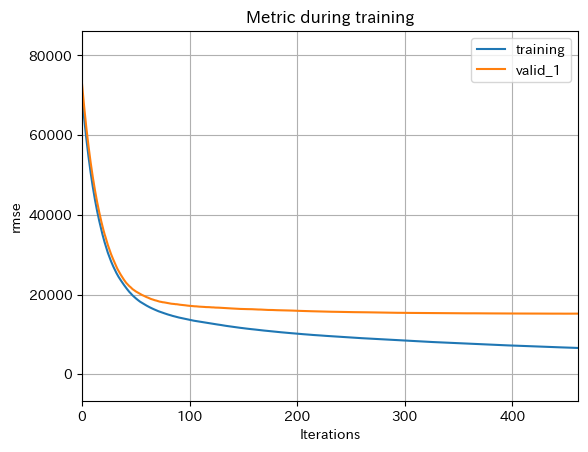

importance
面積               4.563174e+14
L                3.946260e+14
平均地価             2.005558e+14
最寄り駅             9.495720e+13
築年数              6.947521e+13
所在地              3.880605e+13
全体の階数            3.243532e+13
一部屋あたりの面積        2.800729e+13
契約期間             1.290859e+13
所在階              1.195919e+13
所要時間             6.834512e+12
部屋数              2.316138e+12
定期借家             1.884335e+12
バス・トイレ別          1.812803e+12
建物構造             1.031985e+12
D                5.750595e+11
100m^2以上         3.888453e+11
75m^2以上100m^2未満  2.958681e+11
50m^2以上75m^2未満   1.113515e+11
S                7.362256e+10
K                6.776959e+10

In [55]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

ベストスコアの16813!

In [43]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GBDT_cv_result.csv',index=False)

### 次にDARTで検証

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'K','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
[10]	training's rmse: 51672.5	valid_1's rmse: 52880.3
[20]	training's rmse: 37994.1	valid_1's rmse: 41100.5
[30]	training's rmse: 30376.3	valid_1's rmse: 34768.7
[40]	training's rmse: 27172.4	valid_1's rmse: 32159.8
[50]	training's rmse: 30573.3	valid_1's rmse: 35009.4
[60]	training's rmse: 34905.2	valid_1's rmse: 38841
[70]	training's rmse: 36808.7	valid_1's rmse: 40617.7
[80]	training's rmse: 31669.1	valid_1's rmse: 36074.8
[90]	training's rmse: 31566.7	valid_1's rmse: 35930.3
[100]	training's rmse: 33647.1	valid_1's rmse: 37787.6
[110]	training's rmse: 40551.6	valid_1's rmse: 43938.3
[120]	training's rmse: 32361.2	valid_1's rmse: 36678.8
[

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3085
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118435.786702
[10]	training's rmse: 51757.6	valid_1's rmse: 52241.4
[20]	training's rmse: 38274.5	valid_1's rmse: 39305.2
[30]	training's rmse: 30898.3	valid_1's rmse: 32437.1
[40]	training's rmse: 27807.7	valid_1's rmse: 29682.8
[50]	training's rmse: 31217.4	valid_1's rmse: 32930.8
[60]	training's rmse: 35446.5	valid_1's rmse: 37120.6
[70]	training's rmse: 37298	valid_1's rmse: 38958.7
[80]	training's rmse: 32313.9	valid_1's rmse: 34304.2
[90]	training's rmse: 32175.2	valid_1's rmse: 34192.4
[100]	training's rmse: 34161.2	valid_1's rmse: 36103.7
[110]	training's rmse: 40924.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 117892.049333
[10]	training's rmse: 51822	valid_1's rmse: 51550.2
[20]	training's rmse: 38522.2	valid_1's rmse: 37576.2
[30]	training's rmse: 31216.3	valid_1's rmse: 30332.1
[40]	training's rmse: 28270.1	valid_1's rmse: 27491.3
[50]	training's rmse: 31669.9	valid_1's rmse: 31262.5
[60]	training's rmse: 35677	valid_1's rmse: 35698.2
[70]	training's rmse: 37602.8	valid_1's rmse: 37485.9
[80]	training's rmse: 32755	valid_1's rmse: 32698.3
[90]	training's rmse: 32615	valid_1's rmse: 32581.4
[100]	training's rmse: 34599.9	valid_1's rmse: 34605.2
[110]	training's rmse: 41253.9	valid_1's rmse: 41291.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3087
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118280.850532
[10]	training's rmse: 52150.1	valid_1's rmse: 50614.9
[20]	training's rmse: 38443.3	valid_1's rmse: 38358.5
[30]	training's rmse: 30829.7	valid_1's rmse: 31821.1
[40]	training's rmse: 27706	valid_1's rmse: 29156.9
[50]	training's rmse: 31099.5	valid_1's rmse: 32549.5
[60]	training's rmse: 35260	valid_1's rmse: 36784.8
[70]	training's rmse: 37156.4	valid_1's rmse: 38675.1
[80]	training's rmse: 32120.8	valid_1's rmse: 33968.2
[90]	training's rmse: 31997.3	valid_1's rmse: 33733.2
[100]	training's rmse: 34001.3	valid_1's rmse: 35755.8
[110]	training's rmse: 40827.8	valid_1's rmse: 42

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3084
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118154.683071
[10]	training's rmse: 51450.5	valid_1's rmse: 53679.5
[20]	training's rmse: 38275.9	valid_1's rmse: 40101.8
[30]	training's rmse: 31076.3	valid_1's rmse: 32662.8
[40]	training's rmse: 28105.3	valid_1's rmse: 29651.2
[50]	training's rmse: 31435.9	valid_1's rmse: 32930.4
[60]	training's rmse: 35610.1	valid_1's rmse: 36898.9
[70]	training's rmse: 37459.7	valid_1's rmse: 38601.5
[80]	training's rmse: 32544.1	valid_1's rmse: 33733.3
[90]	training's rmse: 32382.7	valid_1's rmse: 33718.2
[100]	training's rmse: 34451.5	valid_1's rmse: 35587.1
[110]	training's rmse: 41136.8	valid_1's rmse

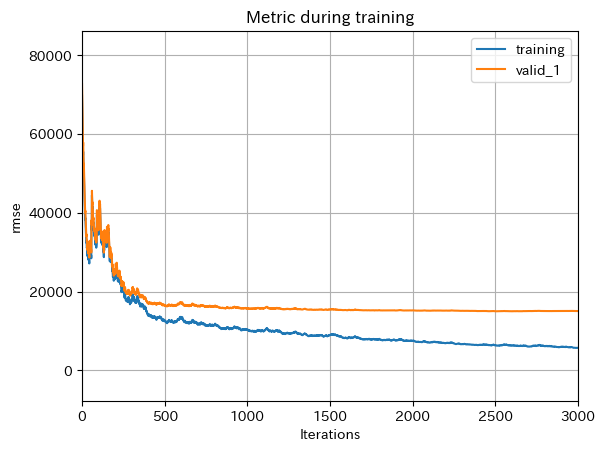

importance
面積               1.535315e+15
L                1.372736e+15
平均地価             8.100965e+14
築年数              2.889624e+14
最寄り駅             1.603750e+14
全体の階数            1.044920e+14
一部屋あたりの面積        9.757082e+13
所在地              8.662991e+13
契約期間             4.473332e+13
所在階              2.807880e+13
所要時間             2.708167e+13
バス・トイレ別          6.122550e+12
定期借家             5.520352e+12
建物構造             4.294631e+12
D                2.155208e+12
部屋数              2.015947e+12
100m^2以上         1.251966e+12
S                9.466534e+11
75m^2以上100m^2未満  7.552324e+11
K                6.211221e+11
50m^2以上75m^2未満   6.198636e+10

In [57]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GOSS = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'dart',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 6.823493012435797e-05,
        'max_bin': 435,
        'num_leaves': 82
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=3000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)


DARTでも16908という単体で低いスコアを達成！

In [46]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/DART_cv_result.csv',index=False)

### GOSSで試してみる

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'K','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3438
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.9	valid_1's rmse: 50219.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34350	valid_1's rmse: 37849.4
[30]	training's rmse: 25938.5	valid_1's rmse: 31026.5
[40]	training's rmse: 21199.4	valid_1's rmse: 27319
[50]	training's rmse: 18443.8	valid_1's rmse: 25112.4
[60]	training's rmse: 16770	valid_1's rmse: 23755.6
[70]	training's rmse: 15672.8	valid_1's rmse: 22849.9
[80]	training's rmse: 14866.5	valid_1's rmse: 22179.6
[90]	training's rmse: 14204.2	valid_1's rmse: 21633.1
[100]	training's rmse: 13664.8	valid_1's rmse: 21231.9
[110]	training's rmse: 13227.9	valid_1's rmse: 20882.7
[120]	training's rmse: 12821.3	valid_1's rmse: 20592.5
[130]	training's rmse: 12443.9	valid_1's rmse: 20334.8
[140]	training's rmse: 12072.8	valid_1's rmse: 20070.6
[150]	training's rmse: 11754.9	valid_1's rmse: 19852.1
[160]	training's rmse: 11476.5	valid_1's rmse: 19688.4
[170]	training's rmse: 11225.1	valid_1's rmse: 19565.8
[180]	training's rmse: 10958.4	valid_1's rmse: 19393.8
[190]	training's rmse: 10744.7	valid_1's rmse: 19283.9
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 26718.7	valid_1's rmse: 28603.3
[40]	training's rmse: 22285.9	valid_1's rmse: 24410
[50]	training's rmse: 19702.8	valid_1's rmse: 22101.1
[60]	training's rmse: 17951.3	valid_1's rmse: 20667.2
[70]	training's rmse: 16881.8	valid_1's rmse: 19984.1
[80]	training's rmse: 16034.5	valid_1's rmse: 19423.1
[90]	training's rmse: 15382.1	valid_1's rmse: 18929.4
[100]	training's rmse: 14877.6	valid_1's rmse: 18633.3
[110]	training's rmse: 14453.4	valid_1's rmse: 18432.4
[120]	training's rmse: 14044.5	valid_1's rmse: 18242.4
[130]	training's rmse: 13670.4	valid_1's rmse: 18174
[140]	training's rmse: 13269.9	valid_1's rmse: 18019.6
[150]	training's rmse: 12927	valid_1's rmse: 17853.9
[160]	training's rmse: 12595.5	valid_1's rmse: 17810.4
[170]	training's rmse: 12335.8	valid_1's rmse: 17727.5
[180]	training's rmse: 12059.4	valid_1's rmse: 17657.6
[190]	training's rmse: 11832.3	valid_1's rmse: 17627.7
[200]	training's rmse: 11596.4	valid_1's rmse: 17601
Early stopping, best iter

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3434
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49054.1	valid_1's rmse: 48657.6
[20]	training's rmse: 35191.1	valid_1's rmse: 34069.3
[30]	training's rmse: 27024.9	valid_1's rmse: 26138
[40]	training's rmse: 22454.8	valid_1's rmse: 22224
[50]	training's rmse: 19664.3	valid_1's rmse: 20344.9
[60]	training's rmse: 17917	valid_1's rmse: 19390.1
[70]	training's rmse: 16767.8	valid_1's rmse: 18852.4
[80]	training's rmse: 15916.3	valid_1's rmse: 18581.7
[90]	training's rmse: 15274.9	valid_1's rmse: 18371.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49223.8	valid_1's rmse: 48206.1
[20]	training's rmse: 34949.9	valid_1's rmse: 35461.9
[30]	training's rmse: 26589	valid_1's rmse: 28216.5
[40]	training's rmse: 21974.5	valid_1's rmse: 24583.5
[50]	training's rmse: 19221.2	valid_1's rmse: 22639.3
[60]	training's rmse: 17534.5	valid_1's rmse: 21527.9
[70]	training's rmse: 16423.1	valid_1's rmse: 21032.6
[80]	training's rmse: 15631.4	valid_1's rmse: 20674.1
[90]	training's rmse: 14974.5	valid_1's rmse: 20430.8
[100]	training's rmse: 14450.5	valid_1's rmse: 20243.5
[110]	training's rmse: 13983.1	valid_1's rmse: 20122.6
[120]	training's rmse: 13563.4	valid_1's rmse: 20037.1
[130]	training's rmse: 13201.2	valid_1's rmse: 19948.7
[140]	training's rmse: 12854.6	valid_1's rmse: 19834.2
[150]	training's rmse: 12558.8	valid_1's rmse: 19770
[160]	training's rmse: 12312.9	valid_1's rmse: 19736.2
[170]	training's rmse: 12045.1	valid_1's rmse: 19684.8
[180]	training's rmse: 11770	valid_1's rmse: 19642.4
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3434
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48744.2	valid_1's rmse: 51064.5
[20]	training's rmse: 34948.8	valid_1's rmse: 37029.1
[30]	training's rmse: 27090.8	valid_1's rmse: 28744.3
[40]	training's rmse: 22770.4	valid_1's rmse: 24450
[50]	training's rmse: 20094.6	valid_1's rmse: 21675.9
[60]	training's rmse: 18362.7	valid_1's rmse: 20138.7
[70]	training's rmse: 17213.6	valid_1's rmse: 19122.9
[80]	training's rmse: 16364.3	valid_1's rmse: 18492.6
[90]	training's rmse: 15702.5	valid_1's rmse: 18107.6
[100]	traini

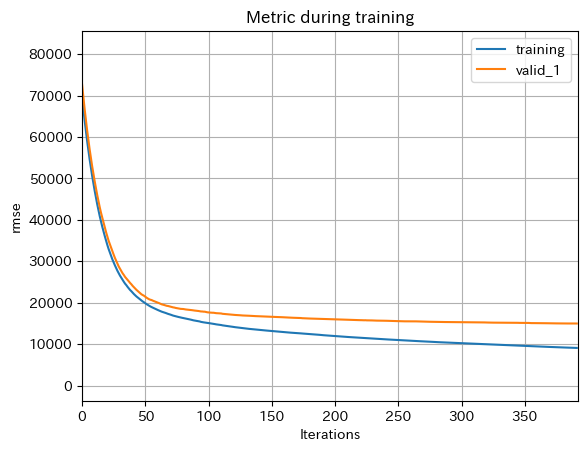

importance
面積               4.584221e+14
L                3.947539e+14
平均地価             2.216597e+14
最寄り駅             8.156750e+13
築年数              7.637920e+13
全体の階数            3.768389e+13
所在地              3.587632e+13
一部屋あたりの面積        2.917851e+13
契約期間             1.515595e+13
所在階              1.199838e+13
所要時間             1.009630e+13
定期借家             4.576258e+12
建物構造             1.304820e+12
部屋数              1.016384e+12
D                6.621365e+11
S                5.006102e+11
75m^2以上100m^2未満  3.547228e+11
100m^2以上         3.433284e+11
50m^2以上75m^2未満   3.041618e+11
K                1.321801e+11
バス・トイレ別          0.000000e+00

In [48]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GOSS = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 1.4135935551752292e-06,
        'max_bin': 528,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

GOSSも単体でベストスコアの16959!

GOSSのチューニングを実行してみる！

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'boosting_type':'goss',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=3000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_scores.append(mean_squared_error(y_val, y_pred_val, squared=False))
    loss = np.mean(rmse_scores)
    return loss

In [19]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-17 19:54:05,883] A new study created in memory with name: no-name-43f6e367-e5dd-4981-97dd-260a7330e79a
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48799.4	valid_1's rmse: 50157.3
[20]	training's rmse: 34415.6	valid_1's rmse: 37827.5
[30]	training's rmse: 25844	valid_1's rmse: 30883.2
[40]	training's rmse: 21265.3	valid_1's rmse: 27388.2
[50]	training's rmse: 18401.8	valid_1's rmse: 25191.6
[60]	training's rmse: 16646.4	valid_1's rmse: 23797.7
[70]	training's rmse: 15507.1	valid_1's rmse: 22881.5
[80]	training's rmse: 14704.7	valid_1's rmse: 22218.4
[90]	training's rmse: 14060.3	valid_1's rmse: 21730
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48977.3	valid_1's rmse: 49577.3
[20]	training's rmse: 34964.7	valid_1's rmse: 36026.4
[30]	training's rmse: 26928.9	valid_1's rmse: 28473
[40]	training's rmse: 22444.9	valid_1's rmse: 24339.2
[50]	training's rmse: 19676.3	valid_1's rmse: 22099.7
[60]	training's rmse: 18015.3	valid_1's rmse: 20805.8
[70]	training's rmse: 16882.7	valid_1's rmse: 20019.7
[80]	training's rmse: 16112.4	valid_1's rmse: 19434
[90]	training's rmse: 15497.7	valid_1's rmse: 19168.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35378	valid_1's rmse: 33772.1
[30]	training's rmse: 26980.9	valid_1's rmse: 25543.7
[40]	training's rmse: 22501.5	valid_1's rmse: 21472.1
[50]	training's rmse: 19745.8	valid_1's rmse: 19624.8
[60]	training's rmse: 17901.4	valid_1's rmse: 18627.1
[70]	training's rmse: 16730.7	valid_1's rmse: 18161.1
[80]	training's rmse: 15825.5	valid_1's rmse: 17879.8
[90]	training's rmse: 15149	valid_1's rmse: 17735.3
[100]	training's rmse: 14541.4	valid_1's rmse: 17554.6
[110]	training's rmse: 14067.3	valid_1's rmse: 17410
[120]	training's rmse: 13627	valid_1's rmse: 17274.1
[130]	training's rmse: 13233.6	valid_1's rmse: 17182.1
[140]	training's rmse: 12874.3	valid_1's rmse: 17135.6
[150]	training's rmse: 12558.5	valid_1's rmse: 17071.9
[160]	training's rmse: 12272.5	valid_1's rmse: 17044
[170]	training's rmse: 11963.6	valid_1's rmse: 17019.2
[180]	training's rmse: 11717.4	valid_1's rmse: 16963.2
[190]	training's rmse: 11476.7	valid_1's rmse: 16977.4
Early stopping, best iterati

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49230.7	valid_1's rmse: 48160.2
[20]	training's rmse: 34915.9	valid_1's rmse: 35117.2
[30]	training's rmse: 26632.6	valid_1's rmse: 28038.4
[40]	training's rmse: 22118.7	valid_1's rmse: 24470.9
[50]	training's rmse: 19300.9	valid_1's rmse: 22344.7
[60]	training's rmse: 17609.1	valid_1's rmse: 21277.7
[70]	training's rmse: 16362.2	valid_1's rmse: 20683.8
[80]	training's rmse: 15496.9	valid_1's rmse: 20393.4
[90]	training's rmse: 14870.6	valid_1's rmse: 20085.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48661.5	valid_1's rmse: 50996.5
[20]	training's rmse: 34952.3	valid_1's rmse: 37053.2
[30]	training's rmse: 27130.4	valid_1's rmse: 28768.1
[40]	training's rmse: 22953.5	valid_1's rmse: 24322.1
[50]	training's rmse: 20223.7	valid_1's rmse: 21671.8
[60]	training's rmse: 18494	valid_1's rmse: 20127
[70]	training's rmse: 17282.2	valid_1's rmse: 19070.5
[80]	training's rmse: 16449.8	valid_1's rmse: 18413.8
[90]	training's rmse: 15728.6	valid_1's rmse: 17939.6
[100]	training's rmse: 15232	valid_1's rmse: 17598.1
[110]	training's rmse: 14712.9	valid_1's rmse: 17289.7
[120]	training's rmse: 14288.9	valid_1's rmse: 17088.5
[130]	training's rmse: 13895.2	valid_1's rmse: 16897.4
[140]	training's rmse: 13499.9	valid_1's rmse: 16682.1
[150]	training's rmse: 13154.3	valid_1's rmse: 16462.6
[160]	training's rmse: 12900.5	valid_1's rmse: 16362.3
[170]	training's rmse: 12635.4	valid_1's rmse: 16249.8
[180]	training's rmse: 12386.4	valid_1's rmse: 16136
[190]	training's rmse: 1215

[I 2022-09-17 19:54:28,064] Trial 0 finished with value: 16853.187050285047 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2917
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48692.6	valid_1's rmse: 50029.6
[20]	training's rmse: 34289.6	valid_1's rmse: 37766.9
[30]	training's rmse: 25837.1	valid_1's rmse: 30827
[40]	training's rmse: 21113.3	valid_1's rmse: 27208.9
[50]	training's rmse: 18409	valid_1's rmse: 25115.9
[60]	training's rmse: 16672.5	valid_1's rmse: 23799.4
[70]	training's rmse: 15552.7	valid_1's rmse: 22921.8
[80]	training's rmse: 14739	valid_1's rmse: 22298.4
[90]	training's rmse: 14053.5	valid_1's rmse: 21785.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2913
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48963.9	valid_1's rmse: 49814.9
[20]	training's rmse: 34916.9	valid_1's rmse: 36433.5
[30]	training's rmse: 26978.6	valid_1's rmse: 29191.5
[40]	training's rmse: 22454.1	valid_1's rmse: 25154
[50]	training's rmse: 19779.9	valid_1's rmse: 22717.9
[60]	training's rmse: 18116.5	valid_1's rmse: 21324.3
[70]	training's rmse: 16934.1	valid_1's rmse: 20412.3
[80]	training's rmse: 15955.6	valid_1's rmse: 19867.4
[90]	training's rmse: 15266.1	valid_1's rmse: 19506.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34851.6	valid_1's rmse: 34444.2
[30]	training's rmse: 26608.8	valid_1's rmse: 26418.2
[40]	training's rmse: 22117.8	valid_1's rmse: 22427.8
[50]	training's rmse: 19447.1	valid_1's rmse: 20448.9
[60]	training's rmse: 17778.8	valid_1's rmse: 19435.9
[70]	training's rmse: 16574.6	valid_1's rmse: 18934.1
[80]	training's rmse: 15751.4	valid_1's rmse: 18681.5
[90]	training's rmse: 15050.3	valid_1's rmse: 18460
[100]	training's rmse: 14478.8	valid_1's rmse: 18278
[110]	training's rmse: 13960.5	valid_1's rmse: 18142.3
[120]	training's rmse: 13538.7	valid_1's rmse: 18096.6
[130]	training's rmse: 13173.6	valid_1's rmse: 17981.9
[140]	training's rmse: 12818.6	valid_1's rmse: 17879.2
[150]	training's rmse: 12478.8	valid_1's rmse: 17834.6
[160]	training's rmse: 12151	valid_1's rmse: 17814.2
[170]	training's rmse: 11850	valid_1's rmse: 17747.1
[180]	training's rmse: 11598.4	valid_1's rmse: 17672.5
[190]	training's rmse: 11361.2	valid_1's rmse: 17623.7
[200]	training's rmse: 111

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49161.9	valid_1's rmse: 48074.9
[20]	training's rmse: 34785.4	valid_1's rmse: 35373
[30]	training's rmse: 26397.6	valid_1's rmse: 28332.5
[40]	training's rmse: 21742.7	valid_1's rmse: 24644
[50]	training's rmse: 18996.5	valid_1's rmse: 22830.1
[60]	training's rmse: 17345.2	valid_1's rmse: 21866.7
[70]	training's rmse: 16195.3	valid_1's rmse: 21375
[80]	training's rmse: 15371.8	valid_1's rmse: 21040
[90]	training's rmse: 14713.1	valid_1's rmse: 20769.9
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2914
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48638.5	valid_1's rmse: 50983.6
[20]	training's rmse: 34994.2	valid_1's rmse: 36990.1
[30]	training's rmse: 26972.3	valid_1's rmse: 28559.6
[40]	training's rmse: 22563.4	valid_1's rmse: 23894.7
[50]	training's rmse: 19891.7	valid_1's rmse: 21214.3
[60]	training's rmse: 18248.7	valid_1's rmse: 19834.4
[70]	training's rmse: 17034.9	valid_1's rmse: 19036.6
[80]	training's rmse: 16196	valid_1's rmse: 18416.4
[90]	training's rmse: 15572.9	valid_1's rmse: 18088.5
[100]	traini

[I 2022-09-17 19:54:48,734] Trial 1 finished with value: 17066.087792073125 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16853.187050285047.


[450]	training's rmse: 8255.71	valid_1's rmse: 15149
Early stopping, best iteration is:
[443]	training's rmse: 8316.56	valid_1's rmse: 15137.7
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3562
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48379.6	valid_1's rmse: 49956.6
[20]	training's rmse: 33929.6	valid_1's rmse: 37657.9
[30]	training's rmse: 25464.1	valid_1's rmse: 30929.3
[40]	training's rmse: 20728.8	valid_1's rmse: 27166.9
[50]	training's rmse: 17878.1	valid_1's rmse: 24909.7
[60]	training's rmse: 16165	valid_1's rmse: 23476.3
[70]	training's rmse: 15048.5	valid_1's rmse: 22567.4
[80]	training's rmse: 14246.7	valid_1's rmse: 21891.9
[90]	training's rmse: 13596	valid_1's rmse: 21417.2
[100]	training's rmse: 13062.1	valid_1's rmse: 21051.5
[110]	training's rmse: 12592.4	valid_1's rmse: 20732.4
[120]	training's rmse: 12150.6	valid_1's rmse: 20397.9
[130]	training's rmse: 11766.3	valid_1's rmse: 20117.8
[140]	training's rmse: 11384	valid_1's rmse: 19879.1
[150]	training's rmse: 11053.6	valid_1's rmse: 19688.1
[160]	training's rmse: 10750.4	valid_1's rmse: 19497.6
[170]	training's rmse: 10498.1	valid_1's rmse: 19358.5
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3565
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48753.6	valid_1's rmse: 49623.7
[20]	training's rmse: 34609	valid_1's rmse: 36120.8
[30]	training's rmse: 26411.3	valid_1's rmse: 28549.8
[40]	training's rmse: 22027.4	valid_1's rmse: 24404.6
[50]	training's rmse: 19315.2	valid_1's rmse: 22123
[60]	training's rmse: 17620.5	valid_1's rmse: 20735.9
[70]	training's rmse: 16497.8	valid_1's rmse: 19889.8
[80]	training's rmse: 15682.8	valid_1's rmse: 19355.8
[90]	training's rmse: 15074.5	valid_1's rmse: 18855.8
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48768.7	valid_1's rmse: 48340.8
[20]	training's rmse: 34777.9	valid_1's rmse: 33675.2
[30]	training's rmse: 26531.1	valid_1's rmse: 25557.9
[40]	training's rmse: 21861.7	valid_1's rmse: 21761.7
[50]	training's rmse: 19145.6	valid_1's rmse: 19908.3
[60]	training's rmse: 17435.4	valid_1's rmse: 19147
[70]	training's rmse: 16313.6	valid_1's rmse: 18686.1
[80]	training's rmse: 15415.5	valid_1's rmse: 18319.5
[90]	training's rmse: 14750.4	valid_1's rmse: 18040.2
[100]	training's rmse: 14202.3	valid_1's rmse: 17921.8
[110]	training's rmse: 13703.4	valid_1's rmse: 17827
[120]	training's rmse: 13243.6	valid_1's rmse: 17746.8
[130]	training's rmse: 12864.2	valid_1's rmse: 17681.6
[140]	training's rmse: 12489.1	valid_1's rmse: 17596.8
[150]	training's rmse: 12155.8	valid_1's rmse: 17570.3
[160]	training's rmse: 11869.4	valid_1's rmse: 17506.6
[170]	training's rmse: 11560.8	valid_1's rmse: 17476.1
[180]	training's rmse: 11312	valid_1's rmse: 17412.6
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48816.5	valid_1's rmse: 47934.1
[20]	training's rmse: 34357.2	valid_1's rmse: 35562.4
[30]	training's rmse: 25949.8	valid_1's rmse: 28587.8
[40]	training's rmse: 21291.2	valid_1's rmse: 25033.2
[50]	training's rmse: 18692.9	valid_1's rmse: 23179.7
[60]	training's rmse: 17019.2	valid_1's rmse: 22098.5
[70]	training's rmse: 15865.9	valid_1's rmse: 21527.8
[80]	training's rmse: 15052.3	valid_1's rmse: 21223.9
[90]	training's rmse: 14391.6	valid_1's rmse: 21033.6
[100]	training's rmse: 13852.6	valid_1's rmse: 20826.3
[110]	training's rmse: 13438	valid_1's rmse: 20729.1
[120]	training's rmse: 13017.8	valid_1's rmse: 20565.5
[130]	training's rmse: 12643.2	valid_1's rmse: 20411.4
[140]	training's rmse: 12320.9	valid_1's rmse: 20371.4
[150]	training's rmse: 12006.2	valid_1's rmse: 20265.1
[160]	training's rmse: 11716.6	valid_1's rmse: 20175.4
[170]	training's rmse: 11463.2	valid_1's rmse: 20093.1
[180]	training's rmse: 11207.5	valid_1's rmse: 20051.1
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3564
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48292.8	valid_1's rmse: 50749.7
[20]	training's rmse: 34343.8	valid_1's rmse: 36732.2
[30]	training's rmse: 26402.3	valid_1's rmse: 28344.6
[40]	training's rmse: 21958.2	valid_1's rmse: 23785.7
[50]	training's rmse: 19477.4	valid_1's rmse: 21281.9
[60]	training's rmse: 17769	valid_1's rmse: 19799.8
[70]	training's rmse: 16593.3	valid_1's rmse: 18741.6
[80]	training's rmse: 15792.1	valid_1's rmse: 18149.3
[90]	training's rmse: 15159.7	valid_1's rmse: 17747.8
[100]	traini

[I 2022-09-17 19:55:14,577] Trial 2 finished with value: 16992.90325518872 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3438
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.9	valid_1's rmse: 50219.7
[20]	training's rmse: 34350	valid_1's rmse: 37849.4
[30]	training's rmse: 25938.5	valid_1's rmse: 31026.5
[40]	training's rmse: 21199.4	valid_1's rmse: 27319
[50]	training's rmse: 18443.8	valid_1's rmse: 25112.4
[60]	training's rmse: 16770	valid_1's rmse: 23755.6
[70]	training's rmse: 15672.8	valid_1's rmse: 22849.9
[80]	training's rmse: 14866.5	valid_1's rmse: 22179.6
[90]	training's rmse: 14204.2	valid_1's rmse: 21633.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3437
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48908.7	valid_1's rmse: 49540.9
[20]	training's rmse: 34869.4	valid_1's rmse: 36427.5
[30]	training's rmse: 26718.7	valid_1's rmse: 28603.3
[40]	training's rmse: 22285.9	valid_1's rmse: 24410
[50]	training's rmse: 19702.8	valid_1's rmse: 22101.1
[60]	training's rmse: 17951.3	valid_1's rmse: 20667.2
[70]	training's rmse: 16881.8	valid_1's rmse: 19984.1
[80]	training's rmse: 16034.5	valid_1's rmse: 19423.1
[90]	training's rmse: 15382.1	valid_1's rmse: 18929.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35191.1	valid_1's rmse: 34069.3
[30]	training's rmse: 27024.9	valid_1's rmse: 26138
[40]	training's rmse: 22454.8	valid_1's rmse: 22224
[50]	training's rmse: 19664.3	valid_1's rmse: 20344.9
[60]	training's rmse: 17917	valid_1's rmse: 19390.1
[70]	training's rmse: 16767.8	valid_1's rmse: 18852.4
[80]	training's rmse: 15916.3	valid_1's rmse: 18581.7
[90]	training's rmse: 15274.9	valid_1's rmse: 18371.4
[100]	training's rmse: 14735.8	valid_1's rmse: 18218.6
[110]	training's rmse: 14208.7	valid_1's rmse: 18086.6
[120]	training's rmse: 13780.4	valid_1's rmse: 18047.6
[130]	training's rmse: 13366	valid_1's rmse: 17963
[140]	training's rmse: 13003.8	valid_1's rmse: 17882.4
[150]	training's rmse: 12649.1	valid_1's rmse: 17775.3
[160]	training's rmse: 12353.7	valid_1's rmse: 17713.4
[170]	training's rmse: 12089.7	valid_1's rmse: 17608.9
[180]	training's rmse: 11822.8	valid_1's rmse: 17540.7
[190]	training's rmse: 11596.2	valid_1's rmse: 17527.8
[200]	training's rmse: 11345

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34949.9	valid_1's rmse: 35461.9
[30]	training's rmse: 26589	valid_1's rmse: 28216.5
[40]	training's rmse: 21974.5	valid_1's rmse: 24583.5
[50]	training's rmse: 19221.2	valid_1's rmse: 22639.3
[60]	training's rmse: 17534.5	valid_1's rmse: 21527.9
[70]	training's rmse: 16423.1	valid_1's rmse: 21032.6
[80]	training's rmse: 15631.4	valid_1's rmse: 20674.1
[90]	training's rmse: 14974.5	valid_1's rmse: 20430.8
[100]	training's rmse: 14450.5	valid_1's rmse: 20243.5
[110]	training's rmse: 13983.1	valid_1's rmse: 20122.6
[120]	training's rmse: 13563.4	valid_1's rmse: 20037.1
[130]	training's rmse: 13201.2	valid_1's rmse: 19948.7
[140]	training's rmse: 12854.6	valid_1's rmse: 19834.2
[150]	training's rmse: 12558.8	valid_1's rmse: 19770
[160]	training's rmse: 12312.9	valid_1's rmse: 19736.2
[170]	training's rmse: 12045.1	valid_1's rmse: 19684.8
[180]	training's rmse: 11770	valid_1's rmse: 19642.4
[190]	training's rmse: 11556.6	valid_1's rmse: 19588.1
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3434
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48744.2	valid_1's rmse: 51064.5
[20]	training's rmse: 34948.8	valid_1's rmse: 37029.1
[30]	training's rmse: 27090.8	valid_1's rmse: 28744.3
[40]	training's rmse: 22770.4	valid_1's rmse: 24450
[50]	training's rmse: 20094.6	valid_1's rmse: 21675.9
[60]	training's rmse: 18362.7	valid_1's rmse: 20138.7
[70]	training's rmse: 17213.6	valid_1's rmse: 19122.9
[80]	training's rmse: 16364.3	valid_1's rmse: 18492.6
[90]	training's rmse: 15702.5	valid_1's rmse: 18107.6
[100]	traini

[I 2022-09-17 19:55:30,191] Trial 3 finished with value: 16977.251586917933 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16853.187050285047.


[390]	training's rmse: 9108.24	valid_1's rmse: 14986.4
Early stopping, best iteration is:
[382]	training's rmse: 9196.09	valid_1's rmse: 14980.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3607
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49272.3	valid_1's rmse: 50742.2
[20]	training's rmse: 35117.8	valid_1's rmse: 38620.6
[30]	training's rmse: 26767.7	valid_1's rmse: 31672.5
[40]	training's rmse: 22054.1	valid_1's rmse: 27846.6
[50]	training's rmse: 19285	valid_1's rmse: 25624.9
[60]	training's rmse: 17623.8	valid_1's rmse: 24278.9
[70]	training's rmse: 16459.3	valid_1's rmse: 23269.3
[80]	training's rmse: 15688.4	valid_1's rmse: 22622.2
[90]	training's rmse: 15004.7	valid_1's rmse: 22064.5
[100]	training's rmse: 14517.9	valid_1's rmse: 21664.8
[110]	training's rmse: 14105.9	valid_1's rmse: 21332.2
[120]	training's rmse: 13697.8	valid_1's rmse: 20974.5
[130]	training's rmse: 13351.8	valid_1's rmse: 20733.9
[140]	training's rmse: 13055.2	valid_1's rmse: 20500
[150]	training's rmse: 12772.5	valid_1's rmse: 20297.8
[160]	training's rmse: 12487.3	valid_1's rmse: 20094.5
[170]	training's rmse: 12219.7	valid_1's rmse: 19898
[180]	training's rmse: 11995.9	valid_1's rmse: 19735
[190]	training's rmse: 1176

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3606
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49498	valid_1's rmse: 49956.1
[20]	training's rmse: 35563.2	valid_1's rmse: 36801.7
[30]	training's rmse: 27609.3	valid_1's rmse: 29146.8
[40]	training's rmse: 23277.6	valid_1's rmse: 25036.3
[50]	training's rmse: 20563	valid_1's rmse: 22508.8
[60]	training's rmse: 18845	valid_1's rmse: 21075.2
[70]	training's rmse: 17783	valid_1's rmse: 20117.3
[80]	training's rmse: 16942.2	valid_1's rmse: 19520.7
[90]	training's rmse: 16297.2	valid_1's rmse: 19130.5
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[40]	training's rmse: 23177.4	valid_1's rmse: 22923.1
[50]	training's rmse: 20523.3	valid_1's rmse: 21010.3
[60]	training's rmse: 18775.5	valid_1's rmse: 20003
[70]	training's rmse: 17577.6	valid_1's rmse: 19449.3
[80]	training's rmse: 16749	valid_1's rmse: 19079.6
[90]	training's rmse: 16119.2	valid_1's rmse: 18853
[100]	training's rmse: 15562.7	valid_1's rmse: 18713.2
[110]	training's rmse: 15094.7	valid_1's rmse: 18585.5
[120]	training's rmse: 14657	valid_1's rmse: 18526.9
[130]	training's rmse: 14256.6	valid_1's rmse: 18401.4
[140]	training's rmse: 13937.5	valid_1's rmse: 18335.6
[150]	training's rmse: 13635.6	valid_1's rmse: 18290.2
[160]	training's rmse: 13330.8	valid_1's rmse: 18293.4
[170]	training's rmse: 13073.5	valid_1's rmse: 18256.8
[180]	training's rmse: 12842.4	valid_1's rmse: 18270.3
Early stopping, best iteration is:
[174]	training's rmse: 12983.2	valid_1's rmse: 18250.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3615
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49516.6	valid_1's rmse: 48642.2
[20]	training's rmse: 35395.2	valid_1's rmse: 36350.5
[30]	training's rmse: 27158.2	valid_1's rmse: 29331.7
[40]	training's rmse: 22679.5	valid_1's rmse: 25723.8
[50]	training's rmse: 19924	valid_1's rmse: 23777.8
[60]	training's rmse: 18206.8	valid_1's rmse: 22662.1
[70]	training's rmse: 17088.6	valid_1's rmse: 22086.9
[80]	training's rmse: 16268.5	valid_1's rmse: 21691
[90]	training's rmse: 15642.9	valid_1's rmse: 21379.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3609
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49162.1	valid_1's rmse: 51570.5
[20]	training's rmse: 35640.9	valid_1's rmse: 37592.2
[30]	training's rmse: 27762.6	valid_1's rmse: 29129.8
[40]	training's rmse: 23396.7	valid_1's rmse: 24499.8
[50]	training's rmse: 20781.6	valid_1's rmse: 21926.1
[60]	training's rmse: 19051.6	valid_1's rmse: 20177.7
[70]	training's rmse: 17919.9	valid_1's rmse: 19309.5
[80]	training's rmse: 17157	valid_1's rmse: 18734.6
[90]	training's rmse: 16510.9	valid_1's rmse: 18271.5
[100]	traini

[I 2022-09-17 19:55:45,399] Trial 4 finished with value: 17004.217781231608 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50280
[20]	training's rmse: 34448	valid_1's rmse: 38137
[30]	training's rmse: 26125.4	valid_1's rmse: 31334.8
[40]	training's rmse: 21358.2	valid_1's rmse: 27605.4
[50]	training's rmse: 18622.7	valid_1's rmse: 25507.7
[60]	training's rmse: 16903.5	valid_1's rmse: 24067.2
[70]	training's rmse: 15767.7	valid_1's rmse: 23099.8
[80]	training's rmse: 14887.9	valid_1's rmse: 22363.8
[90]	training's rmse: 14249.7	valid_1's rmse: 21804.7
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48785.4	valid_1's rmse: 49335
[20]	training's rmse: 34719	valid_1's rmse: 35906
[30]	training's rmse: 26767.6	valid_1's rmse: 28264.4
[40]	training's rmse: 22300	valid_1's rmse: 24243.1
[50]	training's rmse: 19533.1	valid_1's rmse: 21963.4
[60]	training's rmse: 17882.6	valid_1's rmse: 20774.6
[70]	training's rmse: 16724	valid_1's rmse: 19829.5
[80]	training's rmse: 15818.4	valid_1's rmse: 19267.1
[90]	training's rmse: 15091.4	valid_1's rmse: 18891.7
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48943.6	valid_1's rmse: 48823.2
[20]	training's rmse: 34947.7	valid_1's rmse: 34640.8
[30]	training's rmse: 26823.2	valid_1's rmse: 26710.6
[40]	training's rmse: 22451.6	valid_1's rmse: 22780.4
[50]	training's rmse: 19737	valid_1's rmse: 20843.6
[60]	training's rmse: 17978.4	valid_1's rmse: 19708.1
[70]	training's rmse: 16727.1	valid_1's rmse: 19161.2
[80]	training's rmse: 15848.2	valid_1's rmse: 18890.8
[90]	training's rmse: 15116.8	valid_1's rmse: 18625
[100]	training's rmse: 14555.9	valid_1's rmse: 18453.6
[110]	training's rmse: 14048.4	valid_1's rmse: 18332.8
[120]	training's rmse: 13584.9	valid_1's rmse: 18202.2
[130]	training's rmse: 13186	valid_1's rmse: 18105.5
[140]	training's rmse: 12811.2	valid_1's rmse: 18055.8
[150]	training's rmse: 12455.4	valid_1's rmse: 17990.4
[160]	training's rmse: 12156.3	valid_1's rmse: 17931
[170]	training's rmse: 11865.1	valid_1's rmse: 17888.3
[180]	training's rmse: 11594.5	valid_1's rmse: 17793.1
[190]	training's rmse: 1134

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2355
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49093.5	valid_1's rmse: 47839
[20]	training's rmse: 34868.5	valid_1's rmse: 35132.9
[30]	training's rmse: 26669.1	valid_1's rmse: 28195.9
[40]	training's rmse: 22018	valid_1's rmse: 24450
[50]	training's rmse: 19394.7	valid_1's rmse: 22506.1
[60]	training's rmse: 17701.1	valid_1's rmse: 21423.7
[70]	training's rmse: 16500.4	valid_1's rmse: 20822.9
[80]	training's rmse: 15655.5	valid_1's rmse: 20486.5
[90]	training's rmse: 14937.4	valid_1's rmse: 20237.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48458.7	valid_1's rmse: 50917.5
[20]	training's rmse: 34782.2	valid_1's rmse: 36823.4
[30]	training's rmse: 26869.8	valid_1's rmse: 28568.6
[40]	training's rmse: 22549.6	valid_1's rmse: 23986.3
[50]	training's rmse: 19931.3	valid_1's rmse: 21289
[60]	training's rmse: 18347.4	valid_1's rmse: 19821.2
[70]	training's rmse: 17199.7	valid_1's rmse: 18850.9
[80]	training's rmse: 16238.2	valid_1's rmse: 18159.1
[90]	training's rmse: 15468.1	valid_1's rmse: 17655.5
[100]	traini

[I 2022-09-17 19:56:05,909] Trial 5 finished with value: 16973.65677723808 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48399.1	valid_1's rmse: 50002.7
[20]	training's rmse: 33866.2	valid_1's rmse: 37582.5
[30]	training's rmse: 25327.9	valid_1's rmse: 30684.7
[40]	training's rmse: 20686.6	valid_1's rmse: 27085.5
[50]	training's rmse: 17961.6	valid_1's rmse: 24912.7
[60]	training's rmse: 16304.8	valid_1's rmse: 23542.9
[70]	training's rmse: 15208.8	valid_1's rmse: 22704.6
[80]	training's rmse: 14381.8	valid_1's rmse: 22051.3
[90]	training's rmse: 13698	valid_1's rmse: 21482.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3540
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48755.3	valid_1's rmse: 49615.3
[20]	training's rmse: 34619.7	valid_1's rmse: 36194.6
[30]	training's rmse: 26614.5	valid_1's rmse: 28772.6
[40]	training's rmse: 22226	valid_1's rmse: 24716
[50]	training's rmse: 19559.4	valid_1's rmse: 22378.5
[60]	training's rmse: 17810.4	valid_1's rmse: 20969.7
[70]	training's rmse: 16690.5	valid_1's rmse: 20034.9
[80]	training's rmse: 15801.8	valid_1's rmse: 19348.2
[90]	training's rmse: 15173.1	valid_1's rmse: 18909.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48751.1	valid_1's rmse: 48289.1
[20]	training's rmse: 34752.5	valid_1's rmse: 33707.6
[30]	training's rmse: 26520	valid_1's rmse: 25666.8
[40]	training's rmse: 21989.7	valid_1's rmse: 21855.3
[50]	training's rmse: 19273.8	valid_1's rmse: 20176.5
[60]	training's rmse: 17502.6	valid_1's rmse: 19272.2
[70]	training's rmse: 16321.9	valid_1's rmse: 18820.4
[80]	training's rmse: 15456.5	valid_1's rmse: 18511.9
[90]	training's rmse: 14752.1	valid_1's rmse: 18331.5
[100]	training's rmse: 14188.3	valid_1's rmse: 18225.6
[110]	training's rmse: 13622.3	valid_1's rmse: 18107.1
[120]	training's rmse: 13189.5	valid_1's rmse: 17975.8
[130]	training's rmse: 12772.2	valid_1's rmse: 17912.5
[140]	training's rmse: 12406.1	valid_1's rmse: 17802.2
[150]	training's rmse: 12084.9	valid_1's rmse: 17756
[160]	training's rmse: 11796.2	valid_1's rmse: 17721.1
[170]	training's rmse: 11513	valid_1's rmse: 17659.2
[180]	training's rmse: 11234.1	valid_1's rmse: 17655.4
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3539
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48776.4	valid_1's rmse: 47887.4
[20]	training's rmse: 34285.6	valid_1's rmse: 35339.2
[30]	training's rmse: 25895.4	valid_1's rmse: 28378.2
[40]	training's rmse: 21316.7	valid_1's rmse: 24864.8
[50]	training's rmse: 18675.8	valid_1's rmse: 23042.9
[60]	training's rmse: 16991.5	valid_1's rmse: 22054.8
[70]	training's rmse: 15800.5	valid_1's rmse: 21508.1
[80]	training's rmse: 14970.6	valid_1's rmse: 21161.3
[90]	training's rmse: 14350.3	valid_1's rmse: 20965.1
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3540
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48284.4	valid_1's rmse: 50781.1
[20]	training's rmse: 34441.8	valid_1's rmse: 36869.8
[30]	training's rmse: 26418.3	valid_1's rmse: 28307.4
[40]	training's rmse: 22024.1	valid_1's rmse: 23688
[50]	training's rmse: 19471.6	valid_1's rmse: 21222.7
[60]	training's rmse: 17879.2	valid_1's rmse: 19737
[70]	training's rmse: 16657.7	valid_1's rmse: 18761
[80]	training's rmse: 15819.3	valid_1's rmse: 18087.5
[90]	training's rmse: 15103	valid_1's rmse: 17574.9
[100]	training's r

[I 2022-09-17 19:56:24,830] Trial 6 finished with value: 16972.40134385033 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48729.1	valid_1's rmse: 50361.2
[20]	training's rmse: 34270.6	valid_1's rmse: 38008
[30]	training's rmse: 25844.8	valid_1's rmse: 31212.1
[40]	training's rmse: 21055.3	valid_1's rmse: 27412.6
[50]	training's rmse: 18372.4	valid_1's rmse: 25325.6
[60]	training's rmse: 16635.2	valid_1's rmse: 23933.9
[70]	training's rmse: 15502.7	valid_1's rmse: 23015.6
[80]	training's rmse: 14646.2	valid_1's rmse: 22322.2
[90]	training's rmse: 13976.7	valid_1's rmse: 21779.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48848.6	valid_1's rmse: 49720.3
[20]	training's rmse: 34743.3	valid_1's rmse: 36298.4
[30]	training's rmse: 26924	valid_1's rmse: 29194.8
[40]	training's rmse: 22468.1	valid_1's rmse: 25121.8
[50]	training's rmse: 19835.3	valid_1's rmse: 22713.6
[60]	training's rmse: 18119.7	valid_1's rmse: 21303.8
[70]	training's rmse: 16988.2	valid_1's rmse: 20484.3
[80]	training's rmse: 16053.4	valid_1's rmse: 19955.4
[90]	training's rmse: 15302.2	valid_1's rmse: 19481.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2981
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48760.6	valid_1's rmse: 48562.7
[20]	training's rmse: 34751.2	valid_1's rmse: 34282.2
[30]	training's rmse: 26709.2	valid_1's rmse: 26395.1
[40]	training's rmse: 22248.5	valid_1's rmse: 22416.4
[50]	training's rmse: 19506.5	valid_1's rmse: 20353.8
[60]	training's rmse: 17783.3	valid_1's rmse: 19262.1
[70]	training's rmse: 16592.4	valid_1's rmse: 18765.3
[80]	training's rmse: 15668.2	valid_1's rmse: 18426
[90]	training's rmse: 14929.4	valid_1's rmse: 18130.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34747.1	valid_1's rmse: 35348.7
[30]	training's rmse: 26402.7	valid_1's rmse: 28258.1
[40]	training's rmse: 21749.9	valid_1's rmse: 24642.9
[50]	training's rmse: 19081	valid_1's rmse: 22800.3
[60]	training's rmse: 17397.6	valid_1's rmse: 21685.9
[70]	training's rmse: 16185.6	valid_1's rmse: 21054.9
[80]	training's rmse: 15301.2	valid_1's rmse: 20710.4
[90]	training's rmse: 14651.2	valid_1's rmse: 20518.9
[100]	training's rmse: 14112.7	valid_1's rmse: 20358
[110]	training's rmse: 13621.1	valid_1's rmse: 20241.7
[120]	training's rmse: 13172.5	valid_1's rmse: 20072.5
[130]	training's rmse: 12769.2	valid_1's rmse: 20000.7
[140]	training's rmse: 12451.4	valid_1's rmse: 19916.2
[150]	training's rmse: 12143.2	valid_1's rmse: 19921.6
[160]	training's rmse: 11872.7	valid_1's rmse: 19804.8
[170]	training's rmse: 11620	valid_1's rmse: 19718.5
[180]	training's rmse: 11380.9	valid_1's rmse: 19666
[190]	training's rmse: 11155.6	valid_1's rmse: 19595.7
[200]	training's rmse: 109

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48580.7	valid_1's rmse: 50871.3
[20]	training's rmse: 34881.6	valid_1's rmse: 36849.2
[30]	training's rmse: 27058.9	valid_1's rmse: 28726.2
[40]	training's rmse: 22803.1	valid_1's rmse: 24290.2
[50]	training's rmse: 20072.3	valid_1's rmse: 21836.2
[60]	training's rmse: 18433.4	valid_1's rmse: 20368.5
[70]	training's rmse: 17171.5	valid_1's rmse: 19522.3
[80]	training's rmse: 16245.2	valid_1's rmse: 18876.7
[90]	training's rmse: 15538	valid_1's rmse: 18417.4
[100]	traini

[I 2022-09-17 19:56:45,184] Trial 7 finished with value: 17003.44349242531 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 0 with value: 16853.187050285047.


[330]	training's rmse: 9438.62	valid_1's rmse: 15805.6
Early stopping, best iteration is:
[322]	training's rmse: 9536.71	valid_1's rmse: 15796.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49178.1	valid_1's rmse: 50465.3
[20]	training's rmse: 35074.6	valid_1's rmse: 38326.6
[30]	training's rmse: 26593.8	valid_1's rmse: 31303.1
[40]	training's rmse: 21936.6	valid_1's rmse: 27557.6
[50]	training's rmse: 19106.9	valid_1's rmse: 25273
[60]	training's rmse: 17364.8	valid_1's rmse: 23869.2
[70]	training's rmse: 16235.7	valid_1's rmse: 22905.1
[80]	training's rmse: 15441.7	valid_1's rmse: 22273
[90]	training's rmse: 14829.8	valid_1's rmse: 21791.5
[100]	training's rmse: 14316.3	valid_1's rmse: 21384.5
[110]	training's rmse: 13859.1	valid_1's rmse: 21030.2
[120]	training's rmse: 13458.4	valid_1's rmse: 20731.2
[130]	training's rmse: 13099.8	valid_1's rmse: 20426.4
[140]	training's rmse: 12776.6	valid_1's rmse: 20187
[150]	training's rmse: 12488.5	valid_1's rmse: 19980.4
[160]	training's rmse: 12208.3	valid_1's rmse: 19763.9
[170]	training's rmse: 11931.4	valid_1's rmse: 19567.7
[180]	training's rmse: 11687	valid_1's rmse: 19365.9
[190]	training's rmse: 1146

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3240
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49338.6	valid_1's rmse: 50015.7
[20]	training's rmse: 35460.8	valid_1's rmse: 36506.3
[30]	training's rmse: 27553.5	valid_1's rmse: 29198.8
[40]	training's rmse: 23060.4	valid_1's rmse: 25027.7
[50]	training's rmse: 20440.1	valid_1's rmse: 22767.3
[60]	training's rmse: 18836.8	valid_1's rmse: 21391.5
[70]	training's rmse: 17685.9	valid_1's rmse: 20454.2
[80]	training's rmse: 16850.7	valid_1's rmse: 19942.8
[90]	training's rmse: 16170.7	valid_1's rmse: 19527.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49492.3	valid_1's rmse: 49073.5
[20]	training's rmse: 35802.9	valid_1's rmse: 34592.7
[30]	training's rmse: 27683.2	valid_1's rmse: 26499.2
[40]	training's rmse: 23382.1	valid_1's rmse: 22518.1
[50]	training's rmse: 20648	valid_1's rmse: 20678.9
[60]	training's rmse: 18848.2	valid_1's rmse: 19639.5
[70]	training's rmse: 17667.9	valid_1's rmse: 18995.9
[80]	training's rmse: 16730.7	valid_1's rmse: 18553.2
[90]	training's rmse: 16032.4	valid_1's rmse: 18250.1
[100]	training's rmse: 15477.2	valid_1's rmse: 18054.1
[110]	training's rmse: 14989.1	valid_1's rmse: 17929
[120]	training's rmse: 14548.9	valid_1's rmse: 17793.6
[130]	training's rmse: 14155	valid_1's rmse: 17736.4
[140]	training's rmse: 13826.7	valid_1's rmse: 17667.9
[150]	training's rmse: 13544.1	valid_1's rmse: 17606.5
[160]	training's rmse: 13277.6	valid_1's rmse: 17544.4
[170]	training's rmse: 13011.6	valid_1's rmse: 17479.7
[180]	training's rmse: 12732.7	valid_1's rmse: 17432.8
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3238
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49625.1	valid_1's rmse: 48617.4
[20]	training's rmse: 35547.4	valid_1's rmse: 36068
[30]	training's rmse: 27471.2	valid_1's rmse: 28945.5
[40]	training's rmse: 22831.2	valid_1's rmse: 25132.9
[50]	training's rmse: 20111.5	valid_1's rmse: 23170.1
[60]	training's rmse: 18390.6	valid_1's rmse: 21951.2
[70]	training's rmse: 17207.2	valid_1's rmse: 21414.7
[80]	training's rmse: 16368	valid_1's rmse: 21083.7
[90]	training's rmse: 15747.8	valid_1's rmse: 20876.3
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49214.7	valid_1's rmse: 51547.5
[20]	training's rmse: 35702.8	valid_1's rmse: 37584.3
[30]	training's rmse: 27825.3	valid_1's rmse: 29261.7
[40]	training's rmse: 23517.7	valid_1's rmse: 24829.6
[50]	training's rmse: 20836.5	valid_1's rmse: 22331
[60]	training's rmse: 19177.9	valid_1's rmse: 20867.1
[70]	training's rmse: 17965.6	valid_1's rmse: 19706.8
[80]	training's rmse: 17034.4	valid_1's rmse: 19011.5
[90]	training's rmse: 16372.9	valid_1's rmse: 18506
[100]	training's rmse: 15770.2	valid_1's rmse: 18088
[110]	training's rmse: 15298.8	valid_1's rmse: 17816.9
[120]	training's rmse: 14885	valid_1's rmse: 17524.8
[130]	training's rmse: 14554	valid_1's rmse: 17318.6
[140]	training's rmse: 14178.8	valid_1's rmse: 17041.7
[150]	training's rmse: 13866.7	valid_1's rmse: 16893.7
[160]	training's rmse: 13592.6	valid_1's rmse: 16735.4
[170]	training's rmse: 13334.4	valid_1's rmse: 16591
[180]	training's rmse: 13103.5	valid_1's rmse: 16481.8
[190]	training's rmse: 12877.7	

[I 2022-09-17 19:57:00,095] Trial 8 finished with value: 17012.970940620322 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 0 with value: 16853.187050285047.


Early stopping, best iteration is:
[537]	training's rmse: 8659.96	valid_1's rmse: 14902.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3079
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48932.8	valid_1's rmse: 50481.4
[20]	training's rmse: 34651.9	valid_1's rmse: 38309.9
[30]	training's rmse: 26322.1	valid_1's rmse: 31513.8
[40]	training's rmse: 21705.2	valid_1's rmse: 27881.6
[50]	training's rmse: 18861.2	valid_1's rmse: 25602
[60]	training's rmse: 17081.5	valid_1's rmse: 24168.6
[70]	training's rmse: 15955.1	valid_1's rmse: 23257.1
[80]	training's rmse: 15049.1	valid_1's rmse: 22468.9
[90]	training's rmse: 14441.5	valid_1's rmse: 22050.9
[100]	training's rmse: 13947.4	valid_1's rmse: 21668.5
[110]	training's rmse: 13474.4	valid_1's rmse: 21322.9
[120]	training's rmse: 12981.9	valid_1's rmse: 20909.4
[130]	training's rmse: 12589.3	valid_1's rmse: 20608.2
[140]	training's rmse: 12228.8	valid_1's rmse: 20330.7
[150]	training's rmse: 11899.9	valid_1's rmse: 20097.9
[160]	training's rmse: 11621.1	valid_1's rmse: 19918.4
[170]	training's rmse: 11351.5	valid_1's rmse: 19716.4
[180]	training's rmse: 11091.9	valid_1's rmse: 19588.3
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49072.1	valid_1's rmse: 49640.6
[20]	training's rmse: 34968.1	valid_1's rmse: 36259.2
[30]	training's rmse: 27061.1	valid_1's rmse: 28781.6
[40]	training's rmse: 22745.6	valid_1's rmse: 24829
[50]	training's rmse: 20142.8	valid_1's rmse: 22478.2
[60]	training's rmse: 18416.6	valid_1's rmse: 21232.5
[70]	training's rmse: 17320.8	valid_1's rmse: 20383
[80]	training's rmse: 16520.9	valid_1's rmse: 19762.2
[90]	training's rmse: 15810.4	valid_1's rmse: 19411.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49123.7	valid_1's rmse: 48857.1
[20]	training's rmse: 35421.3	valid_1's rmse: 34432
[30]	training's rmse: 27283.3	valid_1's rmse: 26488.6
[40]	training's rmse: 22908.1	valid_1's rmse: 22519.7
[50]	training's rmse: 20045.5	valid_1's rmse: 20613.2
[60]	training's rmse: 18369.1	valid_1's rmse: 19589.8
[70]	training's rmse: 17172.5	valid_1's rmse: 19008.1
[80]	training's rmse: 16276	valid_1's rmse: 18601.5
[90]	training's rmse: 15615.5	valid_1's rmse: 18330.9
[100]	training's rmse: 14990.2	valid_1's rmse: 18148.2
[110]	training's rmse: 14485.5	valid_1's rmse: 18010.9
[120]	training's rmse: 14030.9	valid_1's rmse: 17872.9
[130]	training's rmse: 13629.6	valid_1's rmse: 17780.2
[140]	training's rmse: 13290.2	valid_1's rmse: 17701.2
[150]	training's rmse: 12956.3	valid_1's rmse: 17649
[160]	training's rmse: 12668.3	valid_1's rmse: 17613.7
Early stopping, best iteration is:
[156]	training's rmse: 12785.4	valid_1's rmse: 17598.1
[LightGBM] [Warning] Auto-choosing row-wise m

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35086.8	valid_1's rmse: 35371.2
[30]	training's rmse: 26784.3	valid_1's rmse: 28022.8
[40]	training's rmse: 22098.6	valid_1's rmse: 24285.3
[50]	training's rmse: 19397.1	valid_1's rmse: 22316.1
[60]	training's rmse: 17706.1	valid_1's rmse: 21176.1
[70]	training's rmse: 16633.1	valid_1's rmse: 20581.3
[80]	training's rmse: 15738.1	valid_1's rmse: 20111
[90]	training's rmse: 15101.4	valid_1's rmse: 19920.1
[100]	training's rmse: 14605.8	valid_1's rmse: 19707.5
[110]	training's rmse: 14194.2	valid_1's rmse: 19534.8
[120]	training's rmse: 13799	valid_1's rmse: 19417.3
[130]	training's rmse: 13447.1	valid_1's rmse: 19340.3
[140]	training's rmse: 13104.2	valid_1's rmse: 19242.1
[150]	training's rmse: 12800.2	valid_1's rmse: 19119.8
[160]	training's rmse: 12518.3	valid_1's rmse: 19050.1
[170]	training's rmse: 12271.5	valid_1's rmse: 18922.8
[180]	training's rmse: 12050.2	valid_1's rmse: 18847.8
[190]	training's rmse: 11832.9	valid_1's rmse: 18769.3
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48800.3	valid_1's rmse: 50937
[20]	training's rmse: 35145.8	valid_1's rmse: 36817.8
[30]	training's rmse: 27356.2	valid_1's rmse: 28656.8
[40]	training's rmse: 22914.7	valid_1's rmse: 24118.9
[50]	training's rmse: 20242.8	valid_1's rmse: 21614.5
[60]	training's rmse: 18506.1	valid_1's rmse: 20210.4
[70]	training's rmse: 17349.1	valid_1's rmse: 19190.7
[80]	training's rmse: 16439.7	valid_1's rmse: 18569.7
[90]	training's rmse: 15774.1	valid_1's rmse: 18185.7
[100]	training's rmse: 15222.8	valid_1's rmse: 17862.4
[110]	training's rmse: 14754.4	valid_1's rmse: 17557.4
[120]	training's rmse: 14319.5	valid_1's rmse: 17324.2
[130]	training's rmse: 13944.8	valid_1's rmse: 17121.9
[140]	training's rmse: 13615.4	valid_1's rmse: 16915.1
[150]	training's rmse: 13288.2	valid_1's rmse: 16737.3
[160]	training's rmse: 12997.6	valid_1's rmse: 16550.8
[170]	training's rmse: 12728.8	valid_1's rmse: 16478.5
[180]	training's rmse: 12471.8	valid_1's rmse: 16376.8
[190]	training's rmse

[I 2022-09-17 19:57:14,609] Trial 9 finished with value: 17020.16997024833 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 0 with value: 16853.187050285047.


[570]	training's rmse: 7771.42	valid_1's rmse: 14985.2
Early stopping, best iteration is:
[563]	training's rmse: 7818.5	valid_1's rmse: 14982.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3415
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48820.2	valid_1's rmse: 50263.2
[20]	training's rmse: 34453.6	valid_1's rmse: 37887.6
[30]	training's rmse: 26091.1	valid_1's rmse: 30930.3
[40]	training's rmse: 21400.6	valid_1's rmse: 27301.5
[50]	training's rmse: 18629.5	valid_1's rmse: 25134.3
[60]	training's rmse: 16942.8	valid_1's rmse: 23795.8
[70]	training's rmse: 15830.6	valid_1's rmse: 22884.4
[80]	training's rmse: 15050.8	valid_1's rmse: 22344
[90]	training's rmse: 14383	valid_1's rmse: 21774.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3415
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48955.6	valid_1's rmse: 49555.2
[20]	training's rmse: 34909.6	valid_1's rmse: 36506.8
[30]	training's rmse: 26762.1	valid_1's rmse: 28827.5
[40]	training's rmse: 22255.2	valid_1's rmse: 24735.7
[50]	training's rmse: 19561.4	valid_1's rmse: 22225
[60]	training's rmse: 17926.4	valid_1's rmse: 20779.4
[70]	training's rmse: 16889	valid_1's rmse: 19907.3
[80]	training's rmse: 16101.8	valid_1's rmse: 19270.9
[90]	training's rmse: 15464.5	valid_1's rmse: 18870.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3412
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49084.8	valid_1's rmse: 48675.6
[20]	training's rmse: 35269.5	valid_1's rmse: 34058.7
[30]	training's rmse: 27218.6	valid_1's rmse: 26081.1
[40]	training's rmse: 22641.7	valid_1's rmse: 22210.7
[50]	training's rmse: 19842.1	valid_1's rmse: 20309.1
[60]	training's rmse: 18085.6	valid_1's rmse: 19298.3
[70]	training's rmse: 16944.6	valid_1's rmse: 18798.9
[80]	training's rmse: 16139.4	valid_1's rmse: 18498.2
[90]	training's rmse: 15426.7	valid_1's rmse: 18278.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35118.8	valid_1's rmse: 35484.9
[30]	training's rmse: 26717.5	valid_1's rmse: 28150.3
[40]	training's rmse: 21989.8	valid_1's rmse: 24250.1
[50]	training's rmse: 19375.1	valid_1's rmse: 22324.6
[60]	training's rmse: 17644.9	valid_1's rmse: 21211.4
[70]	training's rmse: 16528.5	valid_1's rmse: 20555.7
[80]	training's rmse: 15705.1	valid_1's rmse: 20122.3
[90]	training's rmse: 15101.8	valid_1's rmse: 19815.3
[100]	training's rmse: 14564.1	valid_1's rmse: 19698.2
[110]	training's rmse: 14122.2	valid_1's rmse: 19522.5
[120]	training's rmse: 13689.5	valid_1's rmse: 19429.6
[130]	training's rmse: 13352.8	valid_1's rmse: 19336.1
[140]	training's rmse: 13031.6	valid_1's rmse: 19214.7
[150]	training's rmse: 12733.3	valid_1's rmse: 19155.7
[160]	training's rmse: 12465.2	valid_1's rmse: 19075.6
[170]	training's rmse: 12204.6	valid_1's rmse: 19086.3
Early stopping, best iteration is:
[163]	training's rmse: 12389.4	valid_1's rmse: 19064.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3413
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48822.3	valid_1's rmse: 51136.4
[20]	training's rmse: 35044.6	valid_1's rmse: 37120.6
[30]	training's rmse: 27126.9	valid_1's rmse: 28980.1
[40]	training's rmse: 22743.9	valid_1's rmse: 24376.3
[50]	training's rmse: 20178.8	valid_1's rmse: 21731.8
[60]	training's rmse: 18367.4	valid_1's rmse: 20205.7
[70]	training's rmse: 17253.7	valid_1's rmse: 19330.8
[80]	training's rmse: 16481.7	valid_1's rmse: 18729
[90]	training's rmse: 15784.5	valid_1's rmse: 18177.2
[100]	traini

[I 2022-09-17 19:57:30,525] Trial 10 finished with value: 17014.71101820349 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 0 with value: 16853.187050285047.


[520]	training's rmse: 7984.94	valid_1's rmse: 14489.4
Early stopping, best iteration is:
[517]	training's rmse: 8003.16	valid_1's rmse: 14484.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48811.6	valid_1's rmse: 50359.4
[20]	training's rmse: 34632.9	valid_1's rmse: 38264.8
[30]	training's rmse: 26284.2	valid_1's rmse: 31450.2
[40]	training's rmse: 21710	valid_1's rmse: 27907.1
[50]	training's rmse: 18950.5	valid_1's rmse: 25726.8
[60]	training's rmse: 17277.2	valid_1's rmse: 24338.5
[70]	training's rmse: 16172.6	valid_1's rmse: 23379.9
[80]	training's rmse: 15323.7	valid_1's rmse: 22694
[90]	training's rmse: 14641.2	valid_1's rmse: 22161.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48912.9	valid_1's rmse: 49434
[20]	training's rmse: 34910.2	valid_1's rmse: 36145.4
[30]	training's rmse: 26860.2	valid_1's rmse: 28418
[40]	training's rmse: 22442.9	valid_1's rmse: 24313.1
[50]	training's rmse: 19837	valid_1's rmse: 22137.1
[60]	training's rmse: 18167.1	valid_1's rmse: 20887.3
[70]	training's rmse: 17024.2	valid_1's rmse: 20031.1
[80]	training's rmse: 16161.4	valid_1's rmse: 19463.5
[90]	training's rmse: 15495	valid_1's rmse: 19164.2
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35125.1	valid_1's rmse: 34826.4
[30]	training's rmse: 26867.7	valid_1's rmse: 26922.6
[40]	training's rmse: 22363.5	valid_1's rmse: 22924.7
[50]	training's rmse: 19737.8	valid_1's rmse: 20885.4
[60]	training's rmse: 18077.9	valid_1's rmse: 19952.7
[70]	training's rmse: 16832.9	valid_1's rmse: 19350.1
[80]	training's rmse: 15990	valid_1's rmse: 19013.2
[90]	training's rmse: 15354	valid_1's rmse: 18792.3
[100]	training's rmse: 14804.7	valid_1's rmse: 18650.8
[110]	training's rmse: 14308.1	valid_1's rmse: 18541.5
[120]	training's rmse: 13853.2	valid_1's rmse: 18445.5
[130]	training's rmse: 13457.2	valid_1's rmse: 18404.5
[140]	training's rmse: 13117.3	valid_1's rmse: 18359.5
[150]	training's rmse: 12794.8	valid_1's rmse: 18301.3
[160]	training's rmse: 12519.2	valid_1's rmse: 18272
[170]	training's rmse: 12211.2	valid_1's rmse: 18217
[180]	training's rmse: 11960	valid_1's rmse: 18174.2
[190]	training's rmse: 11735.1	valid_1's rmse: 18091.1
[200]	training's rmse: 11497

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49221.8	valid_1's rmse: 47930
[20]	training's rmse: 35068.3	valid_1's rmse: 35271.4
[30]	training's rmse: 26716.2	valid_1's rmse: 28192.2
[40]	training's rmse: 22071.2	valid_1's rmse: 24560.1
[50]	training's rmse: 19398.2	valid_1's rmse: 22700.8
[60]	training's rmse: 17802.9	valid_1's rmse: 21650.4
[70]	training's rmse: 16645.9	valid_1's rmse: 20991.7
[80]	training's rmse: 15780.5	valid_1's rmse: 20527.9
[90]	training's rmse: 15098.8	valid_1's rmse: 20327
[100]	training's rmse: 14518.4	valid_1's rmse: 20119.1
[110]	training's rmse: 14027.1	valid_1's rmse: 20006.4
[120]	training's rmse: 13622.1	valid_1's rmse: 19891.1
[130]	training's rmse: 13252.7	valid_1's rmse: 19772.4
[140]	training's rmse: 12884	valid_1's rmse: 19620.7
[150]	training's rmse: 12549.9	valid_1's rmse: 19457.5
[160]	training's rmse: 12243.4	valid_1's rmse: 19367.4
[170]	training's rmse: 11967	valid_1's rmse: 19324.1
[180]	training's rmse: 11741	valid_1's rmse: 19233.1
[190]	training's rmse: 11519.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48605.6	valid_1's rmse: 51031.4
[20]	training's rmse: 34912.5	valid_1's rmse: 37018.8
[30]	training's rmse: 26964.8	valid_1's rmse: 28583.6
[40]	training's rmse: 22659.3	valid_1's rmse: 24017.2
[50]	training's rmse: 20069.7	valid_1's rmse: 21474.1
[60]	training's rmse: 18401.7	valid_1's rmse: 19851.3
[70]	training's rmse: 17291.1	valid_1's rmse: 18869.3
[80]	training's rmse: 16395.4	valid_1's rmse: 18190.2
[90]	training's rmse: 15721.3	valid_1's rmse: 17718.8
[100]	trai

[I 2022-09-17 19:57:54,430] Trial 11 finished with value: 16999.44349539845 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3210
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48527.4	valid_1's rmse: 50049.8
[20]	training's rmse: 34108.5	valid_1's rmse: 37666.3
[30]	training's rmse: 25720.8	valid_1's rmse: 30950.4
[40]	training's rmse: 21154.1	valid_1's rmse: 27480.1
[50]	training's rmse: 18360.7	valid_1's rmse: 25344.3
[60]	training's rmse: 16595.3	valid_1's rmse: 23960.3
[70]	training's rmse: 15358.7	valid_1's rmse: 22996.4
[80]	training's rmse: 14506.6	valid_1's rmse: 22356.9
[90]	training's rmse: 13866.9	valid_1's rmse: 21875.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48747.4	valid_1's rmse: 49448.8
[20]	training's rmse: 34704.1	valid_1's rmse: 36174.7
[30]	training's rmse: 26854.3	valid_1's rmse: 29066.9
[40]	training's rmse: 22179.7	valid_1's rmse: 24583.8
[50]	training's rmse: 19527.2	valid_1's rmse: 22322.2
[60]	training's rmse: 17881.7	valid_1's rmse: 21068
[70]	training's rmse: 16660.6	valid_1's rmse: 20146.1
[80]	training's rmse: 15844.7	valid_1's rmse: 19550.5
[90]	training's rmse: 15161	valid_1's rmse: 19173.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3205
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48805.1	valid_1's rmse: 48285.8
[20]	training's rmse: 35039.8	valid_1's rmse: 33833.8
[30]	training's rmse: 26882.9	valid_1's rmse: 25801.4
[40]	training's rmse: 22287.4	valid_1's rmse: 21876.9
[50]	training's rmse: 19549.5	valid_1's rmse: 20029.3
[60]	training's rmse: 17839.6	valid_1's rmse: 19002.9
[70]	training's rmse: 16596.5	valid_1's rmse: 18390.8
[80]	training's rmse: 15762.4	valid_1's rmse: 18128.5
[90]	training's rmse: 15015.6	valid_1's rmse: 18075.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3209
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49021.9	valid_1's rmse: 47664.4
[20]	training's rmse: 34860.9	valid_1's rmse: 34889.1
[30]	training's rmse: 26652.7	valid_1's rmse: 27764.2
[40]	training's rmse: 22233	valid_1's rmse: 24158.9
[50]	training's rmse: 19344.6	valid_1's rmse: 22118.1
[60]	training's rmse: 17629.7	valid_1's rmse: 21062.4
[70]	training's rmse: 16454	valid_1's rmse: 20415
[80]	training's rmse: 15583.2	valid_1's rmse: 20056.7
[90]	training's rmse: 14901.8	valid_1's rmse: 19777.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48472.3	valid_1's rmse: 51055.5
[20]	training's rmse: 34757.4	valid_1's rmse: 36973.1
[30]	training's rmse: 26856.3	valid_1's rmse: 28548.1
[40]	training's rmse: 22515.9	valid_1's rmse: 23991.5
[50]	training's rmse: 19956	valid_1's rmse: 21451.1
[60]	training's rmse: 18328.3	valid_1's rmse: 20068.6
[70]	training's rmse: 17142.9	valid_1's rmse: 18884.8
[80]	training's rmse: 16324.9	valid_1's rmse: 18293.6
[90]	training's rmse: 15559.9	valid_1's rmse: 17754.5
[100]	training's rmse: 15001.6	valid_1's rmse: 17464
[110]	training's rmse: 14498.1	valid_1's rmse: 17177.6
[120]	training's rmse: 14035.3	valid_1's rmse: 16872.5
[130]	training's rmse: 13653.6	valid_1's rmse: 16692.5
[140]	training's rmse: 13298.1	valid_1's rmse: 16449.9
[150]	training's rmse: 12979.8	valid_1's rmse: 16301.5
[160]	training's rmse: 12670.8	valid_1's rmse: 16147.4
[170]	training's rmse: 12391.8	valid_1's rmse: 16036.2
[180]	training's rmse: 12125.1	valid_1's rmse: 15902
[190]	training's rmse: 11

[I 2022-09-17 19:58:20,902] Trial 12 finished with value: 16980.805025863174 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48859.7	valid_1's rmse: 50281.1
[20]	training's rmse: 34562.4	valid_1's rmse: 38035.7
[30]	training's rmse: 26233.9	valid_1's rmse: 31062.3
[40]	training's rmse: 21534.6	valid_1's rmse: 27384.1
[50]	training's rmse: 18854.4	valid_1's rmse: 25284.6
[60]	training's rmse: 17119.7	valid_1's rmse: 23934.7
[70]	training's rmse: 15959.2	valid_1's rmse: 22971.7
[80]	training's rmse: 15097.3	valid_1's rmse: 22317.6
[90]	training's rmse: 14401.8	valid_1's rmse: 21707
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49115	valid_1's rmse: 49638.2
[20]	training's rmse: 35192.5	valid_1's rmse: 36222.5
[30]	training's rmse: 27012.8	valid_1's rmse: 28494.9
[40]	training's rmse: 22503.1	valid_1's rmse: 24669.8
[50]	training's rmse: 19811.3	valid_1's rmse: 22375.1
[60]	training's rmse: 18219.7	valid_1's rmse: 21283.4
[70]	training's rmse: 17010.3	valid_1's rmse: 20451.7
[80]	training's rmse: 16243.2	valid_1's rmse: 20034.8
[90]	training's rmse: 15579.3	valid_1's rmse: 19787.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35210.8	valid_1's rmse: 34385
[30]	training's rmse: 27124.2	valid_1's rmse: 26471.6
[40]	training's rmse: 22494.9	valid_1's rmse: 22417.4
[50]	training's rmse: 19806.6	valid_1's rmse: 20485.9
[60]	training's rmse: 18123.4	valid_1's rmse: 19477.7
[70]	training's rmse: 16950.7	valid_1's rmse: 18926.9
[80]	training's rmse: 16028	valid_1's rmse: 18525.4
[90]	training's rmse: 15393.4	valid_1's rmse: 18334.6
[100]	training's rmse: 14868.6	valid_1's rmse: 18212.6
[110]	training's rmse: 14365.6	valid_1's rmse: 18062.6
[120]	training's rmse: 13980.6	valid_1's rmse: 17931.5
[130]	training's rmse: 13602.7	valid_1's rmse: 17784.7
[140]	training's rmse: 13195.7	valid_1's rmse: 17689
[150]	training's rmse: 12874.6	valid_1's rmse: 17635.3
[160]	training's rmse: 12542.7	valid_1's rmse: 17574.4
[170]	training's rmse: 12291.9	valid_1's rmse: 17523.4
[180]	training's rmse: 12017.2	valid_1's rmse: 17517
[190]	training's rmse: 11749.7	valid_1's rmse: 17447.7
[200]	training's rmse: 115

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49344.9	valid_1's rmse: 48320.1
[20]	training's rmse: 35029.4	valid_1's rmse: 35774.7
[30]	training's rmse: 26604.4	valid_1's rmse: 28457.5
[40]	training's rmse: 21953.1	valid_1's rmse: 24866.1
[50]	training's rmse: 19283.3	valid_1's rmse: 23044.7
[60]	training's rmse: 17645.7	valid_1's rmse: 22046.2
[70]	training's rmse: 16537	valid_1's rmse: 21447
[80]	training's rmse: 15715.5	valid_1's rmse: 21118
[90]	training's rmse: 15016.7	valid_1's rmse: 20841.1
[100]	training's rmse: 14478.8	valid_1's rmse: 20563.9
[110]	training's rmse: 14036	valid_1's rmse: 20318.5
[120]	training's rmse: 13659.1	valid_1's rmse: 20150.4
[130]	training's rmse: 13346.7	valid_1's rmse: 20063.8
[140]	training's rmse: 13038.1	valid_1's rmse: 19929
[150]	training's rmse: 12749.3	valid_1's rmse: 19873.5
[160]	training's rmse: 12461	valid_1's rmse: 19748.9
[170]	training's rmse: 12187.7	valid_1's rmse: 19641.8
[180]	training's rmse: 11963.5	valid_1's rmse: 19558.2
[190]	training's rmse: 11748.8	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48858.1	valid_1's rmse: 51218.4
[20]	training's rmse: 35269.5	valid_1's rmse: 37121.7
[30]	training's rmse: 27190.4	valid_1's rmse: 28570.4
[40]	training's rmse: 22782.2	valid_1's rmse: 24105.4
[50]	training's rmse: 20175	valid_1's rmse: 21505.6
[60]	training's rmse: 18524.9	valid_1's rmse: 20072.4
[70]	training's rmse: 17398.3	valid_1's rmse: 19126.7
[80]	training's rmse: 16513.6	valid_1's rmse: 18473.2
[90]	training's rmse: 15860	valid_1's rmse: 18002.2
[100]	training

[I 2022-09-17 19:58:40,440] Trial 13 finished with value: 16991.867662991313 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 0 with value: 16853.187050285047.


[480]	training's rmse: 8424.29	valid_1's rmse: 14885.2
Early stopping, best iteration is:
[473]	training's rmse: 8479.1	valid_1's rmse: 14874.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2410
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48699	valid_1's rmse: 50187
[20]	training's rmse: 34407.7	valid_1's rmse: 37918.8
[30]	training's rmse: 26061.9	valid_1's rmse: 31013.2
[40]	training's rmse: 21267.3	valid_1's rmse: 27158.6
[50]	training's rmse: 18578.4	valid_1's rmse: 24998.3
[60]	training's rmse: 16906.5	valid_1's rmse: 23626.7
[70]	training's rmse: 15815.2	valid_1's rmse: 22749.5
[80]	training's rmse: 14991.5	valid_1's rmse: 22096.8
[90]	training's rmse: 14336.1	valid_1's rmse: 21599.9
[100]	training's rmse: 13790.2	valid_1's rmse: 21151.6
[110]	training's rmse: 13316.9	valid_1's rmse: 20746.3
[120]	training's rmse: 12937.9	valid_1's rmse: 20504.3
[130]	training's rmse: 12579.7	valid_1's rmse: 20278.4
[140]	training's rmse: 12203.6	valid_1's rmse: 19998.6
[150]	training's rmse: 11915.8	valid_1's rmse: 19853.2
[160]	training's rmse: 11622.6	valid_1's rmse: 19664.6
[170]	training's rmse: 11368.3	valid_1's rmse: 19522.7
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2407
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48803.6	valid_1's rmse: 49254.2
[20]	training's rmse: 34703	valid_1's rmse: 35698.7
[30]	training's rmse: 26518	valid_1's rmse: 28137.5
[40]	training's rmse: 22151.2	valid_1's rmse: 24210.8
[50]	training's rmse: 19549.7	valid_1's rmse: 22000.6
[60]	training's rmse: 17862.5	valid_1's rmse: 20715.3
[70]	training's rmse: 16715.5	valid_1's rmse: 19746.1
[80]	training's rmse: 15930.2	valid_1's rmse: 19203.6
[90]	training's rmse: 15256.5	valid_1's rmse: 18764.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2410
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48976.4	valid_1's rmse: 48462.2
[20]	training's rmse: 35141	valid_1's rmse: 34313.8
[30]	training's rmse: 27182.5	valid_1's rmse: 26552.3
[40]	training's rmse: 22663.9	valid_1's rmse: 22657.4
[50]	training's rmse: 20059.8	valid_1's rmse: 20849.9
[60]	training's rmse: 18331	valid_1's rmse: 19906.6
[70]	training's rmse: 17117.5	valid_1's rmse: 19465.4
[80]	training's rmse: 16274.2	valid_1's rmse: 19226.7
[90]	training's rmse: 15615.2	valid_1's rmse: 19029.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2407
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49177.3	valid_1's rmse: 48152.2
[20]	training's rmse: 34960.1	valid_1's rmse: 35736.4
[30]	training's rmse: 26789.9	valid_1's rmse: 28742.4
[40]	training's rmse: 22238.1	valid_1's rmse: 25107.6
[50]	training's rmse: 19538.4	valid_1's rmse: 23244.2
[60]	training's rmse: 17858.7	valid_1's rmse: 22115.8
[70]	training's rmse: 16681.1	valid_1's rmse: 21525
[80]	training's rmse: 15820.1	valid_1's rmse: 21186.2
[90]	training's rmse: 15186.1	valid_1's rmse: 20997.1
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2409
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48544	valid_1's rmse: 51167.5
[20]	training's rmse: 34846.1	valid_1's rmse: 37050.1
[30]	training's rmse: 26941.9	valid_1's rmse: 28813.5
[40]	training's rmse: 22638.8	valid_1's rmse: 24384.3
[50]	training's rmse: 20016.6	valid_1's rmse: 21702.2
[60]	training's rmse: 18318.9	valid_1's rmse: 20157.2
[70]	training's rmse: 17185.7	valid_1's rmse: 19144.6
[80]	training's rmse: 16364.2	valid_1's rmse: 18538.6
[90]	training's rmse: 15705.6	valid_1's rmse: 18078.6
[100]	traini

[I 2022-09-17 19:59:03,708] Trial 14 finished with value: 16999.833770836885 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49135.6	valid_1's rmse: 50528
[20]	training's rmse: 35039.8	valid_1's rmse: 38245.4
[30]	training's rmse: 26697.7	valid_1's rmse: 31254.4
[40]	training's rmse: 22073.5	valid_1's rmse: 27470.3
[50]	training's rmse: 19358.5	valid_1's rmse: 25265
[60]	training's rmse: 17647.4	valid_1's rmse: 23802.5
[70]	training's rmse: 16530.7	valid_1's rmse: 22816.3
[80]	training's rmse: 15751.7	valid_1's rmse: 22209.4
[90]	training's rmse: 15077.9	valid_1's rmse: 21634
[100]	training's rmse: 14547.3	valid_1's rmse: 21230.3
[110]	training's rmse: 14

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49343.5	valid_1's rmse: 49740.2
[20]	training's rmse: 35382.4	valid_1's rmse: 36428.9
[30]	training's rmse: 27460.6	valid_1's rmse: 28890.8
[40]	training's rmse: 23039.8	valid_1's rmse: 24921.9
[50]	training's rmse: 20380.5	valid_1's rmse: 22780
[60]	training's rmse: 18746.2	valid_1's rmse: 21735.4
[70]	training's rmse: 17630.5	valid_1's rmse: 20946.8
[80]	training's rmse: 16836	valid_1's rmse: 20336.8
[90]	training's rmse: 16199.4	valid_1's rmse: 20079.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49447.8	valid_1's rmse: 49003.3
[20]	training's rmse: 35685.1	valid_1's rmse: 34938.2
[30]	training's rmse: 27689.6	valid_1's rmse: 26958.4
[40]	training's rmse: 23300.3	valid_1's rmse: 23045.5
[50]	training's rmse: 20576.1	valid_1's rmse: 21032.4
[60]	training's rmse: 18912	valid_1's rmse: 20108.3
[70]	training's rmse: 17728.4	valid_1's rmse: 19531.1
[80]	training's rmse: 16855.4	valid_1's rmse: 19118
[90]	training's rmse: 16262.7	valid_1's rmse: 18836.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49368.2	valid_1's rmse: 48349.3
[20]	training's rmse: 35136.5	valid_1's rmse: 36092.1
[30]	training's rmse: 26910.1	valid_1's rmse: 29380.5
[40]	training's rmse: 22364	valid_1's rmse: 25922.2
[50]	training's rmse: 19758.1	valid_1's rmse: 24096.9
[60]	training's rmse: 18089.3	valid_1's rmse: 23048.3
[70]	training's rmse: 17005.4	valid_1's rmse: 22535.9
[80]	training's rmse: 16233.3	valid_1's rmse: 22210
[90]	training's rmse: 15610.6	valid_1's rmse: 21917.2
[100]	training's rmse: 15129	valid_1's rmse: 21678.3
[110]	training's rmse: 14723.8	valid_1's rmse: 21564.7
[120]	training's rmse: 14374.8	valid_1's rmse: 21432.8
[130]	training's rmse: 14026.9	valid_1's rmse: 21335.2
[140]	training's rmse: 13742.7	valid_1's rmse: 21228.6
[150]	training's rmse: 13476.9	valid_1's rmse: 21099.8
[160]	training's rmse: 13252.6	valid_1's rmse: 21041.4
[170]	training's rmse: 13004.3	valid_1's rmse: 20928.1
[180]	training's rmse: 12748.9	valid_1's rmse: 20812.9
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2615
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48982.8	valid_1's rmse: 51583.8
[20]	training's rmse: 35423.5	valid_1's rmse: 37575.3
[30]	training's rmse: 27641.5	valid_1's rmse: 29395.1
[40]	training's rmse: 23341.9	valid_1's rmse: 24764.1
[50]	training's rmse: 20697.5	valid_1's rmse: 22054.9
[60]	training's rmse: 18962.2	valid_1's rmse: 20272.2
[70]	training's rmse: 17800.1	valid_1's rmse: 19234.6
[80]	training's rmse: 17001.4	valid_1's rmse: 18576.5
[90]	training's rmse: 16368.2	valid_1's rmse: 18098.8
[100]	trai

[I 2022-09-17 19:59:26,383] Trial 15 finished with value: 17027.03259029152 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2829
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48748.8	valid_1's rmse: 50173
[20]	training's rmse: 34424.9	valid_1's rmse: 37982.4
[30]	training's rmse: 26031.5	valid_1's rmse: 30931.9
[40]	training's rmse: 21412.7	valid_1's rmse: 27229.7
[50]	training's rmse: 18679.9	valid_1's rmse: 25095.3
[60]	training's rmse: 16925.4	valid_1's rmse: 23677.3
[70]	training's rmse: 15728	valid_1's rmse: 22716.2
[80]	training's rmse: 14896.8	valid_1's rmse: 22039.9
[90]	training's rmse: 14315	valid_1's rmse: 21591.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48992.5	valid_1's rmse: 49528.5
[20]	training's rmse: 34999	valid_1's rmse: 36070.2
[30]	training's rmse: 26786.3	valid_1's rmse: 28495.1
[40]	training's rmse: 22231.5	valid_1's rmse: 24596.6
[50]	training's rmse: 19581.2	valid_1's rmse: 22381.3
[60]	training's rmse: 17833.8	valid_1's rmse: 21204.8
[70]	training's rmse: 16755.8	valid_1's rmse: 20528
[80]	training's rmse: 15964	valid_1's rmse: 20154.2
[90]	training's rmse: 15348	valid_1's rmse: 19858.7
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48921.3	valid_1's rmse: 48603.7
[20]	training's rmse: 35070.5	valid_1's rmse: 34252.8
[30]	training's rmse: 26792.4	valid_1's rmse: 26209.7
[40]	training's rmse: 22262.2	valid_1's rmse: 22233.9
[50]	training's rmse: 19594.3	valid_1's rmse: 20188.8
[60]	training's rmse: 17880.9	valid_1's rmse: 19140.7
[70]	training's rmse: 16656.9	valid_1's rmse: 18677.6
[80]	training's rmse: 15791.5	valid_1's rmse: 18300.4
[90]	training's rmse: 15144.4	valid_1's rmse: 18089
[100]	training's rmse: 14557.1	valid_1's rmse: 17945.3
[110]	training's rmse: 14091.4	valid_1's rmse: 17819.9
[120]	training's rmse: 13654.8	valid_1's rmse: 17730.9
[130]	training's rmse: 13286.2	valid_1's rmse: 17616
[140]	training's rmse: 12977.1	valid_1's rmse: 17558.8
[150]	training's rmse: 12656	valid_1's rmse: 17511.2
[160]	training's rmse: 12382.7	valid_1's rmse: 17456.6
[170]	training's rmse: 12104.4	valid_1's rmse: 17383
[180]	training's rmse: 11838.6	valid_1's rmse: 17325.8
[190]	training's rmse: 1159

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49238	valid_1's rmse: 48255.8
[20]	training's rmse: 34898	valid_1's rmse: 35692.3
[30]	training's rmse: 26544.5	valid_1's rmse: 28343.5
[40]	training's rmse: 21995.9	valid_1's rmse: 24660.3
[50]	training's rmse: 19231.9	valid_1's rmse: 22655.4
[60]	training's rmse: 17531.3	valid_1's rmse: 21546.4
[70]	training's rmse: 16325.3	valid_1's rmse: 20932.7
[80]	training's rmse: 15535.4	valid_1's rmse: 20585.5
[90]	training's rmse: 14924	valid_1's rmse: 20337.9
[100]	training's rmse: 14365.6	valid_1's rmse: 20150.2
[110]	training's rmse: 13924.7	valid_1's rmse: 20007.2
[120]	training's rmse: 13497.7	valid_1's rmse: 19837.2
[130]	training's rmse: 13109.8	valid_1's rmse: 19711.3
[140]	training's rmse: 12832.4	valid_1's rmse: 19595.6
[150]	training's rmse: 12537.6	valid_1's rmse: 19487.9
[160]	training's rmse: 12270.6	valid_1's rmse: 19404.8
[170]	training's rmse: 12017.6	valid_1's rmse: 19271.8
[180]	training's rmse: 11752.8	valid_1's rmse: 19170
[190]	training's rmse: 1153

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48762.9	valid_1's rmse: 51087.2
[20]	training's rmse: 35160.4	valid_1's rmse: 37173.3
[30]	training's rmse: 26993.8	valid_1's rmse: 28569.1
[40]	training's rmse: 22542.4	valid_1's rmse: 23928.7
[50]	training's rmse: 19968.4	valid_1's rmse: 21394.8
[60]	training's rmse: 18186.1	valid_1's rmse: 19899.5
[70]	training's rmse: 17073.6	valid_1's rmse: 19059.5
[80]	training's rmse: 16242	valid_1's rmse: 18499.8
[90]	training's rmse: 15535	valid_1's rmse: 18033.6
[100]	training

[I 2022-09-17 19:59:44,529] Trial 16 finished with value: 17031.136362214642 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 0 with value: 16853.187050285047.


Early stopping, best iteration is:
[459]	training's rmse: 8294.73	valid_1's rmse: 14887.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3683
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49228.1	valid_1's rmse: 50632.5
[20]	training's rmse: 35073.5	valid_1's rmse: 38405.9
[30]	training's rmse: 26712.3	valid_1's rmse: 31515.9
[40]	training's rmse: 21962.7	valid_1's rmse: 27716.1
[50]	training's rmse: 19205.4	valid_1's rmse: 25454.6
[60]	training's rmse: 17506.6	valid_1's rmse: 24040.4
[70]	training's rmse: 16389.9	valid_1's rmse: 23105.2
[80]	training's rmse: 15609.9	valid_1's rmse: 22439.5
[90]	training's rmse: 14937.4	valid_1's rmse: 21861.5
[100]	training's rmse: 14424.2	valid_1's rmse: 21395.7
[110]	training's rmse: 13942.6	valid_1's rmse: 20989.4
[120]	training's rmse: 13576.2	valid_1's rmse: 20705.6
[130]	training's rmse: 13242.8	valid_1's rmse: 20447.6
[140]	training's rmse: 12930.8	valid_1's rmse: 20184.9
[150]	training's rmse: 12640	valid_1's rmse: 19996.4
[160]	training's rmse: 12376.6	valid_1's rmse: 19829.7
[170]	training's rmse: 12133.9	valid_1's rmse: 19639.8
[180]	training'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3683
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49407.3	valid_1's rmse: 49931.2
[20]	training's rmse: 35489.1	valid_1's rmse: 36870
[30]	training's rmse: 27602.6	valid_1's rmse: 29281.5
[40]	training's rmse: 23131.8	valid_1's rmse: 25068.5
[50]	training's rmse: 20451.8	valid_1's rmse: 22520.7
[60]	training's rmse: 18845.7	valid_1's rmse: 21112.5
[70]	training's rmse: 17708.6	valid_1's rmse: 20247.8
[80]	training's rmse: 16865.9	valid_1's rmse: 19603
[90]	training's rmse: 16258.6	valid_1's rmse: 19250.7
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27298.2	valid_1's rmse: 27107.8
[40]	training's rmse: 22779.2	valid_1's rmse: 23108.8
[50]	training's rmse: 20047.3	valid_1's rmse: 21151.8
[60]	training's rmse: 18364.1	valid_1's rmse: 20121.8
[70]	training's rmse: 17175.7	valid_1's rmse: 19480.3
[80]	training's rmse: 16385.3	valid_1's rmse: 19158.8
[90]	training's rmse: 15745	valid_1's rmse: 18955.2
[100]	training's rmse: 15204.8	valid_1's rmse: 18774.5
[110]	training's rmse: 14802.4	valid_1's rmse: 18621.6
[120]	training's rmse: 14406.8	valid_1's rmse: 18525.3
[130]	training's rmse: 14054.9	valid_1's rmse: 18440.6
[140]	training's rmse: 13735.9	valid_1's rmse: 18373.3
[150]	training's rmse: 13431.7	valid_1's rmse: 18311.8
[160]	training's rmse: 13164.1	valid_1's rmse: 18258.3
[170]	training's rmse: 12910.5	valid_1's rmse: 18193
[180]	training's rmse: 12656.8	valid_1's rmse: 18151.3
[190]	training's rmse: 12439	valid_1's rmse: 18124.8
[200]	training's rmse: 12201.5	valid_1's rmse: 18092.4
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3691
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49356.6	valid_1's rmse: 48355.6
[20]	training's rmse: 35084.7	valid_1's rmse: 36166.9
[30]	training's rmse: 26908.8	valid_1's rmse: 29510.4
[40]	training's rmse: 22255.5	valid_1's rmse: 26134.7
[50]	training's rmse: 19636.6	valid_1's rmse: 24410.8
[60]	training's rmse: 17932.4	valid_1's rmse: 23371.3
[70]	training's rmse: 16780.4	valid_1's rmse: 22700.4
[80]	training's rmse: 15995.5	valid_1's rmse: 22308.1
[90]	training's rmse: 15408.2	valid_1's rmse: 22110.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3686
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49096.5	valid_1's rmse: 51507.3
[20]	training's rmse: 35413	valid_1's rmse: 37464.6
[30]	training's rmse: 27586.1	valid_1's rmse: 29214.6
[40]	training's rmse: 23158.3	valid_1's rmse: 24446.5
[50]	training's rmse: 20558.4	valid_1's rmse: 21928.2
[60]	training's rmse: 18919.6	valid_1's rmse: 20414.9
[70]	training's rmse: 17730.1	valid_1's rmse: 19354.3
[80]	training's rmse: 16919.6	valid_1's rmse: 18750.9
[90]	training's rmse: 16283.9	valid_1's rmse: 18340.1
[100]	traini

[I 2022-09-17 20:00:02,165] Trial 17 finished with value: 17037.03775481971 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48722.2	valid_1's rmse: 50227
[20]	training's rmse: 34445.9	valid_1's rmse: 37852.8
[30]	training's rmse: 25982.7	valid_1's rmse: 30684.7
[40]	training's rmse: 21413.4	valid_1's rmse: 26974.3
[50]	training's rmse: 18620	valid_1's rmse: 24790.3
[60]	training's rmse: 16902.8	valid_1's rmse: 23362.2
[70]	training's rmse: 15779.3	valid_1's rmse: 22462.7
[80]	training's rmse: 14911.2	valid_1's rmse: 21750.6
[90]	training's rmse: 14312.5	valid_1's rmse: 21294.5
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48791	valid_1's rmse: 49264.6
[20]	training's rmse: 34729.8	valid_1's rmse: 35731.1
[30]	training's rmse: 26598.6	valid_1's rmse: 28170.7
[40]	training's rmse: 22226.8	valid_1's rmse: 24305.8
[50]	training's rmse: 19570.9	valid_1's rmse: 22171.8
[60]	training's rmse: 17882.5	valid_1's rmse: 20842.4
[70]	training's rmse: 16753.4	valid_1's rmse: 19991
[80]	training's rmse: 15887.3	valid_1's rmse: 19438.6
[90]	training's rmse: 15243.6	valid_1's rmse: 19019.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35159.1	valid_1's rmse: 34296.5
[30]	training's rmse: 27057.9	valid_1's rmse: 26413.9
[40]	training's rmse: 22640.7	valid_1's rmse: 22590.7
[50]	training's rmse: 19887.4	valid_1's rmse: 20769.4
[60]	training's rmse: 18124.6	valid_1's rmse: 19784.3
[70]	training's rmse: 17001	valid_1's rmse: 19276.4
[80]	training's rmse: 16099.8	valid_1's rmse: 18998.8
[90]	training's rmse: 15502.4	valid_1's rmse: 18719.8
[100]	training's rmse: 14961.1	valid_1's rmse: 18572.4
[110]	training's rmse: 14477.1	valid_1's rmse: 18473.4
[120]	training's rmse: 14009.1	valid_1's rmse: 18435.2
[130]	training's rmse: 13618.7	valid_1's rmse: 18369.3
[140]	training's rmse: 13265.3	valid_1's rmse: 18307.1
[150]	training's rmse: 12950.8	valid_1's rmse: 18250.4
[160]	training's rmse: 12644.3	valid_1's rmse: 18185
[170]	training's rmse: 12379.9	valid_1's rmse: 18066.2
[180]	training's rmse: 12132.3	valid_1's rmse: 18060.9
[190]	training's rmse: 11896.9	valid_1's rmse: 18006.7
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49144.4	valid_1's rmse: 48052.5
[20]	training's rmse: 34849.4	valid_1's rmse: 35587.5
[30]	training's rmse: 26584.1	valid_1's rmse: 28694.6
[40]	training's rmse: 22090.7	valid_1's rmse: 25191.9
[50]	training's rmse: 19468.2	valid_1's rmse: 23243.9
[60]	training's rmse: 17797.3	valid_1's rmse: 22304.2
[70]	training's rmse: 16663.5	valid_1's rmse: 21555.8
[80]	training's rmse: 15843.2	valid_1's rmse: 21137.8
[90]	training's rmse: 15197.6	valid_1's rmse: 20913.4
[100]	training's rmse: 14672.8	valid_1's rmse: 20749.9
[110]	training's rmse: 14206.2	valid_1's rmse: 20580.3
[120]	training's rmse: 13805.1	valid_1's rmse: 20452.4
[130]	training's rmse: 13423.3	valid_1's rmse: 20373.4
[140]	training's rmse: 13094.4	valid_1's rmse: 20266.9
[150]	training's rmse: 12806.5	valid_1's rmse: 20182.3
[160]	training's rmse: 12504.8	valid_1's rmse: 20113.7
[170]	training's rmse: 12250	valid_1's rmse: 20094.2
[180]	training's rmse: 12014	valid_1's rmse: 19958.6
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2548
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48577.9	valid_1's rmse: 51068.3
[20]	training's rmse: 34848.2	valid_1's rmse: 36803.8
[30]	training's rmse: 26977.2	valid_1's rmse: 28525.5
[40]	training's rmse: 22578.4	valid_1's rmse: 23982.4
[50]	training's rmse: 20012.4	valid_1's rmse: 21522.1
[60]	training's rmse: 18384.7	valid_1's rmse: 20074.5
[70]	training's rmse: 17271.3	valid_1's rmse: 19189.7
[80]	training's rmse: 16430.9	valid_1's rmse: 18530.8
[90]	training's rmse: 15787.1	valid_1's rmse: 18050.6
[100]	trai

[I 2022-09-17 20:00:22,474] Trial 18 finished with value: 17040.441171824743 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 0 with value: 16853.187050285047.


Early stopping, best iteration is:
[378]	training's rmse: 9267.89	valid_1's rmse: 15214.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2989
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49157.5	valid_1's rmse: 50707.1
[20]	training's rmse: 34784.9	valid_1's rmse: 38368.1
[30]	training's rmse: 26533.5	valid_1's rmse: 31545.4
[40]	training's rmse: 21864.3	valid_1's rmse: 27838.8
[50]	training's rmse: 19151	valid_1's rmse: 25752.1
[60]	training's rmse: 17421.6	valid_1's rmse: 24356.9
[70]	training's rmse: 16295	valid_1's rmse: 23390.7
[80]	training's rmse: 15436.5	valid_1's rmse: 22688.7
[90]	training's rmse: 14740.1	valid_1's rmse: 22163.9
[100]	training's rmse: 14147	valid_1's rmse: 21700.7
[110]	training's rmse: 13641.4	valid_1's rmse: 21307.7
[120]	training's rmse: 13232.8	valid_1's rmse: 20980.5
[130]	training's rmse: 12878.8	valid_1's rmse: 20741.6
[140]	training's rmse: 12523.8	valid_1's rmse: 20451.1
[150]	training's rmse: 12231.5	valid_1's rmse: 20238.8
[160]	training's rmse: 11942	valid_1's rmse: 20054.6
[170]	training's rmse: 11662.8	valid_1's rmse: 19847.4
[180]	training's rmse: 11413.6	valid_1's rmse: 19696.1
[190]	training's rmse: 1117

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49289.1	valid_1's rmse: 50063.1
[20]	training's rmse: 35383.9	valid_1's rmse: 36788.3
[30]	training's rmse: 27506.5	valid_1's rmse: 29482.1
[40]	training's rmse: 22963.6	valid_1's rmse: 25283.4
[50]	training's rmse: 20313.4	valid_1's rmse: 22921.2
[60]	training's rmse: 18620	valid_1's rmse: 21453.1
[70]	training's rmse: 17470.7	valid_1's rmse: 20509.6
[80]	training's rmse: 16635.3	valid_1's rmse: 19927.8
[90]	training's rmse: 16050.5	valid_1's rmse: 19582.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2990
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49181.2	valid_1's rmse: 48961.3
[20]	training's rmse: 35346.5	valid_1's rmse: 34799.2
[30]	training's rmse: 27365.2	valid_1's rmse: 26754.9
[40]	training's rmse: 22868.8	valid_1's rmse: 22783.2
[50]	training's rmse: 20133.7	valid_1's rmse: 20767.2
[60]	training's rmse: 18436.4	valid_1's rmse: 19705.5
[70]	training's rmse: 17219.6	valid_1's rmse: 19076.4
[80]	training's rmse: 16379.8	valid_1's rmse: 18711.1
[90]	training's rmse: 15749.9	valid_1's rmse: 18529.4
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35317.6	valid_1's rmse: 35672.9
[30]	training's rmse: 27040.9	valid_1's rmse: 28485.1
[40]	training's rmse: 22419.4	valid_1's rmse: 24809.9
[50]	training's rmse: 19617.6	valid_1's rmse: 22791.5
[60]	training's rmse: 17979.1	valid_1's rmse: 21752.1
[70]	training's rmse: 16868.6	valid_1's rmse: 21094.6
[80]	training's rmse: 16053.3	valid_1's rmse: 20709.1
[90]	training's rmse: 15411.7	valid_1's rmse: 20532.8
[100]	training's rmse: 14886.5	valid_1's rmse: 20324.1
[110]	training's rmse: 14454.6	valid_1's rmse: 20176.4
[120]	training's rmse: 14051.6	valid_1's rmse: 20029.2
[130]	training's rmse: 13696.6	valid_1's rmse: 19926.2
[140]	training's rmse: 13345.5	valid_1's rmse: 19865.3
[150]	training's rmse: 13063.7	valid_1's rmse: 19732
[160]	training's rmse: 12813.1	valid_1's rmse: 19670.1
[170]	training's rmse: 12572.9	valid_1's rmse: 19585
[180]	training's rmse: 12345.1	valid_1's rmse: 19514
[190]	training's rmse: 12115.7	valid_1's rmse: 19417
[200]	training's rmse: 118

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35510.4	valid_1's rmse: 37247.9
[30]	training's rmse: 27616.9	valid_1's rmse: 28952.3
[40]	training's rmse: 23214.5	valid_1's rmse: 24198.8
[50]	training's rmse: 20566	valid_1's rmse: 21609.4
[60]	training's rmse: 18871	valid_1's rmse: 20216.7
[70]	training's rmse: 17708.8	valid_1's rmse: 19181.5
[80]	training's rmse: 16804.8	valid_1's rmse: 18486.2
[90]	training's rmse: 16117.4	valid_1's rmse: 18038.2
[100]	training's rmse: 15529.4	valid_1's rmse: 17624.4
[110]	training's rmse: 15074.4	valid_1's rmse: 17385.6
[120]	training's rmse: 14670.5	valid_1's rmse: 17199.5
[130]	training's rmse: 14294.9	valid_1's rmse: 16954.1
[140]	training's rmse: 13950.3	valid_1's rmse: 16740.2
[150]	training's rmse: 13647.4	valid_1's rmse: 16604.2
[160]	training's rmse: 13354.9	valid_1's rmse: 16438.8
[170]	training's rmse: 13066.2	valid_1's rmse: 16324.2
[180]	training's rmse: 12810.7	valid_1's rmse: 16237.4
[190]	training's rmse: 12576.8	valid_1's rmse: 16127.2
[200]	training's rmse:

[I 2022-09-17 20:00:37,534] Trial 19 finished with value: 17055.531502820464 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2482
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48738	valid_1's rmse: 50322.8
[20]	training's rmse: 34455.8	valid_1's rmse: 38133.6
[30]	training's rmse: 26040.8	valid_1's rmse: 31171.7
[40]	training's rmse: 21425.1	valid_1's rmse: 27455.3
[50]	training's rmse: 18672.4	valid_1's rmse: 25273.8
[60]	training's rmse: 16929.2	valid_1's rmse: 23863.1
[70]	training's rmse: 15810.9	valid_1's rmse: 22943.4
[80]	training's rmse: 14992.7	valid_1's rmse: 22295.8
[90]	training's rmse: 14353.5	valid_1's rmse: 21831
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2481
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48778.6	valid_1's rmse: 49058.5
[20]	training's rmse: 34795.4	valid_1's rmse: 35849.5
[30]	training's rmse: 26770.6	valid_1's rmse: 28428
[40]	training's rmse: 22287	valid_1's rmse: 24291.2
[50]	training's rmse: 19701.2	valid_1's rmse: 22137.1
[60]	training's rmse: 18008.7	valid_1's rmse: 20825.9
[70]	training's rmse: 16816	valid_1's rmse: 20099.8
[80]	training's rmse: 16016.8	valid_1's rmse: 19495.8
[90]	training's rmse: 15373	valid_1's rmse: 19199.5
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35086.1	valid_1's rmse: 34218.4
[30]	training's rmse: 27035.5	valid_1's rmse: 26392.1
[40]	training's rmse: 22533.5	valid_1's rmse: 22530.9
[50]	training's rmse: 19793.6	valid_1's rmse: 20596.3
[60]	training's rmse: 18150.9	valid_1's rmse: 19702.7
[70]	training's rmse: 17030.6	valid_1's rmse: 19297.4
[80]	training's rmse: 16131.8	valid_1's rmse: 18915.4
[90]	training's rmse: 15441.1	valid_1's rmse: 18748.7
[100]	training's rmse: 14867.2	valid_1's rmse: 18581.9
[110]	training's rmse: 14378.5	valid_1's rmse: 18456.6
[120]	training's rmse: 13921.4	valid_1's rmse: 18417.2
[130]	training's rmse: 13531.1	valid_1's rmse: 18317.4
[140]	training's rmse: 13174.5	valid_1's rmse: 18225.8
[150]	training's rmse: 12862.3	valid_1's rmse: 18157.6
[160]	training's rmse: 12542.8	valid_1's rmse: 18112.9
[170]	training's rmse: 12279.1	valid_1's rmse: 18073.4
[180]	training's rmse: 12006.6	valid_1's rmse: 18002.9
[190]	training's rmse: 11745	valid_1's rmse: 17993.4
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49145.8	valid_1's rmse: 48014.5
[20]	training's rmse: 34978.3	valid_1's rmse: 35688.3
[30]	training's rmse: 26775.3	valid_1's rmse: 28663.9
[40]	training's rmse: 22154.1	valid_1's rmse: 24959.3
[50]	training's rmse: 19516.4	valid_1's rmse: 23078.4
[60]	training's rmse: 17794.6	valid_1's rmse: 21991
[70]	training's rmse: 16593.7	valid_1's rmse: 21262.9
[80]	training's rmse: 15756.6	valid_1's rmse: 20826.5
[90]	training's rmse: 15117.5	valid_1's rmse: 20577.4
[100]	training's rmse: 14554.6	valid_1's rmse: 20352.4
[110]	training's rmse: 14097.4	valid_1's rmse: 20283.7
[120]	training's rmse: 13702.4	valid_1's rmse: 20145.7
[130]	training's rmse: 13346.5	valid_1's rmse: 20054.1
[140]	training's rmse: 12987.3	valid_1's rmse: 19934.4
[150]	training's rmse: 12673.2	valid_1's rmse: 19859.3
[160]	training's rmse: 12375.1	valid_1's rmse: 19794.5
[170]	training's rmse: 12114.9	valid_1's rmse: 19717.4
[180]	training's rmse: 11861.3	valid_1's rmse: 19635.5
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48601.5	valid_1's rmse: 51054.5
[20]	training's rmse: 34899	valid_1's rmse: 36937.1
[30]	training's rmse: 26896.3	valid_1's rmse: 28452.2
[40]	training's rmse: 22457.4	valid_1's rmse: 23787.6
[50]	training's rmse: 19888.6	valid_1's rmse: 21242.9
[60]	training's rmse: 18225.9	valid_1's rmse: 19977.3
[70]	training's rmse: 17045.1	valid_1's rmse: 19040.8
[80]	training's rmse: 16198.3	valid_1's rmse: 18373
[90]	training's rmse: 15516	valid_1's rmse: 17914.7
[100]	training's rmse: 14975.9	valid_1's rmse: 17557.5
[110]	training's rmse: 14532	valid_1's rmse: 17280.4
[120]	training's rmse: 14146.8	valid_1's rmse: 17060.4
[130]	training's rmse: 13764.5	valid_1's rmse: 16862.4
[140]	training's rmse: 13414.7	valid_1's rmse: 16676.7
[150]	training's rmse: 13130.3	valid_1's rmse: 16531.1
[160]	training's rmse: 12839.6	valid_1's rmse: 16377.9
[170]	training's rmse: 12582.4	valid_1's rmse: 16289.1
[180]	training's rmse: 12332.7	valid_1's rmse: 16149.3
[190]	training's rmse: 1207

[I 2022-09-17 20:00:55,275] Trial 20 finished with value: 17063.745244326718 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48935.1	valid_1's rmse: 50389
[20]	training's rmse: 34758.8	valid_1's rmse: 38052.3
[30]	training's rmse: 26449	valid_1's rmse: 30996.5
[40]	training's rmse: 21840.6	valid_1's rmse: 27287
[50]	training's rmse: 19113.7	valid_1's rmse: 25057.4
[60]	training's rmse: 17307.6	valid_1's rmse: 23511.1
[70]	training's rmse: 16179.6	valid_1's rmse: 22519.7
[80]	training's rmse: 15367.1	valid_1's rmse: 21833.7
[90]	training's rmse: 14732.1	valid_1's rmse: 21311
[100]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2601
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49142.2	valid_1's rmse: 49672.8
[20]	training's rmse: 35212.9	valid_1's rmse: 36238.3
[30]	training's rmse: 27117	valid_1's rmse: 28575.9
[40]	training's rmse: 22718.3	valid_1's rmse: 24464.8
[50]	training's rmse: 20060.7	valid_1's rmse: 22114.1
[60]	training's rmse: 18390.6	valid_1's rmse: 20786.9
[70]	training's rmse: 17325.9	valid_1's rmse: 20049.8
[80]	training's rmse: 16447.1	valid_1's rmse: 19530.2
[90]	training's rmse: 15749.7	valid_1's rmse: 19100
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49145.5	valid_1's rmse: 48645.6
[20]	training's rmse: 35311	valid_1's rmse: 34422
[30]	training's rmse: 27143.4	valid_1's rmse: 26570.9
[40]	training's rmse: 22646.6	valid_1's rmse: 22625.7
[50]	training's rmse: 19912.5	valid_1's rmse: 20695.8
[60]	training's rmse: 18329.2	valid_1's rmse: 19739
[70]	training's rmse: 17107.4	valid_1's rmse: 19208.5
[80]	training's rmse: 16273.5	valid_1's rmse: 18901.5
[90]	training's rmse: 15668.6	valid_1's rmse: 18665.5
[100]	training's rmse: 15121	valid_1's rmse: 18574
[110]	training's rmse: 14658.6	valid_1's rmse: 18460.9
[120]	training's rmse: 14265.2	valid_1's rmse: 18389.7
[130]	training's rmse: 13877.8	valid_1's rmse: 18317.1
[140]	training's rmse: 13512.6	valid_1's rmse: 18237.9
[150]	training's rmse: 13221.6	valid_1's rmse: 18150.7
[160]	training's rmse: 12944.7	valid_1's rmse: 18149.8
[170]	training's rmse: 12678.8	valid_1's rmse: 18097.3
[180]	training's rmse: 12393.9	valid_1's rmse: 18047.6
[190]	training's rmse: 12145	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2601
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49312	valid_1's rmse: 48288.9
[20]	training's rmse: 35172	valid_1's rmse: 36019.3
[30]	training's rmse: 26882.4	valid_1's rmse: 28967.5
[40]	training's rmse: 22383.8	valid_1's rmse: 25455.6
[50]	training's rmse: 19676.6	valid_1's rmse: 23594.9
[60]	training's rmse: 17992.1	valid_1's rmse: 22391.6
[70]	training's rmse: 16904.6	valid_1's rmse: 21786.7
[80]	training's rmse: 16071.1	valid_1's rmse: 21434.3
[90]	training's rmse: 15464.8	valid_1's rmse: 21209.4
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48797.5	valid_1's rmse: 51253.1
[20]	training's rmse: 35171.8	valid_1's rmse: 37224.9
[30]	training's rmse: 27294.6	valid_1's rmse: 28787.6
[40]	training's rmse: 22882.6	valid_1's rmse: 24248.1
[50]	training's rmse: 20288.3	valid_1's rmse: 21729.9
[60]	training's rmse: 18644.8	valid_1's rmse: 20262
[70]	training's rmse: 17486	valid_1's rmse: 19472.2
[80]	training's rmse: 16609.2	valid_1's rmse: 18891.9
[90]	training's rmse: 16054.6	valid_1's rmse: 18486.7
[100]	training

[I 2022-09-17 20:01:08,253] Trial 21 finished with value: 17090.10941404324 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 0 with value: 16853.187050285047.


[370]	training's rmse: 9931.28	valid_1's rmse: 15820.1
Early stopping, best iteration is:
[369]	training's rmse: 9944.76	valid_1's rmse: 15812.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2462
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48604.8	valid_1's rmse: 50204.5
[20]	training's rmse: 34321.5	valid_1's rmse: 38071.3
[30]	training's rmse: 25845.2	valid_1's rmse: 30981.5
[40]	training's rmse: 21211.9	valid_1's rmse: 27359.2
[50]	training's rmse: 18507.8	valid_1's rmse: 25169.2
[60]	training's rmse: 16771.9	valid_1's rmse: 23738.1
[70]	training's rmse: 15549.8	valid_1's rmse: 22758.3
[80]	training's rmse: 14729.7	valid_1's rmse: 22105.8
[90]	training's rmse: 14114.4	valid_1's rmse: 21634.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48677.9	valid_1's rmse: 49260.5
[20]	training's rmse: 34611.1	valid_1's rmse: 36001.2
[30]	training's rmse: 26530.6	valid_1's rmse: 28422.8
[40]	training's rmse: 22157.5	valid_1's rmse: 24598.1
[50]	training's rmse: 19610.2	valid_1's rmse: 22438.5
[60]	training's rmse: 17932.3	valid_1's rmse: 21075.4
[70]	training's rmse: 16796.1	valid_1's rmse: 20196.8
[80]	training's rmse: 16059.2	valid_1's rmse: 19564.8
[90]	training's rmse: 15302.4	valid_1's rmse: 19185.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48868.3	valid_1's rmse: 48361.9
[20]	training's rmse: 34987.5	valid_1's rmse: 33973.4
[30]	training's rmse: 26913.3	valid_1's rmse: 26129.3
[40]	training's rmse: 22573.3	valid_1's rmse: 22413
[50]	training's rmse: 19813.2	valid_1's rmse: 20553
[60]	training's rmse: 18115.6	valid_1's rmse: 19623.1
[70]	training's rmse: 16979.1	valid_1's rmse: 19131.2
[80]	training's rmse: 16052.7	valid_1's rmse: 18876.9
[90]	training's rmse: 15369.6	valid_1's rmse: 18706.9
[100]	training's rmse: 14795.9	valid_1's rmse: 18586.6
[110]	training's rmse: 14286.5	valid_1's rmse: 18501.6
[120]	training's rmse: 13848.7	valid_1's rmse: 18398.4
[130]	training's rmse: 13449.7	valid_1's rmse: 18294
[140]	training's rmse: 13029.6	valid_1's rmse: 18233.3
[150]	training's rmse: 12680.6	valid_1's rmse: 18191.5
[160]	training's rmse: 12388.3	valid_1's rmse: 18136.1
[170]	training's rmse: 12089.6	valid_1's rmse: 18097.5
[180]	training's rmse: 11798.6	valid_1's rmse: 18061
[190]	training's rmse: 1151

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49080.1	valid_1's rmse: 48017.2
[20]	training's rmse: 34656.1	valid_1's rmse: 35419.3
[30]	training's rmse: 26489.3	valid_1's rmse: 28556
[40]	training's rmse: 22012.5	valid_1's rmse: 25031.8
[50]	training's rmse: 19199.6	valid_1's rmse: 23151.5
[60]	training's rmse: 17519.5	valid_1's rmse: 22180.1
[70]	training's rmse: 16396.5	valid_1's rmse: 21458.3
[80]	training's rmse: 15590.2	valid_1's rmse: 21123.2
[90]	training's rmse: 14922.7	valid_1's rmse: 20796.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48496.4	valid_1's rmse: 51120.8
[20]	training's rmse: 34776.1	valid_1's rmse: 37055.3
[30]	training's rmse: 26795.1	valid_1's rmse: 28640.4
[40]	training's rmse: 22486	valid_1's rmse: 24177.8
[50]	training's rmse: 19840.6	valid_1's rmse: 21577.8
[60]	training's rmse: 18210.7	valid_1's rmse: 20067.9
[70]	training's rmse: 17027	valid_1's rmse: 19108.1
[80]	training's rmse: 16172.6	valid_1's rmse: 18431.2
[90]	training's rmse: 15557	valid_1's rmse: 18003.4
[100]	training's

[I 2022-09-17 20:01:28,644] Trial 22 finished with value: 17091.66898541278 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3669
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48844.7	valid_1's rmse: 50328.2
[20]	training's rmse: 34563.6	valid_1's rmse: 38118.4
[30]	training's rmse: 26200.9	valid_1's rmse: 31305.4
[40]	training's rmse: 21489.9	valid_1's rmse: 27627.5
[50]	training's rmse: 18599.5	valid_1's rmse: 25341.7
[60]	training's rmse: 16902.1	valid_1's rmse: 23930.4
[70]	training's rmse: 15772.1	valid_1's rmse: 22975.4
[80]	training's rmse: 14971.6	valid_1's rmse: 22330.9
[90]	training's rmse: 14324.2	valid_1's rmse: 21797.5
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3668
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49012.8	valid_1's rmse: 49728.1
[20]	training's rmse: 34987.6	valid_1's rmse: 36365.2
[30]	training's rmse: 26938.4	valid_1's rmse: 28647.8
[40]	training's rmse: 22627.9	valid_1's rmse: 24678.2
[50]	training's rmse: 19936.1	valid_1's rmse: 22200.6
[60]	training's rmse: 18196.2	valid_1's rmse: 20667.6
[70]	training's rmse: 17091.8	valid_1's rmse: 19726.5
[80]	training's rmse: 16294.2	valid_1's rmse: 19205.6
[90]	training's rmse: 15644.4	valid_1's rmse: 18835.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34911.8	valid_1's rmse: 34456.5
[30]	training's rmse: 26769.9	valid_1's rmse: 26243.4
[40]	training's rmse: 22271.1	valid_1's rmse: 22278.3
[50]	training's rmse: 19518.8	valid_1's rmse: 20375.2
[60]	training's rmse: 17862.9	valid_1's rmse: 19347.7
[70]	training's rmse: 16654.4	valid_1's rmse: 18684.9
[80]	training's rmse: 15836.1	valid_1's rmse: 18364.6
[90]	training's rmse: 15151.4	valid_1's rmse: 18107.4
[100]	training's rmse: 14618.5	valid_1's rmse: 18018.4
[110]	training's rmse: 14099.2	valid_1's rmse: 17906.7
[120]	training's rmse: 13647.4	valid_1's rmse: 17833.4
[130]	training's rmse: 13265	valid_1's rmse: 17754.8
[140]	training's rmse: 12937.4	valid_1's rmse: 17709.8
[150]	training's rmse: 12652.4	valid_1's rmse: 17664.7
[160]	training's rmse: 12355	valid_1's rmse: 17678.4
Early stopping, best iteration is:
[152]	training's rmse: 12602.9	valid_1's rmse: 17643.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002419

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48925.7	valid_1's rmse: 48029.9
[20]	training's rmse: 34564.2	valid_1's rmse: 35742.8
[30]	training's rmse: 26322.3	valid_1's rmse: 28959.8
[40]	training's rmse: 21770.7	valid_1's rmse: 25441.7
[50]	training's rmse: 19081	valid_1's rmse: 23584
[60]	training's rmse: 17475.3	valid_1's rmse: 22590
[70]	training's rmse: 16333.3	valid_1's rmse: 21996
[80]	training's rmse: 15512.4	valid_1's rmse: 21597.4
[90]	training's rmse: 14809.7	valid_1's rmse: 21305
[100]	training's rmse: 14329.2	valid_1's rmse: 21144.1
[110]	training's rmse: 13863.6	valid_1's rmse: 20996.6
[120]	training's rmse: 13503.1	valid_1's rmse: 20925.6
[130]	training's rmse: 13180.8	valid_1's rmse: 20864.5
[140]	training's rmse: 12848.8	valid_1's rmse: 20788.2
[150]	training's rmse: 12575.3	valid_1's rmse: 20675.2
[160]	training's rmse: 12325.7	valid_1's rmse: 20603.6
[170]	training's rmse: 12076.8	valid_1's rmse: 20514.1
[180]	training's rmse: 11824.1	valid_1's rmse: 20430.2
[190]	training's rmse: 11590.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3671
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48605	valid_1's rmse: 50836.9
[20]	training's rmse: 34846.6	valid_1's rmse: 36817.5
[30]	training's rmse: 26889	valid_1's rmse: 28366.6
[40]	training's rmse: 22335.4	valid_1's rmse: 23567.1
[50]	training's rmse: 19761.1	valid_1's rmse: 21027.2
[60]	training's rmse: 18113.9	valid_1's rmse: 19566.5
[70]	training's rmse: 16923.5	valid_1's rmse: 18658.6
[80]	training's rmse: 16061.9	valid_1's rmse: 18031.4
[90]	training's rmse: 15422	valid_1's rmse: 17556.6
[100]	training's

[I 2022-09-17 20:01:51,160] Trial 23 finished with value: 17083.13456287516 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyth

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3193
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48669.3	valid_1's rmse: 50049.2
[20]	training's rmse: 34267.4	valid_1's rmse: 37694.8
[30]	training's rmse: 25809.8	valid_1's rmse: 30894.1
[40]	training's rmse: 21111.7	valid_1's rmse: 27306.1
[50]	training's rmse: 18365.8	valid_1's rmse: 25271.4
[60]	training's rmse: 16656.4	valid_1's rmse: 23996.3
[70]	training's rmse: 15465.4	valid_1's rmse: 22970.2
[80]	training's rmse: 14666.9	valid_1's rmse: 22304.3
[90]	training's rmse: 14027.1	valid_1's rmse: 21840
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48866.6	valid_1's rmse: 49541.6
[20]	training's rmse: 34884.5	valid_1's rmse: 36232.6
[30]	training's rmse: 26988.4	valid_1's rmse: 28768.4
[40]	training's rmse: 22722.1	valid_1's rmse: 25009.7
[50]	training's rmse: 20145.6	valid_1's rmse: 22741.4
[60]	training's rmse: 18425.6	valid_1's rmse: 21419
[70]	training's rmse: 17183.7	valid_1's rmse: 20472.9
[80]	training's rmse: 16262.4	valid_1's rmse: 19881.5
[90]	training's rmse: 15555.8	valid_1's rmse: 19495.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48900.9	valid_1's rmse: 48369.9
[20]	training's rmse: 35192.3	valid_1's rmse: 33975.2
[30]	training's rmse: 27130.8	valid_1's rmse: 25909.7
[40]	training's rmse: 22575.8	valid_1's rmse: 21982.7
[50]	training's rmse: 19846.1	valid_1's rmse: 20196.4
[60]	training's rmse: 18064	valid_1's rmse: 19224.8
[70]	training's rmse: 16897	valid_1's rmse: 18712
[80]	training's rmse: 16030.4	valid_1's rmse: 18466.4
[90]	training's rmse: 15252	valid_1's rmse: 18223.1
[100]	training's rmse: 14634.3	valid_1's rmse: 18105.9
[110]	training's rmse: 14036.4	valid_1's rmse: 18011.1
[120]	training's rmse: 13608.8	valid_1's rmse: 17951.3
[130]	training's rmse: 13191.1	valid_1's rmse: 17901.4
[140]	training's rmse: 12848.5	valid_1's rmse: 17850.8
[150]	training's rmse: 12508.9	valid_1's rmse: 17799.9
[160]	training's rmse: 12206.9	valid_1's rmse: 17732.3
[170]	training's rmse: 11925.5	valid_1's rmse: 17716.3
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49134.1	valid_1's rmse: 47790.3
[20]	training's rmse: 35020	valid_1's rmse: 35015.7
[30]	training's rmse: 26692.6	valid_1's rmse: 27829.1
[40]	training's rmse: 22237.5	valid_1's rmse: 24195.1
[50]	training's rmse: 19594.9	valid_1's rmse: 22187.7
[60]	training's rmse: 17809.7	valid_1's rmse: 21140.5
[70]	training's rmse: 16602.5	valid_1's rmse: 20541.2
[80]	training's rmse: 15759.7	valid_1's rmse: 20140.7
[90]	training's rmse: 15034.9	valid_1's rmse: 19900.4
[100]	training's rmse: 14504.1	valid_1's rmse: 19690.8
[110]	training's rmse: 13943	valid_1's rmse: 19459.6
[120]	training's rmse: 13484.1	valid_1's rmse: 19310.1
[130]	training's rmse: 13089.8	valid_1's rmse: 19146.1
[140]	training's rmse: 12723.2	valid_1's rmse: 19008.8
[150]	training's rmse: 12411.3	valid_1's rmse: 18897.7
[160]	training's rmse: 12091.3	valid_1's rmse: 18842.2
[170]	training's rmse: 11826.2	valid_1's rmse: 18754.1
[180]	training's rmse: 11584.6	valid_1's rmse: 18679.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3191
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48620.2	valid_1's rmse: 51141.1
[20]	training's rmse: 34884.1	valid_1's rmse: 37009.3
[30]	training's rmse: 27014	valid_1's rmse: 28623.1
[40]	training's rmse: 22630.5	valid_1's rmse: 24051.5
[50]	training's rmse: 20008.5	valid_1's rmse: 21374.8
[60]	training's rmse: 18504.5	valid_1's rmse: 19957.6
[70]	training's rmse: 17431.3	valid_1's rmse: 18953.5
[80]	training's rmse: 16393	valid_1's rmse: 18075.5
[90]	training's rmse: 15766.6	valid_1's rmse: 17615.1
[100]	training

[I 2022-09-17 20:02:13,455] Trial 24 finished with value: 17068.874599057966 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyth

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49255.2	valid_1's rmse: 50484.8
[20]	training's rmse: 35126	valid_1's rmse: 38352.2
[30]	training's rmse: 26709.1	valid_1's rmse: 31374.6
[40]	training's rmse: 22039.8	valid_1's rmse: 27561.2
[50]	training's rmse: 19289.9	valid_1's rmse: 25320.6
[60]	training's rmse: 17642.9	valid_1's rmse: 23993.1
[70]	training's rmse: 16515.3	valid_1's rmse: 23075.2
[80]	training's rmse: 15707.5	valid_1's rmse: 22431.9
[90]	training's rmse: 15079.8	valid_1's rmse: 21902.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2713
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49363.9	valid_1's rmse: 49678.1
[20]	training's rmse: 35482.2	valid_1's rmse: 36109.8
[30]	training's rmse: 27515.4	valid_1's rmse: 28449.6
[40]	training's rmse: 23217.2	valid_1's rmse: 24464.1
[50]	training's rmse: 20497.1	valid_1's rmse: 22253.6
[60]	training's rmse: 18785.1	valid_1's rmse: 20953.3
[70]	training's rmse: 17715.3	valid_1's rmse: 20211.8
[80]	training's rmse: 16976.5	valid_1's rmse: 19815
[90]	training's rmse: 16298.3	valid_1's rmse: 19570.8
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.8	valid_1's rmse: 49265.5
[20]	training's rmse: 35466.2	valid_1's rmse: 35148.2
[30]	training's rmse: 27414.9	valid_1's rmse: 27060
[40]	training's rmse: 22861	valid_1's rmse: 23100
[50]	training's rmse: 20129.1	valid_1's rmse: 21121.4
[60]	training's rmse: 18402	valid_1's rmse: 20113.8
[70]	training's rmse: 17193.6	valid_1's rmse: 19504.3
[80]	training's rmse: 16419.3	valid_1's rmse: 19138.1
[90]	training's rmse: 15831.8	valid_1's rmse: 18852.5
[100]	training's rmse: 15326.4	valid_1's rmse: 18655.7
[110]	training's rmse: 14863.2	valid_1's rmse: 18608.1
[120]	training's rmse: 14436.9	valid_1's rmse: 18488.4
[130]	training's rmse: 14085.5	valid_1's rmse: 18345.9
[140]	training's rmse: 13705.8	valid_1's rmse: 18306.5
[150]	training's rmse: 13388.4	valid_1's rmse: 18219.8
[160]	training's rmse: 13128.3	valid_1's rmse: 18139.7
[170]	training's rmse: 12867.7	valid_1's rmse: 18114.4
[180]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49456	valid_1's rmse: 48409.8
[20]	training's rmse: 35305.4	valid_1's rmse: 36160.7
[30]	training's rmse: 27091.5	valid_1's rmse: 29483.8
[40]	training's rmse: 22501.6	valid_1's rmse: 26203.5
[50]	training's rmse: 19716.8	valid_1's rmse: 24299.7
[60]	training's rmse: 18101	valid_1's rmse: 23271.3
[70]	training's rmse: 17052.1	valid_1's rmse: 22694.7
[80]	training's rmse: 16233.2	valid_1's rmse: 22298.3
[90]	training's rmse: 15668.8	valid_1's rmse: 22087.8
[100]	training's rmse: 15140.4	valid_1's rmse: 21887.5
[110]	training's rmse: 14746.9	valid_1's rmse: 21743.4
[120]	training's rmse: 14348.8	valid_1's rmse: 21629.1
[130]	training's rmse: 13999.6	valid_1's rmse: 21492.1
[140]	training's rmse: 13738.1	valid_1's rmse: 21406.1
[150]	training's rmse: 13452	valid_1's rmse: 21238.9
[160]	training's rmse: 13206.8	valid_1's rmse: 21127
[170]	training's rmse: 12958.9	valid_1's rmse: 20978.5
[180]	training's rmse: 12756.5	valid_1's rmse: 20877.5
[190]	training's rmse: 1254

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49164.1	valid_1's rmse: 51621.1
[20]	training's rmse: 35627.5	valid_1's rmse: 37611.4
[30]	training's rmse: 27693.5	valid_1's rmse: 29060.4
[40]	training's rmse: 23199.6	valid_1's rmse: 24331.9
[50]	training's rmse: 20582.6	valid_1's rmse: 21586.5
[60]	training's rmse: 18908.4	valid_1's rmse: 20033.9
[70]	training's rmse: 17791.1	valid_1's rmse: 19155.8
[80]	training's rmse: 16993.5	valid_1's rmse: 18580.8
[90]	training's rmse: 16422.1	valid_1's rmse: 18199.7
[100]	trai

[I 2022-09-17 20:02:26,305] Trial 25 finished with value: 17081.51109995183 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48973.9	valid_1's rmse: 50440.4
[20]	training's rmse: 34867.6	valid_1's rmse: 38279.8
[30]	training's rmse: 26548.2	valid_1's rmse: 31319.2
[40]	training's rmse: 21764.2	valid_1's rmse: 27491.2
[50]	training's rmse: 19033.8	valid_1's rmse: 25305.8
[60]	training's rmse: 17344	valid_1's rmse: 23960.6
[70]	training's rmse: 16248.4	valid_1's rmse: 23088.6
[80]	training's rmse: 15420.9	valid_1's rmse: 22361.4
[90]	training's rmse: 14818.4	valid_1's rmse: 21880.4
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2495
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49124	valid_1's rmse: 49608.4
[20]	training's rmse: 35251.8	valid_1's rmse: 36320.2
[30]	training's rmse: 27248.2	valid_1's rmse: 28663.4
[40]	training's rmse: 22787.8	valid_1's rmse: 24458.9
[50]	training's rmse: 20240.6	valid_1's rmse: 22420.1
[60]	training's rmse: 18609.1	valid_1's rmse: 21186.9
[70]	training's rmse: 17440.5	valid_1's rmse: 20361.8
[80]	training's rmse: 16666.9	valid_1's rmse: 19864.9
[90]	training's rmse: 16012.9	valid_1's rmse: 19438.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49244.6	valid_1's rmse: 48855.1
[20]	training's rmse: 35427.9	valid_1's rmse: 34505.5
[30]	training's rmse: 27447.1	valid_1's rmse: 26650.9
[40]	training's rmse: 22988.7	valid_1's rmse: 22778.5
[50]	training's rmse: 20369.6	valid_1's rmse: 20856.2
[60]	training's rmse: 18615.2	valid_1's rmse: 19869.6
[70]	training's rmse: 17419.5	valid_1's rmse: 19315.3
[80]	training's rmse: 16519.3	valid_1's rmse: 18999.4
[90]	training's rmse: 15890.7	valid_1's rmse: 18718.2
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49372.8	valid_1's rmse: 48218
[20]	training's rmse: 35388.9	valid_1's rmse: 35888.2
[30]	training's rmse: 27203	valid_1's rmse: 29063.7
[40]	training's rmse: 22684.5	valid_1's rmse: 25369.4
[50]	training's rmse: 20007.4	valid_1's rmse: 23478.3
[60]	training's rmse: 18306.6	valid_1's rmse: 22412.5
[70]	training's rmse: 17214.4	valid_1's rmse: 21792.6
[80]	training's rmse: 16380.1	valid_1's rmse: 21400.4
[90]	training's rmse: 15721.7	valid_1's rmse: 21183.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2494
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48941.1	valid_1's rmse: 51190
[20]	training's rmse: 35262.2	valid_1's rmse: 36993.6
[30]	training's rmse: 27264.1	valid_1's rmse: 28576.9
[40]	training's rmse: 22927.1	valid_1's rmse: 24206.8
[50]	training's rmse: 20295.5	valid_1's rmse: 21581.6
[60]	training's rmse: 18611.6	valid_1's rmse: 20197.9
[70]	training's rmse: 17495.3	valid_1's rmse: 19233.2
[80]	training's rmse: 16684.1	valid_1's rmse: 18582.7
[90]	training's rmse: 16090.3	valid_1's rmse: 18150.8
[100]	traini

[I 2022-09-17 20:02:42,271] Trial 26 finished with value: 17095.23915149744 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyth

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2418
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48679.7	valid_1's rmse: 50202
[20]	training's rmse: 34411.4	valid_1's rmse: 37977
[30]	training's rmse: 25941.7	valid_1's rmse: 30910.4
[40]	training's rmse: 21359.7	valid_1's rmse: 27123.5
[50]	training's rmse: 18537.5	valid_1's rmse: 24883.8
[60]	training's rmse: 16917.6	valid_1's rmse: 23630.3
[70]	training's rmse: 15826.7	valid_1's rmse: 22784.4
[80]	training's rmse: 15028.1	valid_1's rmse: 22141.5
[90]	training's rmse: 14322.9	valid_1's rmse: 21544.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2415
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48782.1	valid_1's rmse: 49228.9
[20]	training's rmse: 34640.8	valid_1's rmse: 35573.3
[30]	training's rmse: 26605	valid_1's rmse: 28137
[40]	training's rmse: 22195.9	valid_1's rmse: 23986.6
[50]	training's rmse: 19576.6	valid_1's rmse: 21791.7
[60]	training's rmse: 17918.6	valid_1's rmse: 20442.4
[70]	training's rmse: 16768.6	valid_1's rmse: 19580.7
[80]	training's rmse: 15982.7	valid_1's rmse: 19054.5
[90]	training's rmse: 15359.3	valid_1's rmse: 18720.2
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48958.8	valid_1's rmse: 48471.7
[20]	training's rmse: 35118.7	valid_1's rmse: 34312.1
[30]	training's rmse: 27093.4	valid_1's rmse: 26514.3
[40]	training's rmse: 22690.8	valid_1's rmse: 22677.3
[50]	training's rmse: 19982.7	valid_1's rmse: 20783.7
[60]	training's rmse: 18349.6	valid_1's rmse: 19854
[70]	training's rmse: 17118.5	valid_1's rmse: 19299.6
[80]	training's rmse: 16257.5	valid_1's rmse: 18983.6
[90]	training's rmse: 15566	valid_1's rmse: 18828.6
[100]	training's rmse: 15016.1	valid_1's rmse: 18753.1
[110]	training's rmse: 14477.2	valid_1's rmse: 18681.2
[120]	training's rmse: 14055.6	valid_1's rmse: 18591
[130]	training's rmse: 13652.7	valid_1's rmse: 18524.4
[140]	training's rmse: 13292.7	valid_1's rmse: 18471.6
[150]	training's rmse: 12972	valid_1's rmse: 18430.1
[160]	training's rmse: 12669.7	valid_1's rmse: 18342.8
[170]	training's rmse: 12374.2	valid_1's rmse: 18326.3
[180]	training's rmse: 12090.7	valid_1's rmse: 18321
[190]	training's rmse: 11828.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34912.2	valid_1's rmse: 35726
[30]	training's rmse: 26652.2	valid_1's rmse: 28659.5
[40]	training's rmse: 22106.9	valid_1's rmse: 25105.7
[50]	training's rmse: 19370.2	valid_1's rmse: 23086
[60]	training's rmse: 17759.2	valid_1's rmse: 21934.8
[70]	training's rmse: 16577.5	valid_1's rmse: 21403.1
[80]	training's rmse: 15698.4	valid_1's rmse: 21005.3
[90]	training's rmse: 15036.3	valid_1's rmse: 20731
[100]	training's rmse: 14499.7	valid_1's rmse: 20636.5
[110]	training's rmse: 14006.6	valid_1's rmse: 20475.7
[120]	training's rmse: 13589.8	valid_1's rmse: 20333.6
[130]	training's rmse: 13211.8	valid_1's rmse: 20210.1
[140]	training's rmse: 12894.7	valid_1's rmse: 20128.1
[150]	training's rmse: 12584.1	valid_1's rmse: 19985.7
[160]	training's rmse: 12300	valid_1's rmse: 19902.9
[170]	training's rmse: 12020.8	valid_1's rmse: 19831.5
[180]	training's rmse: 11757.5	valid_1's rmse: 19749.6
[190]	training's rmse: 11511.3	valid_1's rmse: 19621.2
[200]	training's rmse: 112

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48530.9	valid_1's rmse: 51136.2
[20]	training's rmse: 34751.4	valid_1's rmse: 36989.6
[30]	training's rmse: 26912.4	valid_1's rmse: 28788.1
[40]	training's rmse: 22548.5	valid_1's rmse: 24246.5
[50]	training's rmse: 19898.8	valid_1's rmse: 21520.3
[60]	training's rmse: 18279.2	valid_1's rmse: 20123.2
[70]	training's rmse: 17121.6	valid_1's rmse: 19123.3
[80]	training's rmse: 16247.7	valid_1's rmse: 18489.3
[90]	training's rmse: 15604	valid_1's rmse: 18120.6
[100]	training's rmse: 15076.5	valid_1's rmse: 17788.1
[110]	training's rmse: 14610.4	valid_1's rmse: 17546.8
[120]	training's rmse: 14231.6	valid_1's rmse: 17307.4
[130]	training's rmse: 13869.3	valid_1's rmse: 17164.8
[140]	training's rmse: 13551.9	valid_1's rmse: 16987.3
[150]	training's rmse: 13261.5	valid_1's rmse: 16826.9
[160]	training's rmse: 12995	valid_1's rmse: 16720.6
[170]	training's rmse: 12723.9	valid_1's rmse: 16597.5
[180]	training's rmse: 12481.3	valid_1's rmse: 16491.2
[190]	training's rmse: 

[I 2022-09-17 20:03:00,796] Trial 27 finished with value: 17101.42550255839 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 0 with value: 16853.187050285047.


Early stopping, best iteration is:
[318]	training's rmse: 9987.5	valid_1's rmse: 15526.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48837.4	valid_1's rmse: 50189.7
[20]	training's rmse: 34627.9	valid_1's rmse: 37943
[30]	training's rmse: 26266.2	valid_1's rmse: 30956.1
[40]	training's rmse: 21574.2	valid_1's rmse: 27244.7
[50]	training's rmse: 18910.9	valid_1's rmse: 25106.7
[60]	training's rmse: 17205.4	valid_1's rmse: 23747.3
[70]	training's rmse: 16066.2	valid_1's rmse: 22824.5
[80]	training's rmse: 15242.5	valid_1's rmse: 22161.2
[90]	training's rmse: 14597.7	valid_1's rmse: 21679.8
[100]	training's rmse: 14098	valid_1's rmse: 21284.8
[110]	training's rmse: 13633.1	valid_1's rmse: 20932.3
[120]	training's rmse: 13210	valid_1's rmse: 20595.4
[130]	training's rmse: 12812.3	valid_1's rmse: 20322.5
[140]	training's rmse: 12488.1	valid_1's rmse: 20121.6
[150]	training's rmse: 12140.5	valid_1's rmse: 19861.1
[160]	training's rmse: 11811.4	valid_1's rmse: 19659.7
[170]	training's rmse: 11519.8	valid_1's rmse: 19484.8
[180]	training's rmse: 11262.3	valid_1's rmse: 19332.8
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48936.4	valid_1's rmse: 49270.6
[20]	training's rmse: 34983.5	valid_1's rmse: 35873
[30]	training's rmse: 26851.6	valid_1's rmse: 28226.6
[40]	training's rmse: 22396.3	valid_1's rmse: 24205.7
[50]	training's rmse: 19782.2	valid_1's rmse: 22001.1
[60]	training's rmse: 18087.9	valid_1's rmse: 20821.2
[70]	training's rmse: 16980.4	valid_1's rmse: 20098
[80]	training's rmse: 16150.5	valid_1's rmse: 19647.8
[90]	training's rmse: 15553.5	valid_1's rmse: 19289.6
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35060.4	valid_1's rmse: 34728.8
[30]	training's rmse: 26890.6	valid_1's rmse: 26580.2
[40]	training's rmse: 22481.9	valid_1's rmse: 22580.4
[50]	training's rmse: 19764.1	valid_1's rmse: 20655
[60]	training's rmse: 18082	valid_1's rmse: 19683.3
[70]	training's rmse: 16896.2	valid_1's rmse: 19200.3
[80]	training's rmse: 16058.5	valid_1's rmse: 18864.1
[90]	training's rmse: 15393.7	valid_1's rmse: 18712.1
[100]	training's rmse: 14895.3	valid_1's rmse: 18605.2
[110]	training's rmse: 14451.7	valid_1's rmse: 18464.7
[120]	training's rmse: 14019.3	valid_1's rmse: 18319.3
[130]	training's rmse: 13673.5	valid_1's rmse: 18208.5
[140]	training's rmse: 13335.3	valid_1's rmse: 18139.4
[150]	training's rmse: 13051.1	valid_1's rmse: 18080.2
[160]	training's rmse: 12736.8	valid_1's rmse: 18043.4
Early stopping, best iteration is:
[156]	training's rmse: 12854.1	valid_1's rmse: 18018


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49010.4	valid_1's rmse: 47986
[20]	training's rmse: 34837.4	valid_1's rmse: 35724.3
[30]	training's rmse: 26444.5	valid_1's rmse: 29138.1
[40]	training's rmse: 21773.1	valid_1's rmse: 25539.8
[50]	training's rmse: 19130.6	valid_1's rmse: 23796.6
[60]	training's rmse: 17453.8	valid_1's rmse: 22697.1
[70]	training's rmse: 16323.1	valid_1's rmse: 22087
[80]	training's rmse: 15540	valid_1's rmse: 21842.7
[90]	training's rmse: 14946.7	valid_1's rmse: 21669.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48780.8	valid_1's rmse: 51298.5
[20]	training's rmse: 35087.3	valid_1's rmse: 37085.8
[30]	training's rmse: 27070.7	valid_1's rmse: 28573.2
[40]	training's rmse: 22630.3	valid_1's rmse: 23777.5
[50]	training's rmse: 20026.4	valid_1's rmse: 21355.5
[60]	training's rmse: 18330.8	valid_1's rmse: 19834.9
[70]	training's rmse: 17264.4	valid_1's rmse: 19041.5
[80]	training's rmse: 16495.8	valid_1's rmse: 18470.3
[90]	training's rmse: 15838.1	valid_1's rmse: 18022.6
[100]	trai

[I 2022-09-17 20:03:16,038] Trial 28 finished with value: 17113.065097324925 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 0 with value: 16853.187050285047.


Early stopping, best iteration is:
[444]	training's rmse: 8798.22	valid_1's rmse: 14776.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3153
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48551.9	valid_1's rmse: 49946.3
[20]	training's rmse: 34166.7	valid_1's rmse: 37672.8
[30]	training's rmse: 25836.1	valid_1's rmse: 31030.4
[40]	training's rmse: 21212.1	valid_1's rmse: 27437.9
[50]	training's rmse: 18537.4	valid_1's rmse: 25402.1
[60]	training's rmse: 16649.6	valid_1's rmse: 23907.2
[70]	training's rmse: 15492.3	valid_1's rmse: 22999.7
[80]	training's rmse: 14607.8	valid_1's rmse: 22298.3
[90]	training's rmse: 13934.5	valid_1's rmse: 21761.6
[100]	training's rmse: 13330.3	valid_1's rmse: 21293.5
[110]	training's rmse: 12817.4	valid_1's rmse: 20860.9
[120]	training's rmse: 12381.1	valid_1's rmse: 20543.8
[130]	training's rmse: 11951.3	valid_1's rmse: 20249
[140]	training's rmse: 11603.3	valid_1's rmse: 20032.2
[150]	training's rmse: 11256.4	valid_1's rmse: 19813.3
[160]	training's rmse: 10944.9	valid_1's rmse: 19610
[170]	training's rmse: 10654.5	valid_1's rmse: 19449
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3156
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48723.6	valid_1's rmse: 49632
[20]	training's rmse: 34480.3	valid_1's rmse: 35951.9
[30]	training's rmse: 26624.3	valid_1's rmse: 28645
[40]	training's rmse: 22096.8	valid_1's rmse: 24449
[50]	training's rmse: 19532.3	valid_1's rmse: 22210.1
[60]	training's rmse: 17876.7	valid_1's rmse: 21013.5
[70]	training's rmse: 16691.2	valid_1's rmse: 20227.9
[80]	training's rmse: 15815.1	valid_1's rmse: 19728.6
[90]	training's rmse: 15124.2	valid_1's rmse: 19295.4
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35022.4	valid_1's rmse: 34038.6
[30]	training's rmse: 26779.2	valid_1's rmse: 25916.1
[40]	training's rmse: 22336.4	valid_1's rmse: 22063.1
[50]	training's rmse: 19606.9	valid_1's rmse: 20197.9
[60]	training's rmse: 17870.2	valid_1's rmse: 19232.7
[70]	training's rmse: 16679.2	valid_1's rmse: 18678.1
[80]	training's rmse: 15749	valid_1's rmse: 18313.2
[90]	training's rmse: 15007.6	valid_1's rmse: 18090.6
[100]	training's rmse: 14420.4	valid_1's rmse: 17901.4
[110]	training's rmse: 13950	valid_1's rmse: 17775.8
[120]	training's rmse: 13490.7	valid_1's rmse: 17722.5
[130]	training's rmse: 13094.6	valid_1's rmse: 17675.3
[140]	training's rmse: 12718.1	valid_1's rmse: 17582.1
[150]	training's rmse: 12377.5	valid_1's rmse: 17529.3
[160]	training's rmse: 12069	valid_1's rmse: 17488.2
[170]	training's rmse: 11759.7	valid_1's rmse: 17402.9
[180]	training's rmse: 11506.5	valid_1's rmse: 17365.3
[190]	training's rmse: 11242.6	valid_1's rmse: 17368.9
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49070.1	valid_1's rmse: 47830.2
[20]	training's rmse: 34481.3	valid_1's rmse: 35171.8
[30]	training's rmse: 26240.5	valid_1's rmse: 28087.9
[40]	training's rmse: 21690.1	valid_1's rmse: 24323.4
[50]	training's rmse: 18910.6	valid_1's rmse: 22412.6
[60]	training's rmse: 17224.3	valid_1's rmse: 21278.6
[70]	training's rmse: 16091.6	valid_1's rmse: 20675.4
[80]	training's rmse: 15221.6	valid_1's rmse: 20327.4
[90]	training's rmse: 14564.3	valid_1's rmse: 20051.6
[100]	training's rmse: 14010.6	valid_1's rmse: 19892.8
[110]	training's rmse: 13526.3	valid_1's rmse: 19738
[120]	training's rmse: 13116.9	valid_1's rmse: 19619.7
[130]	training's rmse: 12710.9	valid_1's rmse: 19621.4
Early stopping, best iteration is:
[124]	training's rmse: 12952.4	valid_1's rmse: 19596.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48484.8	valid_1's rmse: 51048.7
[20]	training's rmse: 34705.5	valid_1's rmse: 36823.2
[30]	training's rmse: 26808.7	valid_1's rmse: 28773.4
[40]	training's rmse: 22469.1	valid_1's rmse: 24092
[50]	training's rmse: 19791.2	valid_1's rmse: 21461.2
[60]	training's rmse: 18126.3	valid_1's rmse: 19811.5
[70]	training's rmse: 17011.8	valid_1's rmse: 18817.8
[80]	training's rmse: 16166.4	valid_1's rmse: 18112.7
[90]	training's rmse: 15519.9	valid_1's rmse: 17652.4
[100]	training's rmse: 14917.3	valid_1's rmse: 17192.7
[110]	training's rmse: 14418.4	valid_1's rmse: 16959.4
[120]	training's rmse: 14011.9	valid_1's rmse: 16707.1
[130]	training's rmse: 13648.1	valid_1's rmse: 16580.3
[140]	training's rmse: 13296.1	valid_1's rmse: 16444.6
[150]	training's rmse: 12913.7	valid_1's rmse: 16221.2
[160]	training's rmse: 12605.5	valid_1's rmse: 16080.1
[170]	training's rmse: 12326.4	valid_1's rmse: 15958
[180]	training's rmse: 12078.8	valid_1's rmse: 15848.6
[190]	training's rmse: 

[I 2022-09-17 20:03:40,972] Trial 29 finished with value: 17108.848768753007 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3275
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49326.1	valid_1's rmse: 50663.2
[20]	training's rmse: 35150.6	valid_1's rmse: 38347.5
[30]	training's rmse: 26768.5	valid_1's rmse: 31491
[40]	training's rmse: 22028.9	valid_1's rmse: 27756.5
[50]	training's rmse: 19272.4	valid_1's rmse: 25547.7
[60]	training's rmse: 17422.7	valid_1's rmse: 24060.3
[70]	training's rmse: 16307.2	valid_1's rmse: 23134.9
[80]	training's rmse: 15484.3	valid_1's rmse: 22434
[90]	training's rmse: 14871.7	valid_1's rmse: 21943.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3273
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49350.8	valid_1's rmse: 50070.3
[20]	training's rmse: 35549.7	valid_1's rmse: 36680.9
[30]	training's rmse: 27557.4	valid_1's rmse: 29449.4
[40]	training's rmse: 23126.9	valid_1's rmse: 25360.9
[50]	training's rmse: 20375.9	valid_1's rmse: 22963.7
[60]	training's rmse: 18606.6	valid_1's rmse: 21524.8
[70]	training's rmse: 17505.8	valid_1's rmse: 20752.7
[80]	training's rmse: 16669.3	valid_1's rmse: 20087.9
[90]	training's rmse: 16038.4	valid_1's rmse: 19703.7
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3273
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49511.5	valid_1's rmse: 48988.8
[20]	training's rmse: 35850.2	valid_1's rmse: 34464.9
[30]	training's rmse: 27734.2	valid_1's rmse: 26289.6
[40]	training's rmse: 23302.6	valid_1's rmse: 22406.5
[50]	training's rmse: 20677	valid_1's rmse: 20487.3
[60]	training's rmse: 18967.6	valid_1's rmse: 19444.7
[70]	training's rmse: 17715.3	valid_1's rmse: 18847.2
[80]	training's rmse: 16820.6	valid_1's rmse: 18454.5
[90]	training's rmse: 16140.4	valid_1's rmse: 18229.7
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35611.5	valid_1's rmse: 36125.3
[30]	training's rmse: 27723	valid_1's rmse: 29181.7
[40]	training's rmse: 22971.4	valid_1's rmse: 25283.3
[50]	training's rmse: 20286.7	valid_1's rmse: 23251.4
[60]	training's rmse: 18541.4	valid_1's rmse: 22146
[70]	training's rmse: 17445.2	valid_1's rmse: 21476.3
[80]	training's rmse: 16570.1	valid_1's rmse: 21021.2
[90]	training's rmse: 15901.4	valid_1's rmse: 20750.9
[100]	training's rmse: 15366.8	valid_1's rmse: 20651.7
[110]	training's rmse: 14895.9	valid_1's rmse: 20487.1
[120]	training's rmse: 14534	valid_1's rmse: 20360.5
[130]	training's rmse: 14209.2	valid_1's rmse: 20234.3
[140]	training's rmse: 13874.3	valid_1's rmse: 20131
[150]	training's rmse: 13592.8	valid_1's rmse: 19955.8
[160]	training's rmse: 13292.9	valid_1's rmse: 19866.8
[170]	training's rmse: 13017.2	valid_1's rmse: 19774.9
[180]	training's rmse: 12779.2	valid_1's rmse: 19797
Early stopping, best iteration is:
[173]	training's rmse: 12953.3	valid_1's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49172.5	valid_1's rmse: 51572.5
[20]	training's rmse: 35668.7	valid_1's rmse: 37675.3
[30]	training's rmse: 27752.5	valid_1's rmse: 29172.6
[40]	training's rmse: 23270.5	valid_1's rmse: 24430.8
[50]	training's rmse: 20670.7	valid_1's rmse: 21797.1
[60]	training's rmse: 19001.7	valid_1's rmse: 20289
[70]	training's rmse: 17865.3	valid_1's rmse: 19125.8
[80]	training's rmse: 17081.3	valid_1's rmse: 18449
[90]	training's rmse: 16412	valid_1's rmse: 18022.5
[100]	training's rmse: 15920.3	valid_1's rmse: 17719.5
[110]	training's rmse: 15461.7	valid_1's rmse: 17395.5
[120]	training's rmse: 15037.1	valid_1's rmse: 17085.5
[130]	training's rmse: 14697.3	valid_1's rmse: 16903.6
[140]	training's rmse: 14362.6	valid_1's rmse: 16694.5
[150]	training's rmse: 14072.6	valid_1's rmse: 16526.9
[160]	training's rmse: 13780.4	valid_1's rmse: 16379.1
[170]	training's rmse: 13447.3	valid_1's rmse: 16230.7
[180]	training's rmse: 13191.2	valid_1's rmse: 16111.7
[190]	training's rmse: 12

[I 2022-09-17 20:03:53,976] Trial 30 finished with value: 17119.589366377753 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.5	valid_1's rmse: 50401.3
[20]	training's rmse: 35009.1	valid_1's rmse: 38302.6
[30]	training's rmse: 26656.5	valid_1's rmse: 31352.6
[40]	training's rmse: 21962.1	valid_1's rmse: 27627.8
[50]	training's rmse: 19183.1	valid_1's rmse: 25397.9
[60]	training's rmse: 17480.1	valid_1's rmse: 24007.2
[70]	training's rmse: 16316.5	valid_1's rmse: 23094.2
[80]	training's rmse: 15535.9	valid_1's rmse: 22434.7
[90]	training's rmse: 14906.7	valid_1's rmse: 21961.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49257.2	valid_1's rmse: 49579.7
[20]	training's rmse: 35404.6	valid_1's rmse: 36102.4
[30]	training's rmse: 27466.6	valid_1's rmse: 28536.7
[40]	training's rmse: 23034.4	valid_1's rmse: 24498.3
[50]	training's rmse: 20355.2	valid_1's rmse: 22152.1
[60]	training's rmse: 18750.9	valid_1's rmse: 20915.1
[70]	training's rmse: 17677	valid_1's rmse: 20254.3
[80]	training's rmse: 16903.4	valid_1's rmse: 19739.2
[90]	training's rmse: 16224.3	valid_1's rmse: 19415.5
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49209.5	valid_1's rmse: 49179.1
[20]	training's rmse: 35378	valid_1's rmse: 35132.9
[30]	training's rmse: 27280.2	valid_1's rmse: 26999.6
[40]	training's rmse: 22734	valid_1's rmse: 23056.5
[50]	training's rmse: 19944.4	valid_1's rmse: 21112
[60]	training's rmse: 18243.2	valid_1's rmse: 20070.1
[70]	training's rmse: 17039.8	valid_1's rmse: 19551.5
[80]	training's rmse: 16229.1	valid_1's rmse: 19156.1
[90]	training's rmse: 15586.9	valid_1's rmse: 18927.5
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49332.6	valid_1's rmse: 48342.3
[20]	training's rmse: 35239.3	valid_1's rmse: 36092.8
[30]	training's rmse: 26823.9	valid_1's rmse: 29275.7
[40]	training's rmse: 22248.1	valid_1's rmse: 25860.2
[50]	training's rmse: 19549.1	valid_1's rmse: 23900
[60]	training's rmse: 17855	valid_1's rmse: 22906
[70]	training's rmse: 16712.5	valid_1's rmse: 22237.1
[80]	training's rmse: 15937.2	valid_1's rmse: 21916.5
[90]	training's rmse: 15339	valid_1's rmse: 21752
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49080.1	valid_1's rmse: 51448
[20]	training's rmse: 35472.7	valid_1's rmse: 37394.2
[30]	training's rmse: 27560.3	valid_1's rmse: 28924.1
[40]	training's rmse: 23173.2	valid_1's rmse: 24194.7
[50]	training's rmse: 20535.7	valid_1's rmse: 21542.5
[60]	training's rmse: 18857.7	valid_1's rmse: 20145.2
[70]	training's rmse: 17802.7	valid_1's rmse: 19300.3
[80]	training's rmse: 17011.3	valid_1's rmse: 18676.1
[90]	training's rmse: 16418.5	valid_1's rmse: 18283.5
[100]	traini

[I 2022-09-17 20:04:11,451] Trial 31 finished with value: 17125.25476707922 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2356
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.7	valid_1's rmse: 50280
[20]	training's rmse: 34448	valid_1's rmse: 38137
[30]	training's rmse: 26125.4	valid_1's rmse: 31334.8
[40]	training's rmse: 21358.2	valid_1's rmse: 27605.4
[50]	training's rmse: 18622.7	valid_1's rmse: 25507.7
[60]	training's rmse: 16884.5	valid_1's rmse: 24046.3
[70]	training's rmse: 15738.5	valid_1's rmse: 23115.1
[80]	training's rmse: 14862.9	valid_1's rmse: 22395.9
[90]	training's rmse: 14193.5	valid_1's rmse: 21866.9
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48785.4	valid_1's rmse: 49335
[20]	training's rmse: 34719	valid_1's rmse: 35906
[30]	training's rmse: 26767.6	valid_1's rmse: 28264.4
[40]	training's rmse: 22300	valid_1's rmse: 24243.1
[50]	training's rmse: 19533.1	valid_1's rmse: 21963.4
[60]	training's rmse: 17882.5	valid_1's rmse: 20774.5
[70]	training's rmse: 16702	valid_1's rmse: 19851
[80]	training's rmse: 15838.4	valid_1's rmse: 19281.6
[90]	training's rmse: 15188.3	valid_1's rmse: 18982.6
[100]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48943.6	valid_1's rmse: 48823.2
[20]	training's rmse: 34947.7	valid_1's rmse: 34640.8
[30]	training's rmse: 26823.2	valid_1's rmse: 26710.6
[40]	training's rmse: 22451.6	valid_1's rmse: 22780.4
[50]	training's rmse: 19737	valid_1's rmse: 20843.4
[60]	training's rmse: 17978.4	valid_1's rmse: 19707.9
[70]	training's rmse: 16737.5	valid_1's rmse: 19092.6
[80]	training's rmse: 15874.8	valid_1's rmse: 18759.4
[90]	training's rmse: 15151.2	valid_1's rmse: 18581.2
[100]	training's rmse: 14599.6	valid_1's rmse: 18443.5
[110]	training's rmse: 14075.9	valid_1's rmse: 18311.7
[120]	training's rmse: 13655.6	valid_1's rmse: 18216.8
[130]	training's rmse: 13270.1	valid_1's rmse: 18091.5
[140]	training's rmse: 12868.5	valid_1's rmse: 18004.1
[150]	training's rmse: 12550.9	valid_1's rmse: 17956.3
[160]	training's rmse: 12259.1	valid_1's rmse: 17852
[170]	training's rmse: 11961.5	valid_1's rmse: 17835.1
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2355
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49093.5	valid_1's rmse: 47839.1
[20]	training's rmse: 34868.5	valid_1's rmse: 35133.1
[30]	training's rmse: 26669.2	valid_1's rmse: 28196.1
[40]	training's rmse: 21994.8	valid_1's rmse: 24491.5
[50]	training's rmse: 19269.4	valid_1's rmse: 22595.5
[60]	training's rmse: 17542.1	valid_1's rmse: 21487.7
[70]	training's rmse: 16341.8	valid_1's rmse: 20783.1
[80]	training's rmse: 15506.1	valid_1's rmse: 20361.8
[90]	training's rmse: 14793.4	valid_1's rmse: 20136.8
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48458.7	valid_1's rmse: 50917.5
[20]	training's rmse: 34782.2	valid_1's rmse: 36823.4
[30]	training's rmse: 26869.8	valid_1's rmse: 28568.6
[40]	training's rmse: 22549.6	valid_1's rmse: 23986.3
[50]	training's rmse: 19902.2	valid_1's rmse: 21297.2
[60]	training's rmse: 18293.8	valid_1's rmse: 19935.8
[70]	training's rmse: 17135.3	valid_1's rmse: 18941.4
[80]	training's rmse: 16298.7	valid_1's rmse: 18337.6
[90]	training's rmse: 15604.8	valid_1's rmse: 17816.1
[100]	trai

[I 2022-09-17 20:04:44,670] Trial 32 finished with value: 17110.720572487444 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/p

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3290
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49130.4	valid_1's rmse: 50429.2
[20]	training's rmse: 34992.6	valid_1's rmse: 38261.2
[30]	training's rmse: 26561.4	valid_1's rmse: 31446.6
[40]	training's rmse: 21800.3	valid_1's rmse: 27692.4
[50]	training's rmse: 19020.3	valid_1's rmse: 25470.1
[60]	training's rmse: 17382.4	valid_1's rmse: 24176.4
[70]	training's rmse: 16259.9	valid_1's rmse: 23289.9
[80]	training's rmse: 15369.6	valid_1's rmse: 22551.1
[90]	training's rmse: 14705.1	valid_1's rmse: 22008.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3287
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49193.4	valid_1's rmse: 49919.3
[20]	training's rmse: 35325.4	valid_1's rmse: 36615.8
[30]	training's rmse: 27388.2	valid_1's rmse: 29418.3
[40]	training's rmse: 23045.2	valid_1's rmse: 25268.9
[50]	training's rmse: 20322.5	valid_1's rmse: 23086.5
[60]	training's rmse: 18536.7	valid_1's rmse: 21638.2
[70]	training's rmse: 17353.9	valid_1's rmse: 20775
[80]	training's rmse: 16526.7	valid_1's rmse: 20205.6
[90]	training's rmse: 15844.7	valid_1's rmse: 19889.2
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35588.9	valid_1's rmse: 34122.7
[30]	training's rmse: 27562.9	valid_1's rmse: 26088.6
[40]	training's rmse: 22883.9	valid_1's rmse: 22000.8
[50]	training's rmse: 20211	valid_1's rmse: 20158.9
[60]	training's rmse: 18391.9	valid_1's rmse: 19113.5
[70]	training's rmse: 17199.8	valid_1's rmse: 18477.7
[80]	training's rmse: 16347.6	valid_1's rmse: 18126.2
[90]	training's rmse: 15640.5	valid_1's rmse: 17921.4
[100]	training's rmse: 15104	valid_1's rmse: 17786.4
[110]	training's rmse: 14643.2	valid_1's rmse: 17593.2
[120]	training's rmse: 14215.7	valid_1's rmse: 17517.2
[130]	training's rmse: 13846.5	valid_1's rmse: 17472.9
[140]	training's rmse: 13511.4	valid_1's rmse: 17447.1
Early stopping, best iteration is:
[133]	training's rmse: 13746.7	valid_1's rmse: 17431.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35464.1	valid_1's rmse: 35857.8
[30]	training's rmse: 27276.7	valid_1's rmse: 28615.4
[40]	training's rmse: 22816.9	valid_1's rmse: 24914
[50]	training's rmse: 20089	valid_1's rmse: 22825
[60]	training's rmse: 18344.1	valid_1's rmse: 21660.5
[70]	training's rmse: 17096.9	valid_1's rmse: 21082.7
[80]	training's rmse: 16235.1	valid_1's rmse: 20605.1
[90]	training's rmse: 15498	valid_1's rmse: 20380.1
[100]	training's rmse: 14936.3	valid_1's rmse: 20152.7
[110]	training's rmse: 14493.7	valid_1's rmse: 20068.2
[120]	training's rmse: 14111.2	valid_1's rmse: 19939.6
[130]	training's rmse: 13812.1	valid_1's rmse: 19869.3
[140]	training's rmse: 13461.2	valid_1's rmse: 19676.6
[150]	training's rmse: 13210.9	valid_1's rmse: 19582.8
[160]	training's rmse: 12964	valid_1's rmse: 19507.8
[170]	training's rmse: 12724.4	valid_1's rmse: 19433.1
[180]	training's rmse: 12488.1	valid_1's rmse: 19374
[190]	training's rmse: 12275.5	valid_1's rmse: 19343.3
[200]	training's rmse: 12051	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3288
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49014.1	valid_1's rmse: 51378
[20]	training's rmse: 35511.1	valid_1's rmse: 37446.3
[30]	training's rmse: 27609.5	valid_1's rmse: 28952.7
[40]	training's rmse: 23244.8	valid_1's rmse: 24421.1
[50]	training's rmse: 20544.7	valid_1's rmse: 21770.4
[60]	training's rmse: 18837.4	valid_1's rmse: 20266.6
[70]	training's rmse: 17669	valid_1's rmse: 19308.8
[80]	training's rmse: 16822.5	valid_1's rmse: 18520.5
[90]	training's rmse: 16209.1	valid_1's rmse: 18103.8
[100]	training

[I 2022-09-17 20:04:58,318] Trial 33 finished with value: 17115.859233285646 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49062.4	valid_1's rmse: 50432.3
[20]	training's rmse: 34848.8	valid_1's rmse: 38176.2
[30]	training's rmse: 26548.7	valid_1's rmse: 31321
[40]	training's rmse: 21767.5	valid_1's rmse: 27613
[50]	training's rmse: 18965	valid_1's rmse: 25339.5
[60]	training's rmse: 17204.8	valid_1's rmse: 23902.6
[70]	training's rmse: 16111.5	valid_1's rmse: 22986
[80]	training's rmse: 15295	valid_1's rmse: 22313.2
[90]	training's rmse: 14689.8	valid_1's rmse: 21808.9
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49221.8	valid_1's rmse: 49908.3
[20]	training's rmse: 35263.8	valid_1's rmse: 36548.9
[30]	training's rmse: 27262.9	valid_1's rmse: 29114.1
[40]	training's rmse: 22866.9	valid_1's rmse: 24961.8
[50]	training's rmse: 20142.2	valid_1's rmse: 22555.6
[60]	training's rmse: 18437.3	valid_1's rmse: 21078.1
[70]	training's rmse: 17343.5	valid_1's rmse: 20165
[80]	training's rmse: 16500.4	valid_1's rmse: 19518.9
[90]	training's rmse: 15826.9	valid_1's rmse: 19136
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35349	valid_1's rmse: 34508.6
[30]	training's rmse: 27349.5	valid_1's rmse: 26612.1
[40]	training's rmse: 22780.9	valid_1's rmse: 22722.7
[50]	training's rmse: 20065.2	valid_1's rmse: 20808.5
[60]	training's rmse: 18319.1	valid_1's rmse: 19739
[70]	training's rmse: 17176.9	valid_1's rmse: 19201.5
[80]	training's rmse: 16406.2	valid_1's rmse: 18873.2
[90]	training's rmse: 15666.2	valid_1's rmse: 18642
[100]	training's rmse: 15159.5	valid_1's rmse: 18470.6
[110]	training's rmse: 14685.5	valid_1's rmse: 18337.1
[120]	training's rmse: 14276.8	valid_1's rmse: 18255.9
[130]	training's rmse: 13926.5	valid_1's rmse: 18174.7
[140]	training's rmse: 13577.8	valid_1's rmse: 18086
[150]	training's rmse: 13256.1	valid_1's rmse: 18064.8
[160]	training's rmse: 12940	valid_1's rmse: 18006.6
[170]	training's rmse: 12681.4	valid_1's rmse: 17944.3
[180]	training's rmse: 12447.8	valid_1's rmse: 17855.4
[190]	training's rmse: 12197.2	valid_1's rmse: 17861.1
Early stopping, best iterati

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49144.4	valid_1's rmse: 48254.2
[20]	training's rmse: 34883	valid_1's rmse: 35846.8
[30]	training's rmse: 26675.7	valid_1's rmse: 29139.7
[40]	training's rmse: 22158.3	valid_1's rmse: 25720.4
[50]	training's rmse: 19330.4	valid_1's rmse: 23820.4
[60]	training's rmse: 17667.8	valid_1's rmse: 22775.6
[70]	training's rmse: 16581.9	valid_1's rmse: 22158.2
[80]	training's rmse: 15819.7	valid_1's rmse: 21625.2
[90]	training's rmse: 15198.3	valid_1's rmse: 21430.1
[100]	training's rmse: 14714.4	valid_1's rmse: 21235.5
[110]	training's rmse: 14258.2	valid_1's rmse: 21083.8
[120]	training's rmse: 13908.4	valid_1's rmse: 20915.6
[130]	training's rmse: 13565.6	valid_1's rmse: 20721.7
[140]	training's rmse: 13247.4	valid_1's rmse: 20587.8
[150]	training's rmse: 12956.5	valid_1's rmse: 20532.8
[160]	training's rmse: 12674.7	valid_1's rmse: 20397.7
[170]	training's rmse: 12453.1	valid_1's rmse: 20276.5
[180]	training's rmse: 12228	valid_1's rmse: 20210.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48880	valid_1's rmse: 51018.1
[20]	training's rmse: 35252.8	valid_1's rmse: 37095.5
[30]	training's rmse: 27249.8	valid_1's rmse: 28738.8
[40]	training's rmse: 22808.5	valid_1's rmse: 24167.5
[50]	training's rmse: 20202.1	valid_1's rmse: 21603.9
[60]	training's rmse: 18511	valid_1's rmse: 20093.6
[70]	training's rmse: 17386.7	valid_1's rmse: 19196.9
[80]	training's rmse: 16622.2	valid_1's rmse: 18693.2
[90]	training's rmse: 15981.3	valid_1's rmse: 18113
[100]	training's

[I 2022-09-17 20:05:19,160] Trial 34 finished with value: 17109.781801215868 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 0 with value: 16853.187050285047.


[640]	training's rmse: 7640.75	valid_1's rmse: 14034.8
Early stopping, best iteration is:
[630]	training's rmse: 7704.59	valid_1's rmse: 14034


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48804	valid_1's rmse: 50208.6
[20]	training's rmse: 34506.7	valid_1's rmse: 37883.4
[30]	training's rmse: 26135.5	valid_1's rmse: 31036.3
[40]	training's rmse: 21666	valid_1's rmse: 27629.8
[50]	training's rmse: 18814.7	valid_1's rmse: 25483.2
[60]	training's rmse: 17066.5	valid_1's rmse: 24083.4
[70]	training's rmse: 15893.7	valid_1's rmse: 23118.5
[80]	training's rmse: 15102.4	valid_1's rmse: 22477.4
[90]	training's rmse: 14422.9	valid_1's rmse: 21930.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3175
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48992.5	valid_1's rmse: 49597.7
[20]	training's rmse: 34878.6	valid_1's rmse: 36150.1
[30]	training's rmse: 26933.1	valid_1's rmse: 28706.7
[40]	training's rmse: 22626.8	valid_1's rmse: 24703.8
[50]	training's rmse: 19970.4	valid_1's rmse: 22335.3
[60]	training's rmse: 18223.7	valid_1's rmse: 20926.1
[70]	training's rmse: 16940.7	valid_1's rmse: 20076.5
[80]	training's rmse: 16055.5	valid_1's rmse: 19567.9
[90]	training's rmse: 15447.4	valid_1's rmse: 19300.3
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3171
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.7	valid_1's rmse: 48553.8
[20]	training's rmse: 35374.4	valid_1's rmse: 34131.6
[30]	training's rmse: 27242.7	valid_1's rmse: 26149.1
[40]	training's rmse: 22798.3	valid_1's rmse: 22253.3
[50]	training's rmse: 20059.3	valid_1's rmse: 20406.9
[60]	training's rmse: 18260	valid_1's rmse: 19345.1
[70]	training's rmse: 17038.4	valid_1's rmse: 18747
[80]	training's rmse: 16193	valid_1's rmse: 18454.5
[90]	training's rmse: 15477.8	valid_1's rmse: 18314.1
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49226.7	valid_1's rmse: 47911.1
[20]	training's rmse: 35146.5	valid_1's rmse: 35129.9
[30]	training's rmse: 26926.7	valid_1's rmse: 27976.6
[40]	training's rmse: 22422.5	valid_1's rmse: 24343.3
[50]	training's rmse: 19760.1	valid_1's rmse: 22498.3
[60]	training's rmse: 18015	valid_1's rmse: 21398.2
[70]	training's rmse: 16774.3	valid_1's rmse: 20877.6
[80]	training's rmse: 15866.6	valid_1's rmse: 20440.4
[90]	training's rmse: 15211.9	valid_1's rmse: 20252.6
[100]	training's rmse: 14682.6	valid_1's rmse: 20079.4
[110]	training's rmse: 14199.1	valid_1's rmse: 19973
[120]	training's rmse: 13760	valid_1's rmse: 19757.4
[130]	training's rmse: 13365	valid_1's rmse: 19574.4
[140]	training's rmse: 13017.2	valid_1's rmse: 19442.5
[150]	training's rmse: 12718.9	valid_1's rmse: 19382.9
[160]	training's rmse: 12409.7	valid_1's rmse: 19249.4
[170]	training's rmse: 12144.7	valid_1's rmse: 19166.9
[180]	training's rmse: 11890.7	valid_1's rmse: 19108.3
[190]	training's rmse: 1168

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48704.3	valid_1's rmse: 51221.6
[20]	training's rmse: 34993.8	valid_1's rmse: 36944.5
[30]	training's rmse: 27113.5	valid_1's rmse: 28668.1
[40]	training's rmse: 22845.7	valid_1's rmse: 24287
[50]	training's rmse: 20183.7	valid_1's rmse: 21664.4
[60]	training's rmse: 18510.1	valid_1's rmse: 20044.8
[70]	training's rmse: 17434.3	valid_1's rmse: 19254.4
[80]	training's rmse: 16527.3	valid_1's rmse: 18612.6
[90]	training's rmse: 15836.4	valid_1's rmse: 18075.5
[100]	training's rmse: 15261.8	valid_1's rmse: 17716.2
[110]	training's rmse: 14810.9	valid_1's rmse: 17439.2
[120]	training's rmse: 14394.3	valid_1's rmse: 17200.7
[130]	training's rmse: 13981	valid_1's rmse: 16968.5
[140]	training's rmse: 13627.5	valid_1's rmse: 16711
[150]	training's rmse: 13333.3	valid_1's rmse: 16549
[160]	training's rmse: 13041.8	valid_1's rmse: 16403.6
[170]	training's rmse: 12774.3	valid_1's rmse: 16241.7
[180]	training's rmse: 12503.8	valid_1's rmse: 16100.5
[190]	training's rmse: 1226

[I 2022-09-17 20:05:44,266] Trial 35 finished with value: 17101.94374613084 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3641
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48835.1	valid_1's rmse: 50455.2
[20]	training's rmse: 34536.3	valid_1's rmse: 38126.6
[30]	training's rmse: 26099.5	valid_1's rmse: 31324.4
[40]	training's rmse: 21378.8	valid_1's rmse: 27646.2
[50]	training's rmse: 18652.3	valid_1's rmse: 25424.5
[60]	training's rmse: 16955.1	valid_1's rmse: 24006.2
[70]	training's rmse: 15849.4	valid_1's rmse: 23106.5
[80]	training's rmse: 14999.5	valid_1's rmse: 22408.6
[90]	training's rmse: 14298.8	valid_1's rmse: 21807
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3640
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49039.7	valid_1's rmse: 49686.8
[20]	training's rmse: 35028	valid_1's rmse: 36421.7
[30]	training's rmse: 27053.2	valid_1's rmse: 28728
[40]	training's rmse: 22572.8	valid_1's rmse: 24406.9
[50]	training's rmse: 19935.8	valid_1's rmse: 22063.8
[60]	training's rmse: 18267.4	valid_1's rmse: 20651.6
[70]	training's rmse: 17136.8	valid_1's rmse: 19690.4
[80]	training's rmse: 16349.2	valid_1's rmse: 19177.8
[90]	training's rmse: 15698.3	valid_1's rmse: 18714.9
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49032.9	valid_1's rmse: 48818.1
[20]	training's rmse: 35166.7	valid_1's rmse: 34293.9
[30]	training's rmse: 26892.6	valid_1's rmse: 26395.8
[40]	training's rmse: 22395.2	valid_1's rmse: 22439.9
[50]	training's rmse: 19634.5	valid_1's rmse: 20482.1
[60]	training's rmse: 17871.9	valid_1's rmse: 19536.3
[70]	training's rmse: 16640.8	valid_1's rmse: 18954.4
[80]	training's rmse: 15880.6	valid_1's rmse: 18703.8
[90]	training's rmse: 15152.6	valid_1's rmse: 18505.2
[100]	training's rmse: 14591.5	valid_1's rmse: 18312.1
[110]	training's rmse: 14154.5	valid_1's rmse: 18187.2
[120]	training's rmse: 13767.6	valid_1's rmse: 18100.7
[130]	training's rmse: 13401.8	valid_1's rmse: 18042.3
[140]	training's rmse: 13048.4	valid_1's rmse: 18006
[150]	training's rmse: 12712.4	valid_1's rmse: 17973.9
[160]	training's rmse: 12395.9	valid_1's rmse: 17984.2
[170]	training's rmse: 12139.9	valid_1's rmse: 17935.1
[180]	training's rmse: 11872.3	valid_1's rmse: 17939.2
Early stopping, best 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48953.1	valid_1's rmse: 48080.7
[20]	training's rmse: 34648.6	valid_1's rmse: 35800.4
[30]	training's rmse: 26308.5	valid_1's rmse: 28953.2
[40]	training's rmse: 21814.5	valid_1's rmse: 25593.1
[50]	training's rmse: 19129.6	valid_1's rmse: 23766
[60]	training's rmse: 17455.7	valid_1's rmse: 22694.1
[70]	training's rmse: 16299.7	valid_1's rmse: 22117.2
[80]	training's rmse: 15495.3	valid_1's rmse: 21720.8
[90]	training's rmse: 14843.6	valid_1's rmse: 21492.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48715.6	valid_1's rmse: 50855.3
[20]	training's rmse: 34950.4	valid_1's rmse: 36961.7
[30]	training's rmse: 26972.6	valid_1's rmse: 28716.8
[40]	training's rmse: 22554.4	valid_1's rmse: 24125.4
[50]	training's rmse: 19892.5	valid_1's rmse: 21545.3
[60]	training's rmse: 18237	valid_1's rmse: 20012.5
[70]	training's rmse: 17169.1	valid_1's rmse: 19063.7
[80]	training's rmse: 16364.9	valid_1's rmse: 18348.2
[90]	training's rmse: 15752.4	valid_1's rmse: 17885.8
[100]	training's rmse: 15252.3	valid_1's rmse: 17549.3
[110]	training's rmse: 14794.7	valid_1's rmse: 17197.2
[120]	training's rmse: 14352.4	valid_1's rmse: 16911.2
[130]	training's rmse: 13978	valid_1's rmse: 16723.8
[140]	training's rmse: 13634.6	valid_1's rmse: 16526.4
[150]	training's rmse: 13287	valid_1's rmse: 16335.3
[160]	training's rmse: 12964.2	valid_1's rmse: 16098.2
[170]	training's rmse: 12697.3	valid_1's rmse: 15955.9
[180]	training's rmse: 12470.1	valid_1's rmse: 15825.6
[190]	training's rmse: 12

[I 2022-09-17 20:06:07,080] Trial 36 finished with value: 17096.57272972101 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/pyt

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3320
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49090.1	valid_1's rmse: 50370.1
[20]	training's rmse: 34896.7	valid_1's rmse: 38081.4
[30]	training's rmse: 26523.5	valid_1's rmse: 31315.3
[40]	training's rmse: 21940	valid_1's rmse: 27765.1
[50]	training's rmse: 18986.2	valid_1's rmse: 25468.7
[60]	training's rmse: 17220.6	valid_1's rmse: 24076.3
[70]	training's rmse: 16118.5	valid_1's rmse: 23189.9
[80]	training's rmse: 15316.3	valid_1's rmse: 22584.9
[90]	training's rmse: 14628.4	valid_1's rmse: 21988.6
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3319
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49143.5	valid_1's rmse: 49721.5
[20]	training's rmse: 35226.2	valid_1's rmse: 36357.8
[30]	training's rmse: 27237.9	valid_1's rmse: 28925.8
[40]	training's rmse: 22939.8	valid_1's rmse: 25089.3
[50]	training's rmse: 20234.9	valid_1's rmse: 22732.8
[60]	training's rmse: 18502.1	valid_1's rmse: 21349
[70]	training's rmse: 17374.3	valid_1's rmse: 20539
[80]	training's rmse: 16510.9	valid_1's rmse: 19911.2
[90]	training's rmse: 15832.1	valid_1's rmse: 19454.1
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49278.9	valid_1's rmse: 48605.6
[20]	training's rmse: 35740.1	valid_1's rmse: 34221.2
[30]	training's rmse: 27558.5	valid_1's rmse: 26039
[40]	training's rmse: 23140.9	valid_1's rmse: 21995.9
[50]	training's rmse: 20277.5	valid_1's rmse: 19962
[60]	training's rmse: 18444.9	valid_1's rmse: 18927.8
[70]	training's rmse: 17150.1	valid_1's rmse: 18409.9
[80]	training's rmse: 16250.6	valid_1's rmse: 18107.3
[90]	training's rmse: 15584.5	valid_1's rmse: 18001.6
[100]	training's rmse: 15030.1	valid_1's rmse: 17895.2
[110]	training's rmse: 14594	valid_1's rmse: 17737.4
[120]	training's rmse: 14143.7	valid_1's rmse: 17684.9
[130]	training's rmse: 13749.8	valid_1's rmse: 17611
[140]	training's rmse: 13407.1	valid_1's rmse: 17527.6
[150]	training's rmse: 13076.1	valid_1's rmse: 17495.6
[160]	training's rmse: 12769.9	valid_1's rmse: 17422.9
[170]	training's rmse: 12501.2	valid_1's rmse: 17387.4
[180]	training's rmse: 12276.7	valid_1's rmse: 17343.5
[190]	training's rmse: 1203

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49466.3	valid_1's rmse: 48422
[20]	training's rmse: 35349.6	valid_1's rmse: 35563.3
[30]	training's rmse: 27109	valid_1's rmse: 28417.7
[40]	training's rmse: 22668.7	valid_1's rmse: 24775
[50]	training's rmse: 19986.7	valid_1's rmse: 22635.9
[60]	training's rmse: 18251.8	valid_1's rmse: 21474.6
[70]	training's rmse: 17070.7	valid_1's rmse: 20911.4
[80]	training's rmse: 16242.2	valid_1's rmse: 20588.6
[90]	training's rmse: 15554.7	valid_1's rmse: 20336.4
[100]	training's rmse: 14914.5	valid_1's rmse: 19993.7
[110]	training's rmse: 14479.3	valid_1's rmse: 19840.6
[120]	training's rmse: 14090.7	valid_1's rmse: 19693.4
[130]	training's rmse: 13718.3	valid_1's rmse: 19533.3
[140]	training's rmse: 13359.2	valid_1's rmse: 19416
[150]	training's rmse: 13085.4	valid_1's rmse: 19328.2
[160]	training's rmse: 12773	valid_1's rmse: 19176.4
[170]	training's rmse: 12517.2	valid_1's rmse: 19126.3
[180]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3319
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48892.6	valid_1's rmse: 51283.7
[20]	training's rmse: 35310.3	valid_1's rmse: 37341.9
[30]	training's rmse: 27443.1	valid_1's rmse: 28861.5
[40]	training's rmse: 23089.7	valid_1's rmse: 24206.1
[50]	training's rmse: 20357.3	valid_1's rmse: 21533.7
[60]	training's rmse: 18662.5	valid_1's rmse: 20209.8
[70]	training's rmse: 17529	valid_1's rmse: 19181.6
[80]	training's rmse: 16807.4	valid_1's rmse: 18645.9
[90]	training's rmse: 16086.8	valid_1's rmse: 18082.1
[100]	traini

[I 2022-09-17 20:06:23,805] Trial 37 finished with value: 17092.100368818512 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/py

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48570.6	valid_1's rmse: 49936.5
[20]	training's rmse: 34155.3	valid_1's rmse: 37580.9
[30]	training's rmse: 25765.2	valid_1's rmse: 30682.3
[40]	training's rmse: 21056.2	valid_1's rmse: 27016.1
[50]	training's rmse: 18316.1	valid_1's rmse: 24984.8
[60]	training's rmse: 16622.4	valid_1's rmse: 23651.2
[70]	training's rmse: 15522.7	valid_1's rmse: 22815.1
[80]	training's rmse: 14654.8	valid_1's rmse: 22172.4
[90]	training's rmse: 13953.1	valid_1's rmse: 21679.9
[100]	trai

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2873
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48872	valid_1's rmse: 49686.8
[20]	training's rmse: 34803.1	valid_1's rmse: 36422.2
[30]	training's rmse: 26525.8	valid_1's rmse: 28703.9
[40]	training's rmse: 22095.8	valid_1's rmse: 24620.1
[50]	training's rmse: 19427.3	valid_1's rmse: 22307.4
[60]	training's rmse: 17728.5	valid_1's rmse: 20826.7
[70]	training's rmse: 16542	valid_1's rmse: 19962.6
[80]	training's rmse: 15737.3	valid_1's rmse: 19530.3
[90]	training's rmse: 14975	valid_1's rmse: 19149.3
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2873
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48802.6	valid_1's rmse: 48540.7
[20]	training's rmse: 34763.5	valid_1's rmse: 34085.7
[30]	training's rmse: 26592.2	valid_1's rmse: 26031.5
[40]	training's rmse: 22160.3	valid_1's rmse: 22105.9
[50]	training's rmse: 19378	valid_1's rmse: 20141.1
[60]	training's rmse: 17668.1	valid_1's rmse: 19073.9
[70]	training's rmse: 16453.5	valid_1's rmse: 18461.6
[80]	training's rmse: 15635.2	valid_1's rmse: 18136.3
[90]	training's rmse: 14928.2	valid_1's rmse: 17919
[100]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2874
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49045.9	valid_1's rmse: 48079.9
[20]	training's rmse: 34592.9	valid_1's rmse: 35302.3
[30]	training's rmse: 26195.1	valid_1's rmse: 28143.3
[40]	training's rmse: 21596	valid_1's rmse: 24595
[50]	training's rmse: 18901.6	valid_1's rmse: 22739.1
[60]	training's rmse: 17201	valid_1's rmse: 21470.8
[70]	training's rmse: 16035.5	valid_1's rmse: 20793.1
[80]	training's rmse: 15196	valid_1's rmse: 20441.3
[90]	training's rmse: 14548	valid_1's rmse: 20141.7
[100]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2873
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48521.1	valid_1's rmse: 50753.6
[20]	training's rmse: 34796.1	valid_1's rmse: 36652.7
[30]	training's rmse: 26733.7	valid_1's rmse: 28166.8
[40]	training's rmse: 22259.4	valid_1's rmse: 23473.3
[50]	training's rmse: 19648.5	valid_1's rmse: 20956.6
[60]	training's rmse: 17970.3	valid_1's rmse: 19497.7
[70]	training's rmse: 16801.8	valid_1's rmse: 18569.6
[80]	training's rmse: 15928.5	valid_1's rmse: 17942.5
[90]	training's rmse: 15255.5	valid_1's rmse: 17522.8
[100]	trai

[I 2022-09-17 20:06:48,262] Trial 38 finished with value: 17082.226820012445 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 0 with value: 16853.187050285047.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3553
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48538.7	valid_1's rmse: 50129.9
[20]	training's rmse: 34126.5	valid_1's rmse: 37747.8
[30]	training's rmse: 25581.4	valid_1's rmse: 30851.8
[40]	training's rmse: 20895.6	valid_1's rmse: 27205.8
[50]	training's rmse: 18101.2	valid_1's rmse: 24989.8
[60]	training's rmse: 16450	valid_1's rmse: 23606.4
[70]	training's rmse: 15313.2	valid_1's rmse: 22630.6
[80]	training's rmse: 14501.2	valid_1's rmse: 21995.6
[90]	training's rmse: 13869.7	valid_1's rmse: 21477.3
[100]	traini

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3554
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48867	valid_1's rmse: 49724.6
[20]	training's rmse: 34791.2	valid_1's rmse: 36249.2
[30]	training's rmse: 26653.9	valid_1's rmse: 28582.1
[40]	training's rmse: 22256.2	valid_1's rmse: 24409.1
[50]	training's rmse: 19647.9	valid_1's rmse: 22011
[60]	training's rmse: 17963.3	valid_1's rmse: 20636.4
[70]	training's rmse: 16908	valid_1's rmse: 19830.6
[80]	training's rmse: 16123.4	valid_1's rmse: 19134.6
[90]	training's rmse: 15376.3	valid_1's rmse: 18710.8
[100]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35003.4	valid_1's rmse: 33864.7
[30]	training's rmse: 26813.7	valid_1's rmse: 25843
[40]	training's rmse: 22213.8	valid_1's rmse: 21918.9
[50]	training's rmse: 19464.7	valid_1's rmse: 20024
[60]	training's rmse: 17727.7	valid_1's rmse: 18977.9
[70]	training's rmse: 16510.3	valid_1's rmse: 18451.2
[80]	training's rmse: 15673.1	valid_1's rmse: 18112.9
[90]	training's rmse: 14965.8	valid_1's rmse: 17896.6
[100]	training's rmse: 14367.7	valid_1's rmse: 17757.8
[110]	training's rmse: 13870.5	valid_1's rmse: 17661.8
[120]	training's rmse: 13427.2	valid_1's rmse: 17579.3
[130]	training's rmse: 13012.8	valid_1's rmse: 17481.6
[140]	training's rmse: 12663.8	valid_1's rmse: 17461.8
[150]	training's rmse: 12355.2	valid_1's rmse: 17396.5
[160]	training's rmse: 12074.9	valid_1's rmse: 17391.3
[170]	training's rmse: 11775.6	valid_1's rmse: 17373.4
Early stopping, best iteration is:
[166]	training's rmse: 11905.3	valid_1's rmse: 17368.7
[LightGBM] [Warning] Auto-choosing row-wis

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 48926.8	valid_1's rmse: 48001.7
[20]	training's rmse: 34541.1	valid_1's rmse: 35467.7
[30]	training's rmse: 26280.1	valid_1's rmse: 28715.8
[40]	training's rmse: 21643.1	valid_1's rmse: 25116.3
[50]	training's rmse: 18902.2	valid_1's rmse: 23154.6
[60]	training's rmse: 17252.6	valid_1's rmse: 22150.3
[70]	training's rmse: 16152.1	valid_1's rmse: 21590.4
[80]	training's rmse: 15326.8	valid_1's rmse: 21206.3
[90]	training's rmse: 14726.1	valid_1's rmse: 20917.3
[100]	training's rmse: 14208.1	valid_1's rmse: 20774
[110]	training's rmse: 13772.2	valid_1's rmse: 20609.3
[120]	training's rmse: 13339.8	valid_1's rmse: 20412.9
[130]	training's rmse: 12944.3	valid_1's rmse: 20300.1
[140]	training's rmse: 12606.8	valid_1's rmse: 20275.7
[150]	training's rmse: 12285.3	valid_1's rmse: 20136.6
[160]	training's rmse: 12008.6	valid_1's rmse: 20004.7
[170]	training's rmse: 11766.5	valid_1's rmse: 19903.4
[180]	training's rmse: 11526.5	valid_1's rmse: 19779.3
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48413.5	valid_1's rmse: 50858.7
[20]	training's rmse: 34599.2	valid_1's rmse: 36912.1
[30]	training's rmse: 26536.7	valid_1's rmse: 28579.9
[40]	training's rmse: 22129.3	valid_1's rmse: 23856.4
[50]	training's rmse: 19629.6	valid_1's rmse: 21318.1
[60]	training's rmse: 17972	valid_1's rmse: 19874.6
[70]	training's rmse: 16802.1	valid_1's rmse: 18936.3
[80]	training's rmse: 15956.9	valid_1's rmse: 18272.3
[90]	training's rmse: 15346.6	valid_1's rmse: 17751.9
[100]	training's rmse: 14819.1	valid_1's rmse: 17361.6
[110]	training's rmse: 14358.6	valid_1's rmse: 17114.1
[120]	training's rmse: 13956.7	valid_1's rmse: 16851.5
[130]	training's rmse: 13603.1	valid_1's rmse: 16642.1
[140]	training's rmse: 13251.6	valid_1's rmse: 16435.2
[150]	training's rmse: 12903.1	valid_1's rmse: 16220.5
[160]	training's rmse: 12625.5	valid_1's rmse: 16082.7
[170]	training's rmse: 12342.7	valid_1's rmse: 15992.3
[180]	training'

[I 2022-09-17 20:07:10,271] Trial 39 finished with value: 17076.466664321193 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 0 with value: 16853.187050285047.


In [20]:
study.best_params

{'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3338
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48799.4	valid_1's rmse: 50157.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 34415.6	valid_1's rmse: 37827.5
[30]	training's rmse: 25844	valid_1's rmse: 30883.2
[40]	training's rmse: 21265.3	valid_1's rmse: 27388.2
[50]	training's rmse: 18401.8	valid_1's rmse: 25191.6
[60]	training's rmse: 16646.4	valid_1's rmse: 23797.7
[70]	training's rmse: 15507.1	valid_1's rmse: 22881.5
[80]	training's rmse: 14704.7	valid_1's rmse: 22218.4
[90]	training's rmse: 14060.3	valid_1's rmse: 21730
[100]	training's rmse: 13530.6	valid_1's rmse: 21252.7
[110]	training's rmse: 13049.1	valid_1's rmse: 20863.7
[120]	training's rmse: 12621.8	valid_1's rmse: 20586.6
[130]	training's rmse: 12252.9	valid_1's rmse: 20365.1
[140]	training's rmse: 11907.9	valid_1's rmse: 20097.7
[150]	training's rmse: 11572	valid_1's rmse: 19877.7
[160]	training's rmse: 11284.5	valid_1's rmse: 19693.6
[170]	training's rmse: 11030.1	valid_1's rmse: 19550.9
[180]	training's rmse: 10788.7	valid_1's rmse: 19415.4
[190]	training's rmse: 10565.6	valid_1's rmse: 19306.1
[200]	training's rmse: 1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 26928.9	valid_1's rmse: 28473
[40]	training's rmse: 22444.9	valid_1's rmse: 24339.2
[50]	training's rmse: 19676.3	valid_1's rmse: 22099.7
[60]	training's rmse: 18015.3	valid_1's rmse: 20805.8
[70]	training's rmse: 16882.7	valid_1's rmse: 20019.7
[80]	training's rmse: 16112.4	valid_1's rmse: 19434
[90]	training's rmse: 15497.7	valid_1's rmse: 19168.5
[100]	training's rmse: 14878.1	valid_1's rmse: 18984.6
[110]	training's rmse: 14355.7	valid_1's rmse: 18763.7
[120]	training's rmse: 13928.6	valid_1's rmse: 18673.9
[130]	training's rmse: 13522.6	valid_1's rmse: 18648.4
[140]	training's rmse: 13162.3	valid_1's rmse: 18639.8
[150]	training's rmse: 12816	valid_1's rmse: 18499.3
[160]	training's rmse: 12520.3	valid_1's rmse: 18482.2
[170]	training's rmse: 12243.8	valid_1's rmse: 18379.2
[180]	training's rmse: 11988.3	valid_1's rmse: 18319.7
[190]	training's rmse: 11740.7	valid_1's rmse: 18328.6
Early stopping, best iteration is:
[180]	training's rmse: 11988.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[20]	training's rmse: 35378	valid_1's rmse: 33772.1
[30]	training's rmse: 26980.9	valid_1's rmse: 25543.7
[40]	training's rmse: 22501.5	valid_1's rmse: 21472.1
[50]	training's rmse: 19745.8	valid_1's rmse: 19624.8
[60]	training's rmse: 17901.4	valid_1's rmse: 18627.1
[70]	training's rmse: 16730.7	valid_1's rmse: 18161.1
[80]	training's rmse: 15825.5	valid_1's rmse: 17879.8
[90]	training's rmse: 15149	valid_1's rmse: 17735.3
[100]	training's rmse: 14541.4	valid_1's rmse: 17554.6
[110]	training's rmse: 14067.3	valid_1's rmse: 17410
[120]	training's rmse: 13627	valid_1's rmse: 17274.1
[130]	training's rmse: 13233.6	valid_1's rmse: 17182.1
[140]	training's rmse: 12874.3	valid_1's rmse: 17135.6
[150]	training's rmse: 12558.5	valid_1's rmse: 17071.9
[160]	training's rmse: 12272.5	valid_1's rmse: 17044
[170]	training's rmse: 11963.6	valid_1's rmse: 17019.2
[180]	training's rmse: 11717.4	valid_1's rmse: 16963.2
[190]	training's rmse: 11476.7	valid_1's rmse: 16977.4
Early stopping, best iterati

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[10]	training's rmse: 49230.7	valid_1's rmse: 48160.2
[20]	training's rmse: 34915.9	valid_1's rmse: 35117.2
[30]	training's rmse: 26632.6	valid_1's rmse: 28038.4
[40]	training's rmse: 22118.7	valid_1's rmse: 24470.9
[50]	training's rmse: 19300.9	valid_1's rmse: 22344.7
[60]	training's rmse: 17609.1	valid_1's rmse: 21277.7
[70]	training's rmse: 16362.2	valid_1's rmse: 20683.8
[80]	training's rmse: 15496.9	valid_1's rmse: 20393.4
[90]	training's rmse: 14870.6	valid_1's rmse: 20085.9
[100]	training's rmse: 14368.9	valid_1's rmse: 19947
[110]	training's rmse: 13942.9	valid_1's rmse: 19806.8
[120]	training's rmse: 13549.2	valid_1's rmse: 19760.9
[130]	training's rmse: 13175	valid_1's rmse: 19602.1
[140]	training's rmse: 12839.7	valid_1's rmse: 19554.6
[150]	training's rmse: 12538.4	valid_1's rmse: 19489.3
[160]	training's rmse: 12272.7	valid_1's rmse: 19409.7
[170]	training's rmse: 12003.6	valid_1's rmse: 19371.9
[180]	training's rmse: 11753.2	valid_1's rmse: 19344.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback

[30]	training's rmse: 27130.4	valid_1's rmse: 28768.1
[40]	training's rmse: 22953.5	valid_1's rmse: 24322.1
[50]	training's rmse: 20223.7	valid_1's rmse: 21671.8
[60]	training's rmse: 18494	valid_1's rmse: 20127
[70]	training's rmse: 17282.2	valid_1's rmse: 19070.5
[80]	training's rmse: 16449.8	valid_1's rmse: 18413.8
[90]	training's rmse: 15728.6	valid_1's rmse: 17939.6
[100]	training's rmse: 15232	valid_1's rmse: 17598.1
[110]	training's rmse: 14712.9	valid_1's rmse: 17289.7
[120]	training's rmse: 14288.9	valid_1's rmse: 17088.5
[130]	training's rmse: 13895.2	valid_1's rmse: 16897.4
[140]	training's rmse: 13499.9	valid_1's rmse: 16682.1
[150]	training's rmse: 13154.3	valid_1's rmse: 16462.6
[160]	training's rmse: 12900.5	valid_1's rmse: 16362.3
[170]	training's rmse: 12635.4	valid_1's rmse: 16249.8
[180]	training's rmse: 12386.4	valid_1's rmse: 16136
[190]	training's rmse: 12152.4	valid_1's rmse: 16029.4
[200]	training's rmse: 11925.5	valid_1's rmse: 15951.9
[210]	training's rmse: 11

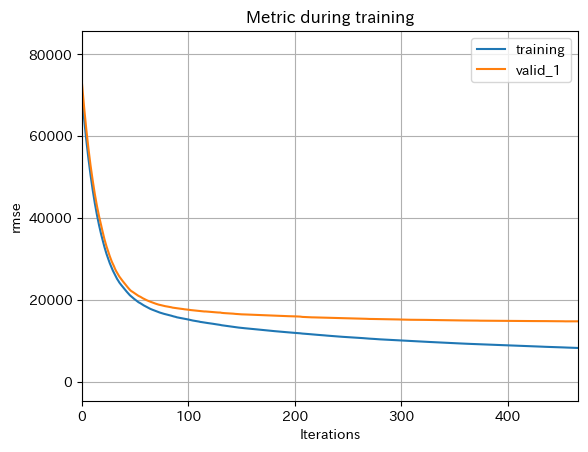

importance
面積               4.581954e+14
L                3.945724e+14
平均地価             2.249498e+14
最寄り駅             8.177204e+13
築年数              7.699682e+13
全体の階数            3.697096e+13
所在地              3.610375e+13
一部屋あたりの面積        3.307228e+13
契約期間             1.623493e+13
所在階              1.340793e+13
所要時間             9.932865e+12
定期借家             2.968482e+12
部屋数              1.175590e+12
建物構造             1.167010e+12
S                6.147373e+11
D                5.877477e+11
50m^2以上75m^2未満   4.222396e+11
75m^2以上100m^2未満  2.712766e+11
K                2.336520e+11
100m^2以上         7.084365e+10
バス・トイレ別          0.000000e+00

In [49]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GOSS = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    params = {
        'objective':'regression',
        'boosting_type':'goss',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': 4.430375245218262e-06,
        'max_bin': 502,
        'num_leaves': 97,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

チューニング後、16919で若干のスコア向上！

In [50]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GOSS_cv_result.csv',index=False)

### XGBoostで試してみる！

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'K','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

[20:12:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133052.64047	validation_1-rmse:131383.78847
[1]	validation_0-rmse:126791.57346	validation_1-rmse:125286.67480
[2]	validation_0-rmse:120788.97405	validation_1-rmse:119484.71791
[3]	validation_0-rmse:115092.60483	validation_1-rmse:113969.60842
[4]	validation_0-rmse:109692.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:86920.65503	validation_1-rmse:86864.67065
[10]	validation_0-rmse:82941.42561	validation_1-rmse:83050.68591
[11]	validation_0-rmse:79182.09381	validation_1-rmse:79463.99274
[12]	validation_0-rmse:75625.52778	validation_1-rmse:76067.80030
[13]	validation_0-rmse:72269.22904	validation_1-rmse:72863.20503
[14]	validation_0-rmse:69032.21311	validation_1-rmse:69767.92930
[15]	validation_0-rmse:65967.94146	validation_1-rmse:66857.65409
[16]	validation_0-rmse:63051.34233	validation_1-rmse:64082.66199
[17]	validation_0-rmse:60350.43188	validation_1-rmse:61544.44511
[18]	validation_0-rmse:57950.16767	validation_1-rmse:59272.40947
[19]	validation_0-rmse:55475.91295	validation_1-rmse:56930.52837
[20]	validation_0-rmse:53110.97354	validation_1-rmse:54738.48787
[21]	validation_0-rmse:50922.91324	validation_1-rmse:52735.41770
[22]	validation_0-rmse:48838.52125	validation_1-rmse:50812.57383
[23]	validation_0-rmse:46812.23308	validation_1-rmse:48938.20637
[24]	validation_0-rmse:449

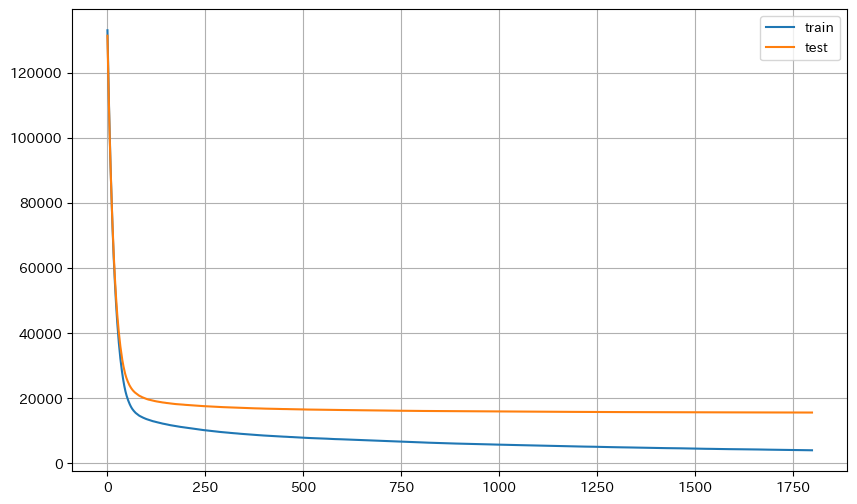

[20:12:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132800.89874	validation_1-rmse:132578.45863
[1]	validation_0-rmse:126560.94840	validation_1-rmse:126525.61611
[2]	validation_0-rmse:120581.25657	validation_1-rmse:120636.61625
[3]	validation_0-rmse:114904.38948	validation_1-rmse:115062.67163
[4]	validation_0-rmse:109513.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:95043.12421	validation_1-rmse:95747.31012
[8]	validation_0-rmse:90727.47939	validation_1-rmse:91635.64250
[9]	validation_0-rmse:86817.52311	validation_1-rmse:87932.23782
[10]	validation_0-rmse:82857.42143	validation_1-rmse:84064.59157
[11]	validation_0-rmse:79113.63000	validation_1-rmse:80310.13166
[12]	validation_0-rmse:75568.96021	validation_1-rmse:76879.69613
[13]	validation_0-rmse:72230.33318	validation_1-rmse:73679.42520
[14]	validation_0-rmse:69006.08305	validation_1-rmse:70578.61238
[15]	validation_0-rmse:65949.80239	validation_1-rmse:67657.51694
[16]	validation_0-rmse:63036.10846	validation_1-rmse:64822.18222
[17]	validation_0-rmse:60363.34600	validation_1-rmse:62286.08193
[18]	validation_0-rmse:57937.69960	validation_1-rmse:60084.13144
[19]	validation_0-rmse:55471.88524	validation_1-rmse:57699.37664
[20]	validation_0-rmse:53107.77007	validation_1-rmse:55451.18116
[21]	validation_0-rmse:50942.52631	validation_1-rmse:53426.21226
[22]	validation_0-rmse:48870

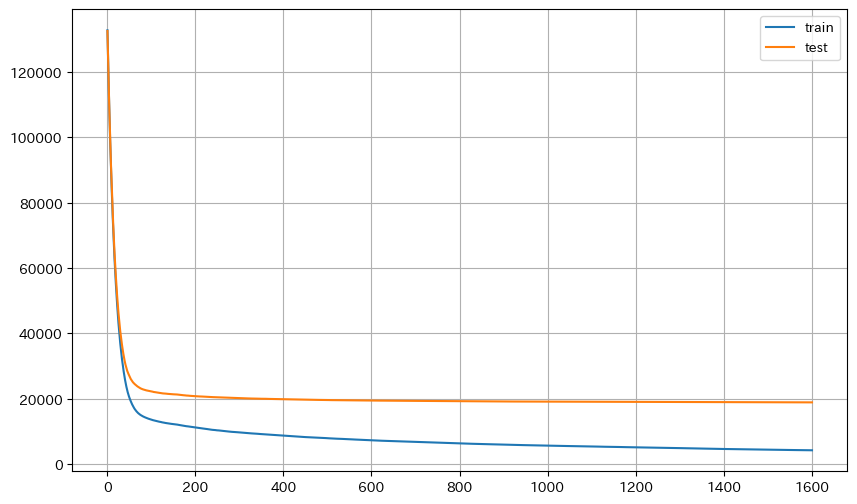

[20:13:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132369.78570	validation_1-rmse:134054.49207
[1]	validation_0-rmse:126155.01604	validation_1-rmse:127780.72882
[2]	validation_0-rmse:120201.24070	validation_1-rmse:121745.62878
[3]	validation_0-rmse:114553.50090	validation_1-rmse:116031.89411
[4]	validation_0-rmse:109183.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:90480.09713	validation_1-rmse:91490.96321
[9]	validation_0-rmse:86578.72817	validation_1-rmse:87692.57571
[10]	validation_0-rmse:82631.71570	validation_1-rmse:83675.52730
[11]	validation_0-rmse:78903.07943	validation_1-rmse:79922.22968
[12]	validation_0-rmse:75368.25664	validation_1-rmse:76317.24437
[13]	validation_0-rmse:72025.38769	validation_1-rmse:73003.07339
[14]	validation_0-rmse:68832.59712	validation_1-rmse:69820.69230
[15]	validation_0-rmse:65785.61312	validation_1-rmse:66785.78967
[16]	validation_0-rmse:62899.57180	validation_1-rmse:63910.05648
[17]	validation_0-rmse:60231.41815	validation_1-rmse:61283.76987
[18]	validation_0-rmse:57822.90384	validation_1-rmse:58868.24560
[19]	validation_0-rmse:55364.52305	validation_1-rmse:56438.89925
[20]	validation_0-rmse:53028.09418	validation_1-rmse:54109.85349
[21]	validation_0-rmse:50865.03191	validation_1-rmse:51964.66623
[22]	validation_0-rmse:48800.77860	validation_1-rmse:49920.95028
[23]	validation_0-rmse:4679

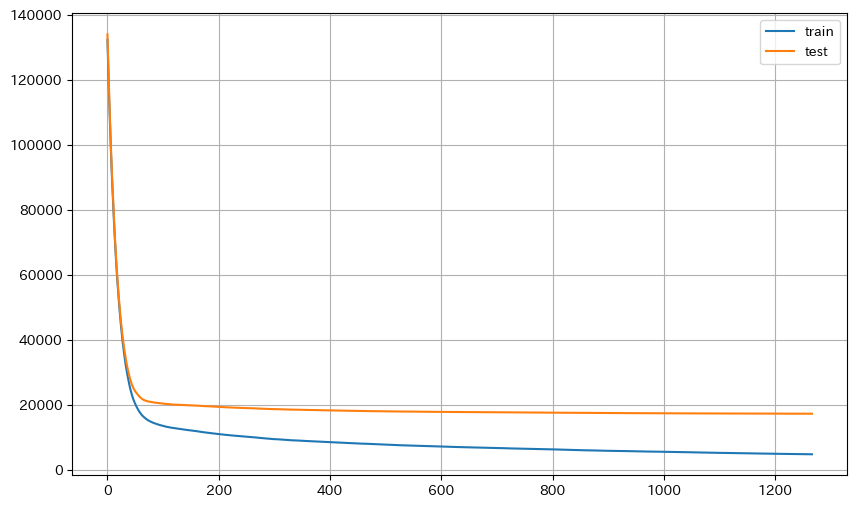

[20:13:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133049.35703	validation_1-rmse:131413.59781
[1]	validation_0-rmse:126783.55495	validation_1-rmse:125189.65121
[2]	validation_0-rmse:120788.52706	validation_1-rmse:119338.98225
[3]	validation_0-rmse:115092.50492	validation_1-rmse:113719.96423
[4]	validation_0-rmse:109686.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:99816.38219	validation_1-rmse:98746.75725
[7]	validation_0-rmse:95177.83359	validation_1-rmse:94216.25876
[8]	validation_0-rmse:90862.61063	validation_1-rmse:90030.50531
[9]	validation_0-rmse:86951.90148	validation_1-rmse:86165.26769
[10]	validation_0-rmse:82969.58297	validation_1-rmse:82288.09635
[11]	validation_0-rmse:79206.86450	validation_1-rmse:78681.60894
[12]	validation_0-rmse:75635.07341	validation_1-rmse:75275.75102
[13]	validation_0-rmse:72266.99206	validation_1-rmse:72004.84987
[14]	validation_0-rmse:69028.22302	validation_1-rmse:68876.47312
[15]	validation_0-rmse:65949.79387	validation_1-rmse:65949.41717
[16]	validation_0-rmse:63033.74516	validation_1-rmse:63183.37045
[17]	validation_0-rmse:60332.81843	validation_1-rmse:60611.79993
[18]	validation_0-rmse:57928.89860	validation_1-rmse:58296.65135
[19]	validation_0-rmse:55454.04191	validation_1-rmse:55996.68735
[20]	validation_0-rmse:53088.16034	validation_1-rmse:53801.74531
[21]	validation_0-rmse:50907.

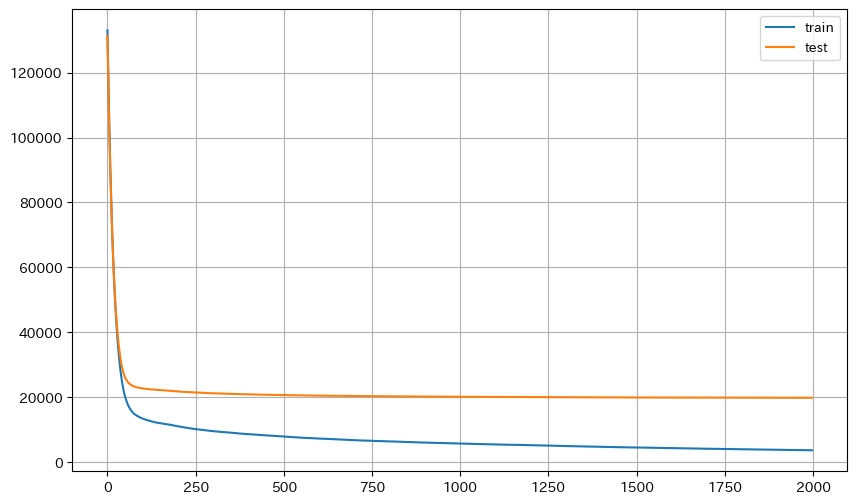

[20:14:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132326.23899	validation_1-rmse:134518.91843
[1]	validation_0-rmse:126117.56342	validation_1-rmse:128256.47218
[2]	validation_0-rmse:120168.22911	validation_1-rmse:122326.61533
[3]	validation_0-rmse:114520.62467	validation_1-rmse:116611.56468
[4]	validation_0-rmse:109164.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:94778.70025	validation_1-rmse:96783.82046
[8]	validation_0-rmse:90501.46436	validation_1-rmse:92606.38944
[9]	validation_0-rmse:86590.85278	validation_1-rmse:88789.23607
[10]	validation_0-rmse:82649.23427	validation_1-rmse:84769.45187
[11]	validation_0-rmse:78911.53037	validation_1-rmse:81129.59765
[12]	validation_0-rmse:75389.29308	validation_1-rmse:77600.14625
[13]	validation_0-rmse:72057.55731	validation_1-rmse:74182.49492
[14]	validation_0-rmse:68865.68838	validation_1-rmse:71085.58173
[15]	validation_0-rmse:65832.23664	validation_1-rmse:68005.03940
[16]	validation_0-rmse:62951.39054	validation_1-rmse:65070.91044
[17]	validation_0-rmse:60296.77024	validation_1-rmse:62457.01630
[18]	validation_0-rmse:57909.10316	validation_1-rmse:60200.59944
[19]	validation_0-rmse:55457.59517	validation_1-rmse:57792.76610
[20]	validation_0-rmse:53118.70948	validation_1-rmse:55438.10497
[21]	validation_0-rmse:50966.89297	validation_1-rmse:53333.31710
[22]	validation_0-rmse:48914

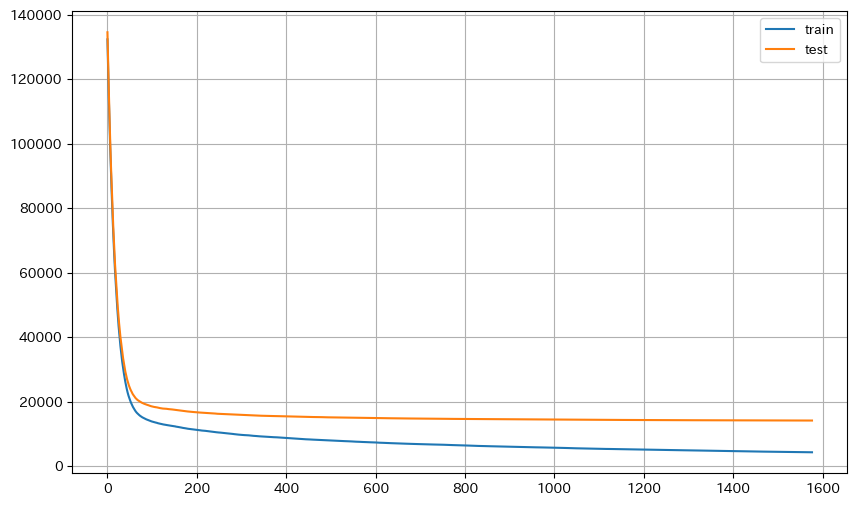

whole valid rmse: 17142.084843015182
Start predicting...


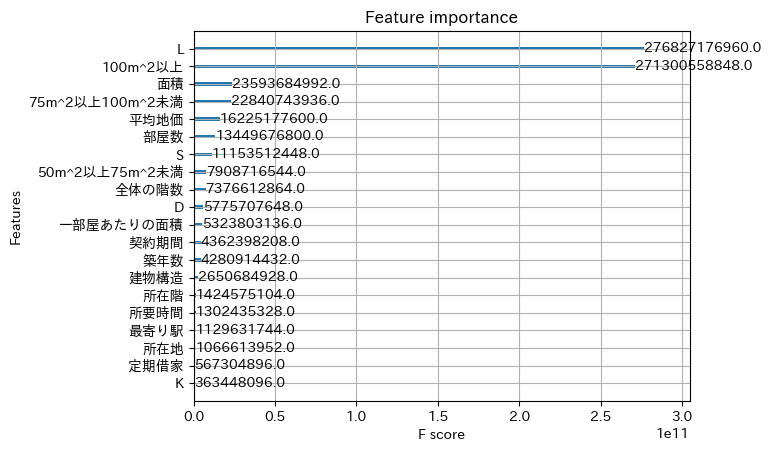

In [25]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=7,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=6.8594164113286965e-06,

                        sub_sample=0.16056047423047484,

                        colsample_bytree=0.6987351856651322,

                        min_child_weight=1.1103525577197584,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

17142でXGBoostに関してはスコアが悪くなったので、そのままにしておく

しかし「K」を抜いたらどうなるかだけ検証しておく

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

[20:17:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133235.91627	validation_1-rmse:131587.44894
[1]	validation_0-rmse:127081.17802	validation_1-rmse:125658.92753
[2]	validation_0-rmse:121277.84737	validation_1-rmse:120012.38498
[3]	validation_0-rmse:115548.56335	validation_1-rmse:114470.53691
[4]	validation_0-rmse:110183.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:83705.97010	validation_1-rmse:83958.73016
[11]	validation_0-rmse:80024.59056	validation_1-rmse:80453.70962
[12]	validation_0-rmse:76418.45636	validation_1-rmse:77003.81695
[13]	validation_0-rmse:73011.15949	validation_1-rmse:73756.44711
[14]	validation_0-rmse:69818.30162	validation_1-rmse:70744.32887
[15]	validation_0-rmse:66815.34457	validation_1-rmse:67944.80236
[16]	validation_0-rmse:63848.79847	validation_1-rmse:65161.89013
[17]	validation_0-rmse:61113.97471	validation_1-rmse:62571.73335
[18]	validation_0-rmse:58551.02474	validation_1-rmse:60170.77361
[19]	validation_0-rmse:56011.65699	validation_1-rmse:57808.38693
[20]	validation_0-rmse:53608.82376	validation_1-rmse:55567.57711
[21]	validation_0-rmse:51368.79102	validation_1-rmse:53474.38415
[22]	validation_0-rmse:49215.98783	validation_1-rmse:51494.81602
[23]	validation_0-rmse:47175.20645	validation_1-rmse:49628.77059
[24]	validation_0-rmse:45412.34023	validation_1-rmse:48030.55864
[25]	validation_0-rmse:43

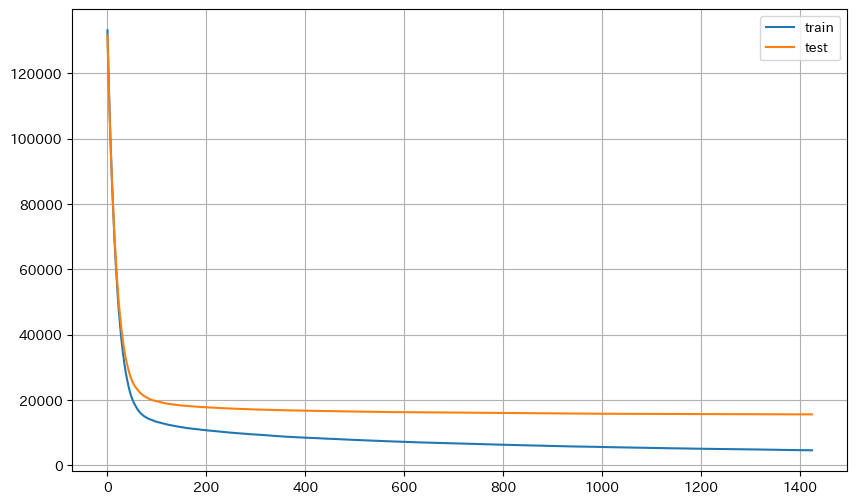

[20:17:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132998.44147	validation_1-rmse:132662.33748
[1]	validation_0-rmse:126856.97883	validation_1-rmse:126693.36582
[2]	validation_0-rmse:121075.40508	validation_1-rmse:121108.81454
[3]	validation_0-rmse:115371.59275	validation_1-rmse:115518.12992
[4]	validation_0-rmse:110025.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:91212.40145	validation_1-rmse:92066.86364
[9]	validation_0-rmse:87222.25408	validation_1-rmse:88194.46349
[10]	validation_0-rmse:83597.32791	validation_1-rmse:84733.38711
[11]	validation_0-rmse:79935.81743	validation_1-rmse:81103.18467
[12]	validation_0-rmse:76346.31469	validation_1-rmse:77600.80297
[13]	validation_0-rmse:72951.75890	validation_1-rmse:74390.43027
[14]	validation_0-rmse:69780.31047	validation_1-rmse:71468.53027
[15]	validation_0-rmse:66798.66553	validation_1-rmse:68633.10842
[16]	validation_0-rmse:63841.65187	validation_1-rmse:65738.36511
[17]	validation_0-rmse:61134.52659	validation_1-rmse:63199.51611
[18]	validation_0-rmse:58578.70883	validation_1-rmse:60767.33496
[19]	validation_0-rmse:56042.65087	validation_1-rmse:58326.95375
[20]	validation_0-rmse:53643.66355	validation_1-rmse:56003.58970
[21]	validation_0-rmse:51404.77512	validation_1-rmse:53860.43544
[22]	validation_0-rmse:49250.07805	validation_1-rmse:51834.79983
[23]	validation_0-rmse:4720

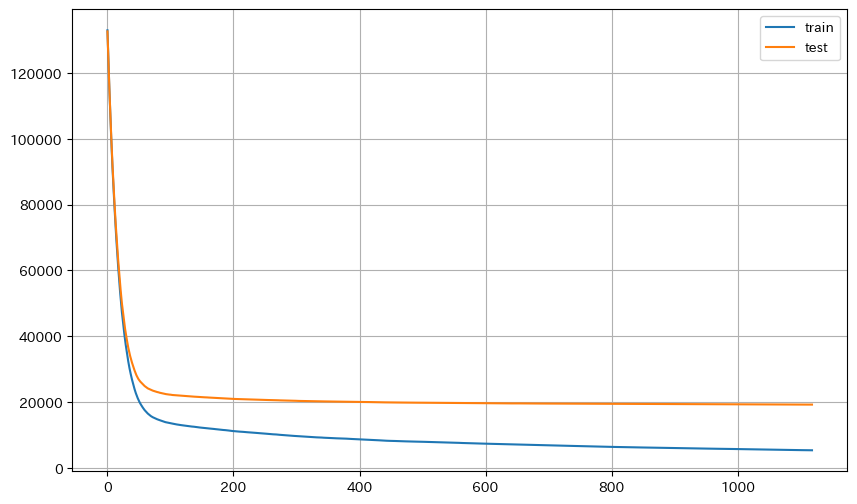

[20:18:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132547.50621	validation_1-rmse:134244.42771
[1]	validation_0-rmse:126441.03649	validation_1-rmse:128034.13648
[2]	validation_0-rmse:120659.98433	validation_1-rmse:122319.15318
[3]	validation_0-rmse:114993.25265	validation_1-rmse:116582.33081
[4]	validation_0-rmse:109662.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:90937.57819	validation_1-rmse:92318.45413
[9]	validation_0-rmse:86991.21058	validation_1-rmse:88393.36911
[10]	validation_0-rmse:83358.26668	validation_1-rmse:84807.22710
[11]	validation_0-rmse:79705.25422	validation_1-rmse:81121.23288
[12]	validation_0-rmse:76132.18115	validation_1-rmse:77457.29241
[13]	validation_0-rmse:72742.42837	validation_1-rmse:74092.38827
[14]	validation_0-rmse:69593.53443	validation_1-rmse:70956.73339
[15]	validation_0-rmse:66646.53859	validation_1-rmse:68043.68639
[16]	validation_0-rmse:63695.83522	validation_1-rmse:65070.35389
[17]	validation_0-rmse:60996.26947	validation_1-rmse:62359.13498
[18]	validation_0-rmse:58439.33191	validation_1-rmse:59832.26892
[19]	validation_0-rmse:55918.52834	validation_1-rmse:57302.17949
[20]	validation_0-rmse:53537.92273	validation_1-rmse:54922.80964
[21]	validation_0-rmse:51308.37928	validation_1-rmse:52721.81682
[22]	validation_0-rmse:49169.27867	validation_1-rmse:50622.20354
[23]	validation_0-rmse:4714

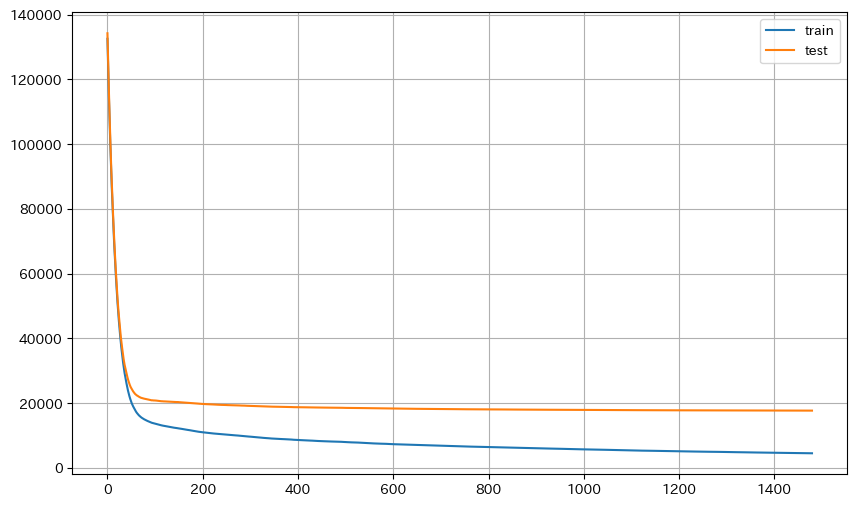

[20:18:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133229.13002	validation_1-rmse:131668.13741
[1]	validation_0-rmse:127088.34286	validation_1-rmse:125595.23424
[2]	validation_0-rmse:121279.26931	validation_1-rmse:119906.32981
[3]	validation_0-rmse:115557.93096	validation_1-rmse:114286.92339
[4]	validation_0-rmse:110191.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:87368.98794	validation_1-rmse:86616.03030
[10]	validation_0-rmse:83758.54756	validation_1-rmse:83007.32429
[11]	validation_0-rmse:80069.03113	validation_1-rmse:79433.01829
[12]	validation_0-rmse:76465.50476	validation_1-rmse:75965.52155
[13]	validation_0-rmse:73048.62885	validation_1-rmse:72660.60326
[14]	validation_0-rmse:69865.79005	validation_1-rmse:69609.38495
[15]	validation_0-rmse:66873.05982	validation_1-rmse:66768.84076
[16]	validation_0-rmse:63894.56217	validation_1-rmse:63896.46809
[17]	validation_0-rmse:61173.93987	validation_1-rmse:61279.97675
[18]	validation_0-rmse:58603.89630	validation_1-rmse:58829.80402
[19]	validation_0-rmse:56060.02037	validation_1-rmse:56452.80242
[20]	validation_0-rmse:53652.53733	validation_1-rmse:54166.06547
[21]	validation_0-rmse:51396.78861	validation_1-rmse:52081.25083
[22]	validation_0-rmse:49231.61229	validation_1-rmse:50076.52700
[23]	validation_0-rmse:47184.97642	validation_1-rmse:48204.42888
[24]	validation_0-rmse:454

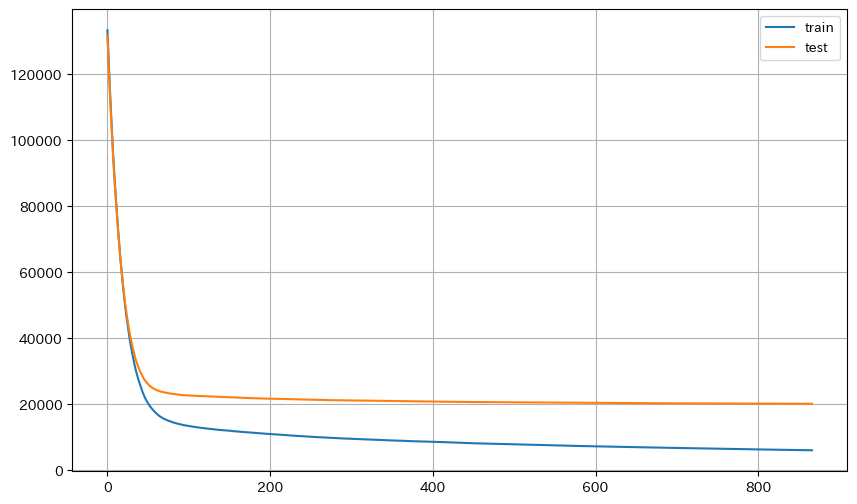

[20:18:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132501.09440	validation_1-rmse:134724.88716
[1]	validation_0-rmse:126406.87285	validation_1-rmse:128704.28573
[2]	validation_0-rmse:120642.77143	validation_1-rmse:123031.41550
[3]	validation_0-rmse:114971.85494	validation_1-rmse:117324.43232
[4]	validation_0-rmse:109650.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:90948.45474	validation_1-rmse:93452.76808
[9]	validation_0-rmse:86982.39084	validation_1-rmse:89571.28711
[10]	validation_0-rmse:83366.88135	validation_1-rmse:86078.46798
[11]	validation_0-rmse:79734.40931	validation_1-rmse:82396.82423
[12]	validation_0-rmse:76166.64828	validation_1-rmse:78813.83134
[13]	validation_0-rmse:72786.39107	validation_1-rmse:75411.25666
[14]	validation_0-rmse:69643.22228	validation_1-rmse:72241.68455
[15]	validation_0-rmse:66684.22361	validation_1-rmse:69234.33644
[16]	validation_0-rmse:63744.14776	validation_1-rmse:66304.06352
[17]	validation_0-rmse:61058.13208	validation_1-rmse:63733.32420
[18]	validation_0-rmse:58520.60186	validation_1-rmse:61188.58164
[19]	validation_0-rmse:56009.74893	validation_1-rmse:58643.78397
[20]	validation_0-rmse:53632.71249	validation_1-rmse:56221.77318
[21]	validation_0-rmse:51411.31968	validation_1-rmse:54062.46031
[22]	validation_0-rmse:49275.91402	validation_1-rmse:52003.98961
[23]	validation_0-rmse:4725

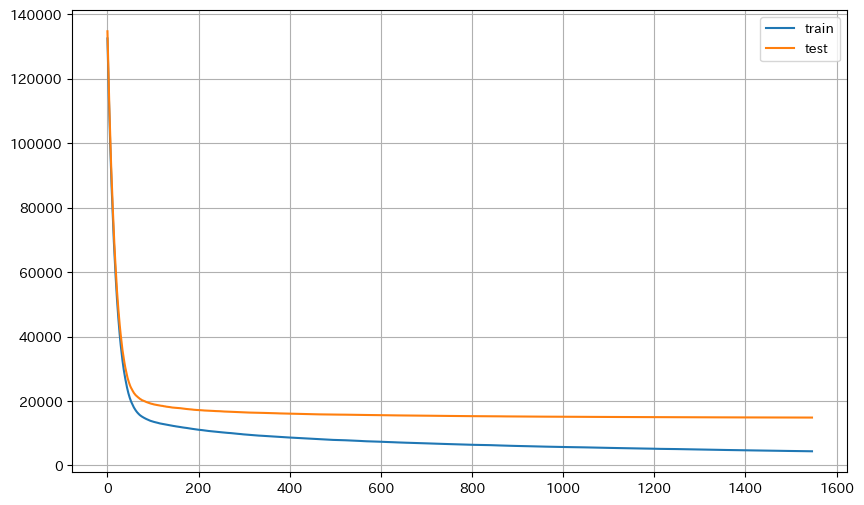

whole valid rmse: 17496.39016642703
Start predicting...


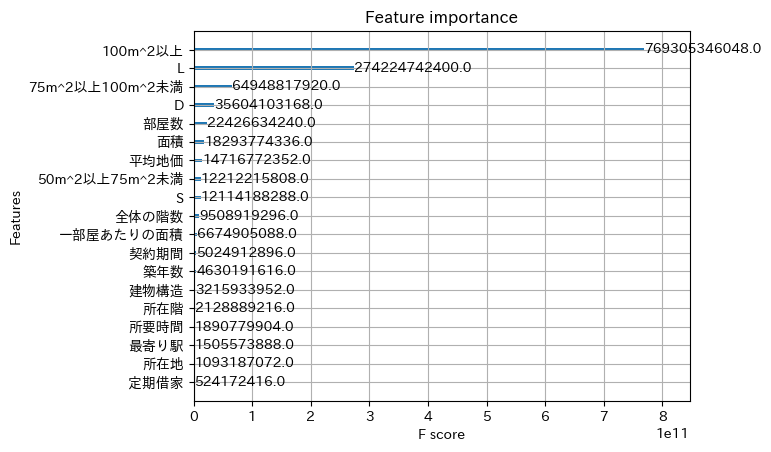

In [27]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=7,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=6.8594164113286965e-06,

                        sub_sample=0.16056047423047484,

                        colsample_bytree=0.6987351856651322,

                        min_child_weight=1.1103525577197584,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

17496でさらなる悪化

念のため、XGBoostの「一部屋あたりの部屋数」を加えたチューニングも行ってみる

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

def objective(trial):
    
    xgb_reg = xgboost.XGBRegressor(
    #目的関数の指定 初期値も二乗誤差です
                       objective='reg:linear',
                       #学習のラウンド数 early_stoppingを利用するので多めに指定
                       n_estimators=50000,
                       #boosterに何を用いるか 初期値もgbtreeです
                       booster='gbtree',
                       #学習率
                       learning_rate=0.05,
                       #木の最大深さ
                       max_depth=trial.suggest_int('max_depth', 1, 10),
                       #シード値
                       random_state=0,
                        #正則化
                       reg_alfa=trial.suggest_float('reg_alfa', 0.0000001, 0.0001, log=True),

                       sub_sample=trial.suggest_float('sub_sample', 0.01, 0.9, log=True),

                       colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 0.9, log=True),

                       min_child_weight=trial.suggest_float('min_child_weight', 0.01, 10.0, log=True),
    )

    xgb_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10)
    y_pred_valid = xgb_reg.predict(X_valid)

    loss = mean_squared_error(y_valid, y_pred_valid, squared=False)
    return loss

In [32]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

[I 2022-09-17 20:28:22,149] A new study created in memory with name: no-name-52206bd4-ed10-4c31-acb8-1e09faac34b3


[20:28:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:28:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132758.82492
[1]	validation_0-rmse:127443.33435
[2]	validation_0-rmse:122761.07866
[3]	validation_0-rmse:118396.92128
[4]	validation_0-rmse:113889.42082
[5]	validation_0-rmse:110229.74453
[6]	validation_0-rmse:106321.27886
[7]	validation_0-rmse:102346.98730
[8]	validation_0-rmse:98767.49087
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:57443.34799
[31]	validation_0-rmse:56563.62211
[32]	validation_0-rmse:55208.63665
[33]	validation_0-rmse:54025.05038
[34]	validation_0-rmse:53197.86586
[35]	validation_0-rmse:52317.68578
[36]	validation_0-rmse:51811.12336
[37]	validation_0-rmse:50935.66952
[38]	validation_0-rmse:50245.88038
[39]	validation_0-rmse:49774.15941
[40]	validation_0-rmse:49097.17854
[41]	validation_0-rmse:48629.93341
[42]	validation_0-rmse:48088.48748
[43]	validation_0-rmse:47373.01492
[44]	validation_0-rmse:47051.30772
[45]	validation_0-rmse:46707.21153
[46]	validation_0-rmse:46348.49211
[47]	validation_0-rmse:46070.96410
[48]	validation_0-rmse:45863.05267
[49]	validation_0-rmse:45576.20089
[50]	validation_0-rmse:45434.49060
[51]	validation_0-rmse:45035.23644
[52]	validation_0-rmse:44868.85807
[53]	validation_0-rmse:44670.31339
[54]	validation_0-rmse:44236.23944
[55]	validation_0-rmse:43938.64590
[56]	validation_0-rmse:43646.78716
[57]	validation_0-rmse:43454.24175
[58]	validation_0-rm

[I 2022-09-17 20:28:30,596] Trial 0 finished with value: 23024.888696246733 and parameters: {'max_depth': 6, 'reg_alfa': 1.3981961408994034e-05, 'sub_sample': 0.1506419097075089, 'colsample_bytree': 0.11610044354231804, 'min_child_weight': 0.18662266976517972}. Best is trial 0 with value: 23024.888696246733.


[20:28:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:28:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:131998.36874
[1]	validation_0-rmse:126036.62813
[2]	validation_0-rmse:120314.00762
[3]	validation_0-rmse:114780.86637
[4]	validation_0-rmse:109581.91685
[5]	validation_0-rmse:104720.81022
[6]	validation_0-rmse:99992.23982
[7]	validation_0-rmse:95524.98119
[8]	validation_0-rmse:91367.52746
[9]	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:80379.17236
[12]	validation_0-rmse:76960.19895
[13]	validation_0-rmse:73704.34973
[14]	validation_0-rmse:70612.83503
[15]	validation_0-rmse:67841.75414
[16]	validation_0-rmse:65063.34806
[17]	validation_0-rmse:62549.09332
[18]	validation_0-rmse:60160.51236
[19]	validation_0-rmse:57799.25709
[20]	validation_0-rmse:55578.53881
[21]	validation_0-rmse:53501.13640
[22]	validation_0-rmse:51515.17079
[23]	validation_0-rmse:49686.12088
[24]	validation_0-rmse:47957.68169
[25]	validation_0-rmse:46344.45452
[26]	validation_0-rmse:44800.17898
[27]	validation_0-rmse:43380.34573
[28]	validation_0-rmse:41971.75311
[29]	validation_0-rmse:40718.03679
[30]	validation_0-rmse:39601.48652
[31]	validation_0-rmse:38512.21788
[32]	validation_0-rmse:37441.29798
[33]	validation_0-rmse:36434.58166
[34]	validation_0-rmse:35485.44780
[35]	validation_0-rmse:34599.16437
[36]	validation_0-rmse:33757.63960
[37]	validation_0-rmse:33025.05870
[38]	validation_0-rmse:32237.96713
[39]	validation_0-rm

[I 2022-09-17 20:29:03,609] Trial 1 finished with value: 17500.461161731764 and parameters: {'max_depth': 7, 'reg_alfa': 2.054762512591133e-06, 'sub_sample': 0.5530198332197337, 'colsample_bytree': 0.7642417009494488, 'min_child_weight': 0.14135935551752302}. Best is trial 1 with value: 17500.461161731764.


[20:29:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:29:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132124.95887
[1]	validation_0-rmse:126238.19235
[2]	validation_0-rmse:120661.90272
[3]	validation_0-rmse:115153.90107
[4]	validation_0-rmse:109930.84939
[5]	validation_0-rmse:105065.57685
[6]	validation_0-rmse:100365.88584
[7]	validation_0-rmse:95881.73675
[8]	validation_0-rmse:91846.61102
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:80799.74200
[12]	validation_0-rmse:77360.52123
[13]	validation_0-rmse:74069.41496
[14]	validation_0-rmse:71051.96691
[15]	validation_0-rmse:68230.97198
[16]	validation_0-rmse:65487.92711
[17]	validation_0-rmse:62916.00292
[18]	validation_0-rmse:60553.65324
[19]	validation_0-rmse:58181.50323
[20]	validation_0-rmse:55942.29324
[21]	validation_0-rmse:53905.07458
[22]	validation_0-rmse:51892.25816
[23]	validation_0-rmse:50004.29687
[24]	validation_0-rmse:48397.31193
[25]	validation_0-rmse:46787.67225
[26]	validation_0-rmse:45280.35546
[27]	validation_0-rmse:43800.52579
[28]	validation_0-rmse:42370.11321
[29]	validation_0-rmse:41131.61691
[30]	validation_0-rmse:40070.60104
[31]	validation_0-rmse:38946.11556
[32]	validation_0-rmse:37808.28527
[33]	validation_0-rmse:36796.95131
[34]	validation_0-rmse:35790.97477
[35]	validation_0-rmse:34912.53320
[36]	validation_0-rmse:34072.15032
[37]	validation_0-rmse:33329.22577
[38]	validation_0-rmse:32637.26012
[39]	validation_0-rm

[I 2022-09-17 20:29:34,366] Trial 2 finished with value: 17646.162122959122 and parameters: {'max_depth': 8, 'reg_alfa': 3.860866271460544e-06, 'sub_sample': 0.12885368066372738, 'colsample_bytree': 0.6439324290786468, 'min_child_weight': 0.0163345876110695}. Best is trial 1 with value: 17500.461161731764.


[20:29:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:29:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133009.04314
[1]	validation_0-rmse:127713.65323
[2]	validation_0-rmse:122947.26393
[3]	validation_0-rmse:118419.52856
[4]	validation_0-rmse:114007.94735
[5]	validation_0-rmse:110036.74459
[6]	validation_0-rmse:106131.77525
[7]	validation_0-rmse:102481.66065
[8]	validation_0-rmse:99073.79626
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-rmse:49581.40208
[60]	validation_0-rmse:49440.91152
[61]	validation_0-rmse:49233.38131
[62]	validation_0-rmse:49040.79371
[63]	validation_0-rmse:48844.13973
[64]	validation_0-rmse:48681.00952
[65]	validation_0-rmse:48501.28434
[66]	validation_0-rmse:48318.57813
[67]	validation_0-rmse:48161.68075
[68]	validation_0-rmse:47987.16151
[69]	validation_0-rmse:47824.67791
[70]	validation_0-rmse:47667.29675
[71]	validation_0-rmse:47440.90272
[72]	validation_0-rmse:47315.35417
[73]	validation_0-rmse:47185.65172
[74]	validation_0-rmse:47048.39920
[75]	validation_0-rmse:46903.04673
[76]	validation_0-rmse:46709.51267
[77]	validation_0-rmse:46569.16865
[78]	validation_0-rmse:46460.91503
[79]	validation_0-rmse:46360.08549
[80]	validation_0-rmse:46225.23374
[81]	validation_0-rmse:46119.42784
[82]	validation_0-rmse:46034.06916
[83]	validation_0-rmse:45917.80859
[84]	validation_0-rmse:45779.40763
[85]	validation_0-rmse:45635.22128
[86]	validation_0-rmse:45512.98788
[87]	validation_0-rm

[I 2022-09-17 20:29:37,842] Trial 3 finished with value: 34795.64024584016 and parameters: {'max_depth': 1, 'reg_alfa': 1.149887074711944e-07, 'sub_sample': 0.4237806242498698, 'colsample_bytree': 0.33167061931461184, 'min_child_weight': 4.074144654166231}. Best is trial 1 with value: 17500.461161731764.


[20:29:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:29:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132579.30879
[1]	validation_0-rmse:126815.09036
[2]	validation_0-rmse:121357.57946
[3]	validation_0-rmse:116101.49650
[4]	validation_0-rmse:111004.20263
[5]	validation_0-rmse:106688.38684
[6]	validation_0-rmse:102108.47204
[7]	validation_0-rmse:97986.52551
[8]	validation_0-rmse:94106.41426
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:86935.46256
[11]	validation_0-rmse:83565.24337
[12]	validation_0-rmse:80404.39985
[13]	validation_0-rmse:77178.65469
[14]	validation_0-rmse:74129.40615
[15]	validation_0-rmse:71303.12139
[16]	validation_0-rmse:68736.98790
[17]	validation_0-rmse:66111.49992
[18]	validation_0-rmse:63987.23984
[19]	validation_0-rmse:62014.56110
[20]	validation_0-rmse:60094.26476
[21]	validation_0-rmse:57947.22026
[22]	validation_0-rmse:55878.64622
[23]	validation_0-rmse:53961.10921
[24]	validation_0-rmse:52411.15277
[25]	validation_0-rmse:50559.94369
[26]	validation_0-rmse:49149.43286
[27]	validation_0-rmse:47839.98533
[28]	validation_0-rmse:46365.02697
[29]	validation_0-rmse:45126.84151
[30]	validation_0-rmse:43995.43126
[31]	validation_0-rmse:42756.58606
[32]	validation_0-rmse:41688.30929
[33]	validation_0-rmse:40686.11060
[34]	validation_0-rmse:39614.52762
[35]	validation_0-rmse:38740.41022
[36]	validation_0-rmse:37825.13043
[37]	validation_0-rmse:37058.98733
[38]	validation_0-rm

[I 2022-09-17 20:29:58,084] Trial 4 finished with value: 19280.354318524125 and parameters: {'max_depth': 10, 'reg_alfa': 2.4973286104060585e-05, 'sub_sample': 0.07977055009538551, 'colsample_bytree': 0.33523032350143844, 'min_child_weight': 0.022637229697395487}. Best is trial 1 with value: 17500.461161731764.


[20:29:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:29:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132760.86080
[1]	validation_0-rmse:127445.27538
[2]	validation_0-rmse:122762.88903
[3]	validation_0-rmse:118356.79246
[4]	validation_0-rmse:113847.37772
[5]	validation_0-rmse:110185.56079
[6]	validation_0-rmse:106276.83123
[7]	validation_0-rmse:102300.54363
[8]	validation_0-rmse:98710.84566
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-rmse:60948.62516
[28]	validation_0-rmse:59155.61144
[29]	validation_0-rmse:57820.33421
[30]	validation_0-rmse:57086.56538
[31]	validation_0-rmse:56202.57386
[32]	validation_0-rmse:54880.50874
[33]	validation_0-rmse:53676.33318
[34]	validation_0-rmse:52830.10468
[35]	validation_0-rmse:51952.94700
[36]	validation_0-rmse:51441.38293
[37]	validation_0-rmse:50544.86965
[38]	validation_0-rmse:49801.21297
[39]	validation_0-rmse:49326.27438
[40]	validation_0-rmse:48626.65066
[41]	validation_0-rmse:48146.38740
[42]	validation_0-rmse:47596.45952
[43]	validation_0-rmse:46846.02398
[44]	validation_0-rmse:46519.62110
[45]	validation_0-rmse:46172.97749
[46]	validation_0-rmse:45812.18031
[47]	validation_0-rmse:45531.46467
[48]	validation_0-rmse:45284.01011
[49]	validation_0-rmse:44998.36823
[50]	validation_0-rmse:44855.07503
[51]	validation_0-rmse:44432.56204
[52]	validation_0-rmse:44265.23219
[53]	validation_0-rmse:44066.72638
[54]	validation_0-rmse:43588.18891
[55]	validation_0-rm

[I 2022-09-17 20:30:07,820] Trial 5 finished with value: 22790.98951569729 and parameters: {'max_depth': 7, 'reg_alfa': 2.691905824926068e-07, 'sub_sample': 0.7016364702114198, 'colsample_bytree': 0.10466902382950716, 'min_child_weight': 0.17538232373118048}. Best is trial 1 with value: 17500.461161731764.


[20:30:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132808.55199
[1]	validation_0-rmse:127494.05601
[2]	validation_0-rmse:122809.72287
[3]	validation_0-rmse:118528.93246
[4]	validation_0-rmse:114021.06713
[5]	validation_0-rmse:110367.83034
[6]	validation_0-rmse:106500.66726
[7]	validation_0-rmse:102553.71951
[8]	validation_0-rmse:98991.62137
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:50739.48369
[41]	validation_0-rmse:50391.02164
[42]	validation_0-rmse:49895.85862
[43]	validation_0-rmse:49296.44213
[44]	validation_0-rmse:48974.16968
[45]	validation_0-rmse:48628.30852
[46]	validation_0-rmse:48276.85770
[47]	validation_0-rmse:48009.15902
[48]	validation_0-rmse:47814.16076
[49]	validation_0-rmse:47513.36700
[50]	validation_0-rmse:47365.67323
[51]	validation_0-rmse:47048.96172
[52]	validation_0-rmse:46883.69871
[53]	validation_0-rmse:46683.29686
[54]	validation_0-rmse:46323.35727
[55]	validation_0-rmse:46081.09782
[56]	validation_0-rmse:45871.17081
[57]	validation_0-rmse:45679.44020
[58]	validation_0-rmse:45607.81026
[59]	validation_0-rmse:45537.89106
[60]	validation_0-rmse:45483.65225
[61]	validation_0-rmse:45382.32962
[62]	validation_0-rmse:45236.41522
[63]	validation_0-rmse:44865.65759
[64]	validation_0-rmse:44612.26641
[65]	validation_0-rmse:44508.79118
[66]	validation_0-rmse:44341.94662
[67]	validation_0-rmse:44178.37400
[68]	validation_0-rm

[I 2022-09-17 20:30:14,453] Trial 6 finished with value: 24960.10592062374 and parameters: {'max_depth': 3, 'reg_alfa': 2.1023308743480097e-05, 'sub_sample': 0.07788043523534342, 'colsample_bytree': 0.12907965224261325, 'min_child_weight': 0.011385953381489415}. Best is trial 1 with value: 17500.461161731764.


[20:30:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132116.30835
[1]	validation_0-rmse:126185.10488
[2]	validation_0-rmse:120587.92320
[3]	validation_0-rmse:115092.06313
[4]	validation_0-rmse:109893.75817
[5]	validation_0-rmse:105062.48019
[6]	validation_0-rmse:100361.83327
[7]	validation_0-rmse:95865.44730
[8]	validation_0-rmse:91715.10183
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:84321.13269
[11]	validation_0-rmse:80761.41700
[12]	validation_0-rmse:77329.76205
[13]	validation_0-rmse:74066.06378
[14]	validation_0-rmse:71108.45333
[15]	validation_0-rmse:68312.87276
[16]	validation_0-rmse:65521.00711
[17]	validation_0-rmse:62995.89651
[18]	validation_0-rmse:60603.37307
[19]	validation_0-rmse:58222.46678
[20]	validation_0-rmse:55985.20004
[21]	validation_0-rmse:53927.37762
[22]	validation_0-rmse:51928.79445
[23]	validation_0-rmse:50030.70383
[24]	validation_0-rmse:48440.37564
[25]	validation_0-rmse:46789.55544
[26]	validation_0-rmse:45261.99536
[27]	validation_0-rmse:43776.44930
[28]	validation_0-rmse:42354.14841
[29]	validation_0-rmse:41100.61221
[30]	validation_0-rmse:39990.78166
[31]	validation_0-rmse:38883.75598
[32]	validation_0-rmse:37760.06202
[33]	validation_0-rmse:36713.98076
[34]	validation_0-rmse:35748.75820
[35]	validation_0-rmse:34890.28948
[36]	validation_0-rmse:34076.46880
[37]	validation_0-rmse:33302.06502
[38]	validation_0-rm

[I 2022-09-17 20:30:38,209] Trial 7 finished with value: 17311.424587307483 and parameters: {'max_depth': 7, 'reg_alfa': 6.8594164113286965e-06, 'sub_sample': 0.16056047423047484, 'colsample_bytree': 0.6987351856651322, 'min_child_weight': 1.1103525577197584}. Best is trial 7 with value: 17311.424587307483.


[20:30:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132798.40396
[1]	validation_0-rmse:127885.40143
[2]	validation_0-rmse:123399.12243
[3]	validation_0-rmse:119216.06900
[4]	validation_0-rmse:114733.60745
[5]	validation_0-rmse:111105.62833
[6]	validation_0-rmse:107399.81614
[7]	validation_0-rmse:103764.01598
[8]	validation_0-rmse:100691.13315
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-rmse:53907.45189
[45]	validation_0-rmse:53554.55917
[46]	validation_0-rmse:53289.39889
[47]	validation_0-rmse:52987.39030
[48]	validation_0-rmse:52845.47579
[49]	validation_0-rmse:52709.48855
[50]	validation_0-rmse:52587.28121
[51]	validation_0-rmse:52208.66981
[52]	validation_0-rmse:52100.65499
[53]	validation_0-rmse:51970.99942
[54]	validation_0-rmse:51651.11666
[55]	validation_0-rmse:51465.21452
[56]	validation_0-rmse:51258.65141
[57]	validation_0-rmse:51090.71595
[58]	validation_0-rmse:51017.05692
[59]	validation_0-rmse:50955.37479
[60]	validation_0-rmse:50930.92303
[61]	validation_0-rmse:50787.43504
[62]	validation_0-rmse:50588.60690
[63]	validation_0-rmse:50511.91696
[64]	validation_0-rmse:50119.48867
[65]	validation_0-rmse:49959.99608
[66]	validation_0-rmse:49895.16213
[67]	validation_0-rmse:49752.41577
[68]	validation_0-rmse:49613.54569
[69]	validation_0-rmse:49604.30078
[70]	validation_0-rmse:49478.70996
[71]	validation_0-rmse:49351.78326
[72]	validation_0-rm

[I 2022-09-17 20:30:41,546] Trial 8 finished with value: 34721.09650971372 and parameters: {'max_depth': 4, 'reg_alfa': 2.046896396312667e-06, 'sub_sample': 0.2308556664671557, 'colsample_bytree': 0.013112792135451369, 'min_child_weight': 1.0006913513545577}. Best is trial 7 with value: 17311.424587307483.


[20:30:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132796.96330
[1]	validation_0-rmse:127883.78832
[2]	validation_0-rmse:123397.42154
[3]	validation_0-rmse:119168.98947
[4]	validation_0-rmse:114684.91604
[5]	validation_0-rmse:111054.57088
[6]	validation_0-rmse:107346.53715
[7]	validation_0-rmse:103707.14912
[8]	validation_0-rmse:100622.80752
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-rmse:56761.05732
[38]	validation_0-rmse:55900.96208
[39]	validation_0-rmse:55633.73341
[40]	validation_0-rmse:54874.08521
[41]	validation_0-rmse:54581.66392
[42]	validation_0-rmse:53908.66436
[43]	validation_0-rmse:53556.04544
[44]	validation_0-rmse:53196.05984
[45]	validation_0-rmse:52836.73042
[46]	validation_0-rmse:52566.79061
[47]	validation_0-rmse:52259.15199
[48]	validation_0-rmse:52116.47057
[49]	validation_0-rmse:51979.02288
[50]	validation_0-rmse:51855.42158
[51]	validation_0-rmse:51472.23029
[52]	validation_0-rmse:51364.03687
[53]	validation_0-rmse:51234.17788
[54]	validation_0-rmse:50902.18537
[55]	validation_0-rmse:50611.91371
[56]	validation_0-rmse:50384.68318
[57]	validation_0-rmse:50213.11102
[58]	validation_0-rmse:50140.64029
[59]	validation_0-rmse:50077.20666
[60]	validation_0-rmse:50051.70706
[61]	validation_0-rmse:49905.21981
[62]	validation_0-rmse:49709.91392
[63]	validation_0-rmse:49599.99481
[64]	validation_0-rmse:49174.33545
[65]	validation_0-rm

[I 2022-09-17 20:30:43,316] Trial 9 finished with value: 35630.666280361846 and parameters: {'max_depth': 7, 'reg_alfa': 4.2770830499620656e-07, 'sub_sample': 0.017862952832355016, 'colsample_bytree': 0.041345047199681004, 'min_child_weight': 0.1233480570086002}. Best is trial 7 with value: 17311.424587307483.


[20:30:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132796.96330
[1]	validation_0-rmse:127883.78832
[2]	validation_0-rmse:123397.42154
[3]	validation_0-rmse:119175.66310
[4]	validation_0-rmse:114691.84610
[5]	validation_0-rmse:111061.87498
[6]	validation_0-rmse:107353.94401
[7]	validation_0-rmse:103714.50894
[8]	validation_0-rmse:100631.01837
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:58064.64449
[36]	validation_0-rmse:57783.49853
[37]	validation_0-rmse:56832.85768
[38]	validation_0-rmse:55973.71807
[39]	validation_0-rmse:55707.85314
[40]	validation_0-rmse:54950.94094
[41]	validation_0-rmse:54684.52368
[42]	validation_0-rmse:54023.37074
[43]	validation_0-rmse:53672.39684
[44]	validation_0-rmse:53312.05111
[45]	validation_0-rmse:52954.78039
[46]	validation_0-rmse:52685.97231
[47]	validation_0-rmse:52380.13303
[48]	validation_0-rmse:52236.93156
[49]	validation_0-rmse:52100.08121
[50]	validation_0-rmse:51977.05666
[51]	validation_0-rmse:51595.08968
[52]	validation_0-rmse:51486.34583
[53]	validation_0-rmse:51357.32696
[54]	validation_0-rmse:51026.52484
[55]	validation_0-rmse:50776.68246
[56]	validation_0-rmse:50550.76326
[57]	validation_0-rmse:50380.13472
[58]	validation_0-rmse:50306.65589
[59]	validation_0-rmse:50244.03893
[60]	validation_0-rmse:50218.82769
[61]	validation_0-rmse:50073.10760
[62]	validation_0-rmse:49875.31333
[63]	validation_0-rm

[I 2022-09-17 20:30:44,908] Trial 10 finished with value: 36059.84246490264 and parameters: {'max_depth': 6, 'reg_alfa': 2.0692098656538333e-06, 'sub_sample': 0.8541264471396185, 'colsample_bytree': 0.015827791003432422, 'min_child_weight': 0.0423282455862012}. Best is trial 7 with value: 17311.424587307483.


[20:30:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132849.41791
[1]	validation_0-rmse:127938.95169
[2]	validation_0-rmse:123455.51951
[3]	validation_0-rmse:119319.48815
[4]	validation_0-rmse:114839.29450
[5]	validation_0-rmse:111216.80692
[6]	validation_0-rmse:107536.25968
[7]	validation_0-rmse:103946.45791
[8]	validation_0-rmse:100893.42164
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-rmse:53320.48275
[53]	validation_0-rmse:53190.70892
[54]	validation_0-rmse:52860.28026
[55]	validation_0-rmse:52750.70677
[56]	validation_0-rmse:52553.49734
[57]	validation_0-rmse:52387.37844
[58]	validation_0-rmse:52313.82371
[59]	validation_0-rmse:52250.95880
[60]	validation_0-rmse:52227.79350
[61]	validation_0-rmse:52085.60608
[62]	validation_0-rmse:51887.90756
[63]	validation_0-rmse:51865.06275
[64]	validation_0-rmse:51496.01759
[65]	validation_0-rmse:51320.70046
[66]	validation_0-rmse:51301.79810
[67]	validation_0-rmse:51144.46064
[68]	validation_0-rmse:51070.98395
[69]	validation_0-rmse:51062.54991
[70]	validation_0-rmse:50997.02250
[71]	validation_0-rmse:50857.29402
[72]	validation_0-rmse:50246.13663
[73]	validation_0-rmse:49927.21661
[74]	validation_0-rmse:49664.43020
[75]	validation_0-rmse:49470.67109
[76]	validation_0-rmse:48947.73019
[77]	validation_0-rmse:48522.62731
[78]	validation_0-rmse:48490.75738
[79]	validation_0-rmse:48330.38261
[80]	validation_0-rm

[I 2022-09-17 20:30:47,885] Trial 11 finished with value: 35292.13278033852 and parameters: {'max_depth': 2, 'reg_alfa': 9.105944026265285e-06, 'sub_sample': 0.03126030542803099, 'colsample_bytree': 0.0815237849927909, 'min_child_weight': 0.054109905567678765}. Best is trial 7 with value: 17311.424587307483.


[20:30:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132849.41791
[1]	validation_0-rmse:127938.95169
[2]	validation_0-rmse:123455.51951
[3]	validation_0-rmse:119319.48815
[4]	validation_0-rmse:114839.29450
[5]	validation_0-rmse:111216.80692
[6]	validation_0-rmse:107536.25968
[7]	validation_0-rmse:103946.45791
[8]	validation_0-rmse:100893.42164
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-rmse:53951.47777
[50]	validation_0-rmse:53829.26091
[51]	validation_0-rmse:53427.39852
[52]	validation_0-rmse:53320.48275
[53]	validation_0-rmse:53190.70892
[54]	validation_0-rmse:52860.28026
[55]	validation_0-rmse:52750.70677
[56]	validation_0-rmse:52553.49734
[57]	validation_0-rmse:52387.37844
[58]	validation_0-rmse:52313.82371
[59]	validation_0-rmse:52250.95880
[60]	validation_0-rmse:52227.79350
[61]	validation_0-rmse:52085.60608
[62]	validation_0-rmse:51887.90756
[63]	validation_0-rmse:51865.06275
[64]	validation_0-rmse:51496.01759
[65]	validation_0-rmse:51320.70046
[66]	validation_0-rmse:51301.79810
[67]	validation_0-rmse:51144.46064
[68]	validation_0-rmse:51070.98395
[69]	validation_0-rmse:51062.54991
[70]	validation_0-rmse:50997.02250
[71]	validation_0-rmse:50857.29402
[72]	validation_0-rmse:50246.13663
[73]	validation_0-rmse:49927.21661
[74]	validation_0-rmse:49664.43020
[75]	validation_0-rmse:49470.67109
[76]	validation_0-rmse:48947.73019
[77]	validation_0-rm

[I 2022-09-17 20:30:50,939] Trial 12 finished with value: 35292.13278033852 and parameters: {'max_depth': 2, 'reg_alfa': 2.143509553579854e-07, 'sub_sample': 0.19170223840620387, 'colsample_bytree': 0.0186227150292715, 'min_child_weight': 0.038881864731536674}. Best is trial 7 with value: 17311.424587307483.


[20:30:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132462.87087
[1]	validation_0-rmse:126647.84380
[2]	validation_0-rmse:121142.78721
[3]	validation_0-rmse:115734.43193
[4]	validation_0-rmse:110699.32469
[5]	validation_0-rmse:106097.49588
[6]	validation_0-rmse:101597.49655
[7]	validation_0-rmse:97378.88866
[8]	validation_0-rmse:93592.74592
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-rmse:50262.69199
[27]	validation_0-rmse:48837.38395
[28]	validation_0-rmse:47520.66845
[29]	validation_0-rmse:46353.55002
[30]	validation_0-rmse:45407.93536
[31]	validation_0-rmse:44268.30820
[32]	validation_0-rmse:43211.36667
[33]	validation_0-rmse:42318.53505
[34]	validation_0-rmse:41321.42005
[35]	validation_0-rmse:40512.51540
[36]	validation_0-rmse:39671.71622
[37]	validation_0-rmse:38893.07395
[38]	validation_0-rmse:38236.07341
[39]	validation_0-rmse:37605.55724
[40]	validation_0-rmse:36998.40786
[41]	validation_0-rmse:36261.47153
[42]	validation_0-rmse:35646.47996
[43]	validation_0-rmse:35095.86155
[44]	validation_0-rmse:34627.91153
[45]	validation_0-rmse:34163.64494
[46]	validation_0-rmse:33754.99925
[47]	validation_0-rmse:33245.83057
[48]	validation_0-rmse:32930.33739
[49]	validation_0-rmse:32548.35273
[50]	validation_0-rmse:32320.17671
[51]	validation_0-rmse:32001.92791
[52]	validation_0-rmse:31747.82253
[53]	validation_0-rmse:31494.74605
[54]	validation_0-rm

[I 2022-09-17 20:31:04,522] Trial 13 finished with value: 18697.150044955994 and parameters: {'max_depth': 4, 'reg_alfa': 2.903886846508796e-05, 'sub_sample': 0.015479589547784785, 'colsample_bytree': 0.4340577939253127, 'min_child_weight': 0.01942205696972693}. Best is trial 7 with value: 17311.424587307483.


[20:31:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132726.49578
[1]	validation_0-rmse:127204.60988
[2]	validation_0-rmse:122007.74039
[3]	validation_0-rmse:117500.01214
[4]	validation_0-rmse:112792.01368
[5]	validation_0-rmse:109007.47053
[6]	validation_0-rmse:104870.76964
[7]	validation_0-rmse:100829.34689
[8]	validation_0-rmse:97209.15244
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:70894.58781
[19]	validation_0-rmse:69196.63512
[20]	validation_0-rmse:67614.35396
[21]	validation_0-rmse:65252.85896
[22]	validation_0-rmse:63841.92685
[23]	validation_0-rmse:62142.92012
[24]	validation_0-rmse:60733.47869
[25]	validation_0-rmse:58994.30738
[26]	validation_0-rmse:57524.48875
[27]	validation_0-rmse:56434.44645
[28]	validation_0-rmse:54735.95367
[29]	validation_0-rmse:53456.84441
[30]	validation_0-rmse:52411.82980
[31]	validation_0-rmse:50983.35916
[32]	validation_0-rmse:49652.47252
[33]	validation_0-rmse:48495.02128
[34]	validation_0-rmse:47285.94916
[35]	validation_0-rmse:46328.25626
[36]	validation_0-rmse:45380.22619
[37]	validation_0-rmse:44567.53906
[38]	validation_0-rmse:43855.26166
[39]	validation_0-rmse:43226.14486
[40]	validation_0-rmse:42517.22487
[41]	validation_0-rmse:41984.08545
[42]	validation_0-rmse:41446.01551
[43]	validation_0-rmse:40676.45174
[44]	validation_0-rmse:40268.07790
[45]	validation_0-rmse:39835.03491
[46]	validation_0-rm

[I 2022-09-17 20:31:20,031] Trial 14 finished with value: 20801.953324851813 and parameters: {'max_depth': 10, 'reg_alfa': 2.5465581928924363e-06, 'sub_sample': 0.8106400195325139, 'colsample_bytree': 0.1520599440416944, 'min_child_weight': 1.6511660035531797}. Best is trial 7 with value: 17311.424587307483.


[20:31:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133009.04314
[1]	validation_0-rmse:128103.54998
[2]	validation_0-rmse:123709.43728
[3]	validation_0-rmse:119603.59748
[4]	validation_0-rmse:115127.25648
[5]	validation_0-rmse:111522.99792
[6]	validation_0-rmse:107979.87528
[7]	validation_0-rmse:104586.47098
[8]	validation_0-rmse:101557.51458
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[64]	validation_0-rmse:55146.63298
[65]	validation_0-rmse:54924.88856
[66]	validation_0-rmse:54912.81177
[67]	validation_0-rmse:54713.14269
[68]	validation_0-rmse:54688.24186
[69]	validation_0-rmse:54680.81173
[70]	validation_0-rmse:54659.40516
[71]	validation_0-rmse:54481.05230
[72]	validation_0-rmse:54074.06570
[73]	validation_0-rmse:53855.05588
[74]	validation_0-rmse:53614.08040
[75]	validation_0-rmse:53341.64049
[76]	validation_0-rmse:53011.13291
[77]	validation_0-rmse:52642.62818
[78]	validation_0-rmse:52636.53991
[79]	validation_0-rmse:52393.61720
[80]	validation_0-rmse:52173.84880
[81]	validation_0-rmse:52106.76802
[82]	validation_0-rmse:51911.12717
[83]	validation_0-rmse:51816.46922
[84]	validation_0-rmse:51667.62214
[85]	validation_0-rmse:51625.92065
[86]	validation_0-rmse:51543.21354
[87]	validation_0-rmse:51468.52340
[88]	validation_0-rmse:51431.60352
[89]	validation_0-rmse:51308.63648
[90]	validation_0-rmse:51137.09611
[91]	validation_0-rmse:51104.14219
[92]	validation_0-rm

[I 2022-09-17 20:31:22,404] Trial 15 finished with value: 37341.71433893789 and parameters: {'max_depth': 1, 'reg_alfa': 7.053763390632231e-07, 'sub_sample': 0.017174860940995854, 'colsample_bytree': 0.03790790318194532, 'min_child_weight': 0.022708223335487533}. Best is trial 7 with value: 17311.424587307483.


[20:31:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132761.09865
[1]	validation_0-rmse:127118.53022
[2]	validation_0-rmse:121740.67369
[3]	validation_0-rmse:117178.28841
[4]	validation_0-rmse:112599.64163
[5]	validation_0-rmse:108823.13837
[6]	validation_0-rmse:104455.31937
[7]	validation_0-rmse:100447.13821
[8]	validation_0-rmse:96813.55842
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:50640.57502
[32]	validation_0-rmse:49437.68640
[33]	validation_0-rmse:48381.25944
[34]	validation_0-rmse:47408.21141
[35]	validation_0-rmse:46504.06029
[36]	validation_0-rmse:45505.04237
[37]	validation_0-rmse:44816.23192
[38]	validation_0-rmse:44212.35323
[39]	validation_0-rmse:43725.73054
[40]	validation_0-rmse:43168.30660
[41]	validation_0-rmse:42589.89364
[42]	validation_0-rmse:42104.89205
[43]	validation_0-rmse:41505.73319
[44]	validation_0-rmse:41118.79000
[45]	validation_0-rmse:40755.43898
[46]	validation_0-rmse:40393.22999
[47]	validation_0-rmse:40137.33244
[48]	validation_0-rmse:39940.00750
[49]	validation_0-rmse:39640.48743
[50]	validation_0-rmse:39346.82087
[51]	validation_0-rmse:38995.64065
[52]	validation_0-rmse:38819.38783
[53]	validation_0-rmse:38614.11697
[54]	validation_0-rmse:38352.96142
[55]	validation_0-rmse:38063.45549
[56]	validation_0-rmse:37868.65299
[57]	validation_0-rmse:37702.00158
[58]	validation_0-rmse:37387.99736
[59]	validation_0-rm

[I 2022-09-17 20:31:29,525] Trial 16 finished with value: 20809.00548778367 and parameters: {'max_depth': 4, 'reg_alfa': 1.7489966737814578e-06, 'sub_sample': 0.013346265626885111, 'colsample_bytree': 0.22555811279933796, 'min_child_weight': 0.5009615137983938}. Best is trial 7 with value: 17311.424587307483.


[20:31:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132808.55199
[1]	validation_0-rmse:127494.05601
[2]	validation_0-rmse:122809.72287
[3]	validation_0-rmse:118528.93246
[4]	validation_0-rmse:114021.06713
[5]	validation_0-rmse:110367.83034
[6]	validation_0-rmse:106500.66726
[7]	validation_0-rmse:102553.71951
[8]	validation_0-rmse:98991.62137
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-rmse:51719.96756
[39]	validation_0-rmse:51373.84463
[40]	validation_0-rmse:50769.20662
[41]	validation_0-rmse:50421.43174
[42]	validation_0-rmse:49921.01185
[43]	validation_0-rmse:49323.16100
[44]	validation_0-rmse:49001.58451
[45]	validation_0-rmse:48656.12677
[46]	validation_0-rmse:48304.71541
[47]	validation_0-rmse:48036.68228
[48]	validation_0-rmse:47841.71557
[49]	validation_0-rmse:47541.20236
[50]	validation_0-rmse:47393.73734
[51]	validation_0-rmse:47075.97375
[52]	validation_0-rmse:46910.31941
[53]	validation_0-rmse:46709.50476
[54]	validation_0-rmse:46344.96550
[55]	validation_0-rmse:46107.60483
[56]	validation_0-rmse:45898.12224
[57]	validation_0-rmse:45705.78755
[58]	validation_0-rmse:45634.40242
[59]	validation_0-rmse:45565.04088
[60]	validation_0-rmse:45510.94804
[61]	validation_0-rmse:45409.23856
[62]	validation_0-rmse:45263.66445
[63]	validation_0-rmse:44892.94715
[64]	validation_0-rmse:44643.03055
[65]	validation_0-rmse:44539.62089
[66]	validation_0-rm

[I 2022-09-17 20:31:35,969] Trial 17 finished with value: 24819.31017259037 and parameters: {'max_depth': 3, 'reg_alfa': 3.713164249534621e-06, 'sub_sample': 0.015260984086324455, 'colsample_bytree': 0.13351778678241005, 'min_child_weight': 6.136045802294309}. Best is trial 7 with value: 17311.424587307483.


[20:31:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132761.09865
[1]	validation_0-rmse:127127.14273
[2]	validation_0-rmse:121748.60994
[3]	validation_0-rmse:116745.22948
[4]	validation_0-rmse:112096.04289
[5]	validation_0-rmse:108023.64090
[6]	validation_0-rmse:103665.51889
[7]	validation_0-rmse:99659.12798
[8]	validation_0-rmse:95954.79428
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-rmse:57386.33322
[25]	validation_0-rmse:55487.92481
[26]	validation_0-rmse:54313.75458
[27]	validation_0-rmse:53221.34541
[28]	validation_0-rmse:51778.01103
[29]	validation_0-rmse:50653.12678
[30]	validation_0-rmse:49678.93030
[31]	validation_0-rmse:48457.42631
[32]	validation_0-rmse:47364.78850
[33]	validation_0-rmse:46378.08335
[34]	validation_0-rmse:45376.08392
[35]	validation_0-rmse:44527.63447
[36]	validation_0-rmse:43534.95048
[37]	validation_0-rmse:42819.14923
[38]	validation_0-rmse:42225.79268
[39]	validation_0-rmse:41591.02911
[40]	validation_0-rmse:41082.78105
[41]	validation_0-rmse:40317.53834
[42]	validation_0-rmse:39850.73946
[43]	validation_0-rmse:39231.91666
[44]	validation_0-rmse:38849.17308
[45]	validation_0-rmse:38403.68513
[46]	validation_0-rmse:37863.40735
[47]	validation_0-rmse:37463.81931
[48]	validation_0-rmse:37125.05614
[49]	validation_0-rmse:36857.85930
[50]	validation_0-rmse:36613.73537
[51]	validation_0-rmse:36303.00405
[52]	validation_0-rm

[I 2022-09-17 20:31:40,351] Trial 18 finished with value: 21737.952336980292 and parameters: {'max_depth': 4, 'reg_alfa': 1.0051506084660811e-05, 'sub_sample': 0.01809526657306089, 'colsample_bytree': 0.25111755427229215, 'min_child_weight': 0.07382751981499336}. Best is trial 7 with value: 17311.424587307483.


[20:31:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132623.44239
[1]	validation_0-rmse:127031.76021
[2]	validation_0-rmse:121964.75432
[3]	validation_0-rmse:116878.85767
[4]	validation_0-rmse:112211.74397
[5]	validation_0-rmse:107959.20455
[6]	validation_0-rmse:103813.05170
[7]	validation_0-rmse:99896.24066
[8]	validation_0-rmse:96274.14141
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:45967.09466
[40]	validation_0-rmse:45366.17801
[41]	validation_0-rmse:44698.33167
[42]	validation_0-rmse:44158.55924
[43]	validation_0-rmse:43720.21584
[44]	validation_0-rmse:43210.79328
[45]	validation_0-rmse:42846.70479
[46]	validation_0-rmse:42412.11877
[47]	validation_0-rmse:41918.20330
[48]	validation_0-rmse:41561.21832
[49]	validation_0-rmse:41290.72736
[50]	validation_0-rmse:41034.59969
[51]	validation_0-rmse:40694.63223
[52]	validation_0-rmse:40362.30541
[53]	validation_0-rmse:40134.48978
[54]	validation_0-rmse:39861.52992
[55]	validation_0-rmse:39617.44175
[56]	validation_0-rmse:39379.71265
[57]	validation_0-rmse:39199.56169
[58]	validation_0-rmse:38955.84753
[59]	validation_0-rmse:38661.53961
[60]	validation_0-rmse:38439.50737
[61]	validation_0-rmse:38161.39727
[62]	validation_0-rmse:37927.73165
[63]	validation_0-rmse:37717.02844
[64]	validation_0-rmse:37579.82628
[65]	validation_0-rmse:37393.39337
[66]	validation_0-rmse:37237.10417
[67]	validation_0-rm

[I 2022-09-17 20:31:44,407] Trial 19 finished with value: 25183.842440192435 and parameters: {'max_depth': 2, 'reg_alfa': 5.748291778269802e-06, 'sub_sample': 0.010946997565964612, 'colsample_bytree': 0.4168212415658034, 'min_child_weight': 0.010329669551879741}. Best is trial 7 with value: 17311.424587307483.


[20:31:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:31:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:131998.36874
[1]	validation_0-rmse:126036.62813
[2]	validation_0-rmse:120314.00762
[3]	validation_0-rmse:114780.86637
[4]	validation_0-rmse:109581.91685
[5]	validation_0-rmse:104720.81022
[6]	validation_0-rmse:99992.23982
[7]	validation_0-rmse:95524.98119
[8]	validation_0-rmse:91367.52746


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:87510.29199
[10]	validation_0-rmse:83943.65925
[11]	validation_0-rmse:80379.17236
[12]	validation_0-rmse:76960.19895
[13]	validation_0-rmse:73704.34973
[14]	validation_0-rmse:70612.83503
[15]	validation_0-rmse:67841.75414
[16]	validation_0-rmse:65063.34806
[17]	validation_0-rmse:62549.09332
[18]	validation_0-rmse:60160.51236
[19]	validation_0-rmse:57799.25709
[20]	validation_0-rmse:55578.53881
[21]	validation_0-rmse:53501.13640
[22]	validation_0-rmse:51515.17079
[23]	validation_0-rmse:49686.12088
[24]	validation_0-rmse:47957.68169
[25]	validation_0-rmse:46344.45452
[26]	validation_0-rmse:44800.17898
[27]	validation_0-rmse:43380.34573
[28]	validation_0-rmse:41971.75311
[29]	validation_0-rmse:40718.03679
[30]	validation_0-rmse:39601.48652
[31]	validation_0-rmse:38512.21788
[32]	validation_0-rmse:37441.29798
[33]	validation_0-rmse:36434.58166
[34]	validation_0-rmse:35485.44780
[35]	validation_0-rmse:34599.16437
[36]	validation_0-rmse:33757.63960
[37]	validation_0-rms

[I 2022-09-17 20:32:23,054] Trial 20 finished with value: 17500.461161731764 and parameters: {'max_depth': 7, 'reg_alfa': 6.456897906217094e-07, 'sub_sample': 0.2733678333806067, 'colsample_bytree': 0.7591887378820503, 'min_child_weight': 0.055751868936747905}. Best is trial 7 with value: 17311.424587307483.


[20:32:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132796.96330
[1]	validation_0-rmse:127883.78832
[2]	validation_0-rmse:123397.42154
[3]	validation_0-rmse:119175.66310
[4]	validation_0-rmse:114691.84610
[5]	validation_0-rmse:111061.87498
[6]	validation_0-rmse:107353.94401
[7]	validation_0-rmse:103714.50894
[8]	validation_0-rmse:100630.92128
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-rmse:55982.81035
[39]	validation_0-rmse:55717.21828
[40]	validation_0-rmse:54966.32195
[41]	validation_0-rmse:54700.91330
[42]	validation_0-rmse:54032.72972
[43]	validation_0-rmse:53681.39384
[44]	validation_0-rmse:53320.35567
[45]	validation_0-rmse:52963.38852
[46]	validation_0-rmse:52694.47752
[47]	validation_0-rmse:52388.89899
[48]	validation_0-rmse:52245.69906
[49]	validation_0-rmse:52108.24045
[50]	validation_0-rmse:51984.66587
[51]	validation_0-rmse:51603.13777
[52]	validation_0-rmse:51494.29720
[53]	validation_0-rmse:51364.13491
[54]	validation_0-rmse:51033.00190
[55]	validation_0-rmse:50781.57707
[56]	validation_0-rmse:50555.36428
[57]	validation_0-rmse:50384.63646
[58]	validation_0-rmse:50311.07348
[59]	validation_0-rmse:50248.76802
[60]	validation_0-rmse:50223.52073
[61]	validation_0-rmse:50077.73178
[62]	validation_0-rmse:49880.46355
[63]	validation_0-rmse:49777.94759
[64]	validation_0-rmse:49361.62288
[65]	validation_0-rmse:49200.54566
[66]	validation_0-rm

[I 2022-09-17 20:32:29,304] Trial 21 finished with value: 31640.862500975232 and parameters: {'max_depth': 6, 'reg_alfa': 5.972082434777342e-06, 'sub_sample': 0.1313164097475871, 'colsample_bytree': 0.02728698860831652, 'min_child_weight': 7.215177748314316}. Best is trial 7 with value: 17311.424587307483.


[20:32:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132796.96330
[1]	validation_0-rmse:127883.78832
[2]	validation_0-rmse:123397.42154
[3]	validation_0-rmse:119207.67238
[4]	validation_0-rmse:114724.99681
[5]	validation_0-rmse:111096.64664
[6]	validation_0-rmse:107389.82937
[7]	validation_0-rmse:103751.32416
[8]	validation_0-rmse:100672.69134
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:64647.39284
[29]	validation_0-rmse:63792.16999
[30]	validation_0-rmse:63067.64218
[31]	validation_0-rmse:62408.74895
[32]	validation_0-rmse:60853.23293
[33]	validation_0-rmse:59421.33310
[34]	validation_0-rmse:58966.46526
[35]	validation_0-rmse:58275.17082
[36]	validation_0-rmse:57995.54714
[37]	validation_0-rmse:57059.35872
[38]	validation_0-rmse:56215.96903
[39]	validation_0-rmse:55951.39672
[40]	validation_0-rmse:55206.36324
[41]	validation_0-rmse:55008.74462
[42]	validation_0-rmse:54346.22329
[43]	validation_0-rmse:53999.30979
[44]	validation_0-rmse:53640.13884
[45]	validation_0-rmse:53285.32487
[46]	validation_0-rmse:53019.22490
[47]	validation_0-rmse:52715.52182
[48]	validation_0-rmse:52572.56113
[49]	validation_0-rmse:52436.44730
[50]	validation_0-rmse:52314.11910
[51]	validation_0-rmse:51933.78694
[52]	validation_0-rmse:51825.00316
[53]	validation_0-rmse:51695.93902
[54]	validation_0-rmse:51362.48875
[55]	validation_0-rmse:51135.86353
[56]	validation_0-rm

[I 2022-09-17 20:32:30,964] Trial 22 finished with value: 36850.5360838893 and parameters: {'max_depth': 5, 'reg_alfa': 3.461194599494402e-05, 'sub_sample': 0.23278346815675058, 'colsample_bytree': 0.038129747843180246, 'min_child_weight': 2.763079998696547}. Best is trial 7 with value: 17311.424587307483.


[20:32:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132260.34288
[1]	validation_0-rmse:126453.47406
[2]	validation_0-rmse:120956.47533
[3]	validation_0-rmse:115549.20553
[4]	validation_0-rmse:110518.36390
[5]	validation_0-rmse:105936.34078
[6]	validation_0-rmse:101388.67078
[7]	validation_0-rmse:97112.33396
[8]	validation_0-rmse:93307.28682
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:59436.62516
[21]	validation_0-rmse:57364.61300
[22]	validation_0-rmse:55504.75508
[23]	validation_0-rmse:53794.42637
[24]	validation_0-rmse:52292.18058
[25]	validation_0-rmse:50640.06317
[26]	validation_0-rmse:49325.53606
[27]	validation_0-rmse:47948.96827
[28]	validation_0-rmse:46552.63241
[29]	validation_0-rmse:45370.54739
[30]	validation_0-rmse:44429.89003
[31]	validation_0-rmse:43355.02478
[32]	validation_0-rmse:42267.95741
[33]	validation_0-rmse:41375.93473
[34]	validation_0-rmse:40405.00525
[35]	validation_0-rmse:39571.71539
[36]	validation_0-rmse:38807.03445
[37]	validation_0-rmse:38131.48673
[38]	validation_0-rmse:37415.71670
[39]	validation_0-rmse:36828.08490
[40]	validation_0-rmse:36236.42538
[41]	validation_0-rmse:35528.57232
[42]	validation_0-rmse:34883.48438
[43]	validation_0-rmse:34310.98202
[44]	validation_0-rmse:33815.62769
[45]	validation_0-rmse:33352.38978
[46]	validation_0-rmse:32908.03336
[47]	validation_0-rmse:32419.84877
[48]	validation_0-rm

[I 2022-09-17 20:32:42,049] Trial 23 finished with value: 18680.10426385339 and parameters: {'max_depth': 4, 'reg_alfa': 4.39855058952424e-05, 'sub_sample': 0.1367565566467923, 'colsample_bytree': 0.5285970391983674, 'min_child_weight': 1.1956244022128888}. Best is trial 7 with value: 17311.424587307483.


[20:32:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132742.21535
[1]	validation_0-rmse:127271.43427
[2]	validation_0-rmse:122080.06392
[3]	validation_0-rmse:117641.10177
[4]	validation_0-rmse:112951.51774
[5]	validation_0-rmse:109175.97308
[6]	validation_0-rmse:105056.88490
[7]	validation_0-rmse:101023.86794
[8]	validation_0-rmse:97410.77710
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-rmse:69734.54819
[20]	validation_0-rmse:68186.47977
[21]	validation_0-rmse:65769.87803
[22]	validation_0-rmse:64471.66515
[23]	validation_0-rmse:62925.33588
[24]	validation_0-rmse:61530.31885
[25]	validation_0-rmse:59767.30597
[26]	validation_0-rmse:58382.22621
[27]	validation_0-rmse:57307.97549
[28]	validation_0-rmse:55552.50984
[29]	validation_0-rmse:54270.73719
[30]	validation_0-rmse:53229.71077
[31]	validation_0-rmse:51808.77567
[32]	validation_0-rmse:50438.08871
[33]	validation_0-rmse:49307.93985
[34]	validation_0-rmse:48098.73221
[35]	validation_0-rmse:47139.13949
[36]	validation_0-rmse:46189.92168
[37]	validation_0-rmse:45375.94123
[38]	validation_0-rmse:44735.18793
[39]	validation_0-rmse:44165.60910
[40]	validation_0-rmse:43549.53265
[41]	validation_0-rmse:43032.83690
[42]	validation_0-rmse:42506.91411
[43]	validation_0-rmse:41707.59534
[44]	validation_0-rmse:41310.55191
[45]	validation_0-rmse:40899.50577
[46]	validation_0-rmse:40464.92665
[47]	validation_0-rm

[I 2022-09-17 20:32:59,141] Trial 24 finished with value: 21037.379967958772 and parameters: {'max_depth': 8, 'reg_alfa': 3.1913405152468156e-06, 'sub_sample': 0.7386169700821671, 'colsample_bytree': 0.18134810551110972, 'min_child_weight': 0.186880998419379}. Best is trial 7 with value: 17311.424587307483.


[20:32:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132741.76028
[1]	validation_0-rmse:127307.81263
[2]	validation_0-rmse:122115.65299
[3]	validation_0-rmse:117712.40245
[4]	validation_0-rmse:113066.04432
[5]	validation_0-rmse:109296.76847
[6]	validation_0-rmse:105196.22331
[7]	validation_0-rmse:101164.66709
[8]	validation_0-rmse:97569.70025
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-rmse:64846.68219
[23]	validation_0-rmse:63319.84419
[24]	validation_0-rmse:61932.43315
[25]	validation_0-rmse:60253.28782
[26]	validation_0-rmse:58885.51335
[27]	validation_0-rmse:57819.66333
[28]	validation_0-rmse:56075.93217
[29]	validation_0-rmse:54791.75595
[30]	validation_0-rmse:53753.82608
[31]	validation_0-rmse:52326.46476
[32]	validation_0-rmse:50948.82213
[33]	validation_0-rmse:49795.05778
[34]	validation_0-rmse:48602.60573
[35]	validation_0-rmse:47647.14221
[36]	validation_0-rmse:46692.35448
[37]	validation_0-rmse:45885.78102
[38]	validation_0-rmse:45222.47731
[39]	validation_0-rmse:44656.19653
[40]	validation_0-rmse:44042.86176
[41]	validation_0-rmse:43581.68021
[42]	validation_0-rmse:43077.62254
[43]	validation_0-rmse:42273.16531
[44]	validation_0-rmse:41880.90940
[45]	validation_0-rmse:41477.52735
[46]	validation_0-rmse:41037.31094
[47]	validation_0-rmse:40752.83657
[48]	validation_0-rmse:40490.16069
[49]	validation_0-rmse:40206.13142
[50]	validation_0-rm

[I 2022-09-17 20:33:08,854] Trial 25 finished with value: 20922.55811233241 and parameters: {'max_depth': 7, 'reg_alfa': 1.1417725427734146e-07, 'sub_sample': 0.0388463596373236, 'colsample_bytree': 0.19504696214859987, 'min_child_weight': 0.07417077580505224}. Best is trial 7 with value: 17311.424587307483.


[20:33:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:33:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132796.96330
[1]	validation_0-rmse:127883.78832
[2]	validation_0-rmse:123397.42154
[3]	validation_0-rmse:119168.98947
[4]	validation_0-rmse:114684.91604
[5]	validation_0-rmse:111054.57088
[6]	validation_0-rmse:107346.53715
[7]	validation_0-rmse:103707.14912
[8]	validation_0-rmse:100622.80752
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:59133.59606
[34]	validation_0-rmse:58676.34451
[35]	validation_0-rmse:57984.06883
[36]	validation_0-rmse:57702.01960
[37]	validation_0-rmse:56761.05732
[38]	validation_0-rmse:55900.96208
[39]	validation_0-rmse:55633.73341
[40]	validation_0-rmse:54874.08521
[41]	validation_0-rmse:54581.66392
[42]	validation_0-rmse:53908.66436
[43]	validation_0-rmse:53556.04544
[44]	validation_0-rmse:53196.05984
[45]	validation_0-rmse:52836.73042
[46]	validation_0-rmse:52566.79061
[47]	validation_0-rmse:52259.15199
[48]	validation_0-rmse:52116.47057
[49]	validation_0-rmse:51979.02288
[50]	validation_0-rmse:51855.42158
[51]	validation_0-rmse:51472.23029
[52]	validation_0-rmse:51364.03687
[53]	validation_0-rmse:51234.17788
[54]	validation_0-rmse:50902.18537
[55]	validation_0-rmse:50611.91371
[56]	validation_0-rmse:50384.68318
[57]	validation_0-rmse:50213.11102
[58]	validation_0-rmse:50140.64029
[59]	validation_0-rmse:50077.20666
[60]	validation_0-rmse:50051.70706
[61]	validation_0-rm

[I 2022-09-17 20:33:10,750] Trial 26 finished with value: 35630.666280361846 and parameters: {'max_depth': 7, 'reg_alfa': 1.9333305020501707e-06, 'sub_sample': 0.018397091790543194, 'colsample_bytree': 0.0382750706662734, 'min_child_weight': 0.5127370874628439}. Best is trial 7 with value: 17311.424587307483.


[20:33:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:33:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132742.98764
[1]	validation_0-rmse:127325.15165
[2]	validation_0-rmse:122150.18684
[3]	validation_0-rmse:117765.84400
[4]	validation_0-rmse:113110.21121
[5]	validation_0-rmse:109342.79083
[6]	validation_0-rmse:105264.15713
[7]	validation_0-rmse:101249.59327
[8]	validation_0-rmse:97665.68720
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-rmse:65148.51701
[23]	validation_0-rmse:63645.60857
[24]	validation_0-rmse:62264.01762
[25]	validation_0-rmse:60590.09716
[26]	validation_0-rmse:59292.46604
[27]	validation_0-rmse:58234.17610
[28]	validation_0-rmse:56494.52205
[29]	validation_0-rmse:55204.96790
[30]	validation_0-rmse:54165.90840
[31]	validation_0-rmse:52733.07254
[32]	validation_0-rmse:51363.28835
[33]	validation_0-rmse:50235.76787
[34]	validation_0-rmse:49038.05879
[35]	validation_0-rmse:48088.57410
[36]	validation_0-rmse:47147.44008
[37]	validation_0-rmse:46349.87817
[38]	validation_0-rmse:45680.83055
[39]	validation_0-rmse:45150.67391
[40]	validation_0-rmse:44545.07795
[41]	validation_0-rmse:44090.18307
[42]	validation_0-rmse:43600.28862
[43]	validation_0-rmse:42824.04168
[44]	validation_0-rmse:42435.55395
[45]	validation_0-rmse:42039.87270
[46]	validation_0-rmse:41594.09878
[47]	validation_0-rmse:41314.42789
[48]	validation_0-rmse:41060.85110
[49]	validation_0-rmse:40760.15103
[50]	validation_0-rm

[I 2022-09-17 20:33:22,720] Trial 27 finished with value: 20723.075548199682 and parameters: {'max_depth': 6, 'reg_alfa': 5.284157412383814e-06, 'sub_sample': 0.18902219818078492, 'colsample_bytree': 0.1880909633465787, 'min_child_weight': 0.1969043480269281}. Best is trial 7 with value: 17311.424587307483.


[20:33:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:33:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132111.33323
[1]	validation_0-rmse:126221.15541
[2]	validation_0-rmse:120610.20728
[3]	validation_0-rmse:115088.97760
[4]	validation_0-rmse:109851.57214
[5]	validation_0-rmse:105019.86428
[6]	validation_0-rmse:100328.65595
[7]	validation_0-rmse:95894.90897
[8]	validation_0-rmse:91887.79074


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:88104.86500
[10]	validation_0-rmse:84553.74077
[11]	validation_0-rmse:80983.40614
[12]	validation_0-rmse:77517.38093
[13]	validation_0-rmse:74206.88929
[14]	validation_0-rmse:71230.09102
[15]	validation_0-rmse:68406.10517
[16]	validation_0-rmse:65656.95942
[17]	validation_0-rmse:63089.07416
[18]	validation_0-rmse:60664.69899
[19]	validation_0-rmse:58364.26868
[20]	validation_0-rmse:56099.29941
[21]	validation_0-rmse:53987.99745
[22]	validation_0-rmse:52042.71987
[23]	validation_0-rmse:50174.98461
[24]	validation_0-rmse:48588.22423
[25]	validation_0-rmse:46894.86838
[26]	validation_0-rmse:45381.97601
[27]	validation_0-rmse:43882.16148
[28]	validation_0-rmse:42424.43872
[29]	validation_0-rmse:41156.29303
[30]	validation_0-rmse:40056.02398
[31]	validation_0-rmse:38920.75149
[32]	validation_0-rmse:37759.63208
[33]	validation_0-rmse:36741.30933
[34]	validation_0-rmse:35719.61882
[35]	validation_0-rmse:34820.79447
[36]	validation_0-rmse:33917.57426
[37]	validation_0-rms

[I 2022-09-17 20:33:55,343] Trial 28 finished with value: 17257.856669300392 and parameters: {'max_depth': 9, 'reg_alfa': 1.2667345328336822e-06, 'sub_sample': 0.07108627631238121, 'colsample_bytree': 0.5533941139217848, 'min_child_weight': 2.6216938007596378}. Best is trial 28 with value: 17257.856669300392.


[20:33:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:33:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132712.11885
[1]	validation_0-rmse:127027.74999
[2]	validation_0-rmse:121583.01042
[3]	validation_0-rmse:116948.19274
[4]	validation_0-rmse:112262.70824
[5]	validation_0-rmse:108360.28636
[6]	validation_0-rmse:103924.50696
[7]	validation_0-rmse:99845.30471
[8]	validation_0-rmse:96163.99969
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-rmse:73499.36453
[17]	validation_0-rmse:71084.55716
[18]	validation_0-rmse:69270.14446
[19]	validation_0-rmse:67439.32228
[20]	validation_0-rmse:65911.97206
[21]	validation_0-rmse:63647.51839
[22]	validation_0-rmse:61465.05247
[23]	validation_0-rmse:59518.16459
[24]	validation_0-rmse:58048.61523
[25]	validation_0-rmse:56409.72421
[26]	validation_0-rmse:55079.49150
[27]	validation_0-rmse:54019.02126
[28]	validation_0-rmse:52448.47311
[29]	validation_0-rmse:51255.36748
[30]	validation_0-rmse:50177.40243
[31]	validation_0-rmse:48856.03012
[32]	validation_0-rmse:47615.99726
[33]	validation_0-rmse:46533.90579
[34]	validation_0-rmse:45421.52570
[35]	validation_0-rmse:44553.52274
[36]	validation_0-rmse:43559.67267
[37]	validation_0-rmse:42844.00594
[38]	validation_0-rmse:42180.30552
[39]	validation_0-rmse:41651.74466
[40]	validation_0-rmse:41061.59143
[41]	validation_0-rmse:40428.30345
[42]	validation_0-rmse:39885.04361
[43]	validation_0-rmse:39234.29024
[44]	validation_0-rm

[I 2022-09-17 20:34:09,993] Trial 29 finished with value: 18939.65056900835 and parameters: {'max_depth': 8, 'reg_alfa': 1.9983919055737698e-07, 'sub_sample': 0.6264580733207232, 'colsample_bytree': 0.2487715485576967, 'min_child_weight': 9.920670368929654}. Best is trial 28 with value: 17257.856669300392.


[20:34:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132849.41791
[1]	validation_0-rmse:127517.25873
[2]	validation_0-rmse:122558.49952
[3]	validation_0-rmse:118236.96721
[4]	validation_0-rmse:113766.68941
[5]	validation_0-rmse:110099.25342
[6]	validation_0-rmse:106241.11162
[7]	validation_0-rmse:102355.79189
[8]	validation_0-rmse:98829.95469
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-rmse:47871.15762
[48]	validation_0-rmse:47620.28414
[49]	validation_0-rmse:47269.82479
[50]	validation_0-rmse:47109.68109
[51]	validation_0-rmse:46881.42019
[52]	validation_0-rmse:46713.16526
[53]	validation_0-rmse:46483.87147
[54]	validation_0-rmse:46222.42101
[55]	validation_0-rmse:45856.10164
[56]	validation_0-rmse:45694.54421
[57]	validation_0-rmse:45434.86626
[58]	validation_0-rmse:45257.06699
[59]	validation_0-rmse:44793.78632
[60]	validation_0-rmse:44621.85434
[61]	validation_0-rmse:44447.70946
[62]	validation_0-rmse:44256.94093
[63]	validation_0-rmse:43774.29483
[64]	validation_0-rmse:43579.89358
[65]	validation_0-rmse:43428.11790
[66]	validation_0-rmse:43103.76729
[67]	validation_0-rmse:42972.04614
[68]	validation_0-rmse:42721.11250
[69]	validation_0-rmse:42415.10945
[70]	validation_0-rmse:42262.80497
[71]	validation_0-rmse:41937.10706
[72]	validation_0-rmse:41643.92052
[73]	validation_0-rmse:41504.51744
[74]	validation_0-rmse:41372.47159
[75]	validation_0-rm

[I 2022-09-17 20:34:14,726] Trial 30 finished with value: 26732.57583070668 and parameters: {'max_depth': 2, 'reg_alfa': 4.0214083199222005e-05, 'sub_sample': 0.020775457700513353, 'colsample_bytree': 0.15957052268841776, 'min_child_weight': 0.023521225662317333}. Best is trial 28 with value: 17257.856669300392.


[20:34:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132796.96330
[1]	validation_0-rmse:127883.78832
[2]	validation_0-rmse:123397.42154
[3]	validation_0-rmse:119103.96683
[4]	validation_0-rmse:114618.34084
[5]	validation_0-rmse:110985.60797
[6]	validation_0-rmse:107276.79463
[7]	validation_0-rmse:103637.32190
[8]	validation_0-rmse:100546.52777
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:61985.72290
[32]	validation_0-rmse:60369.72985
[33]	validation_0-rmse:58905.70255
[34]	validation_0-rmse:58445.92648
[35]	validation_0-rmse:57754.72471
[36]	validation_0-rmse:57470.61908
[37]	validation_0-rmse:56487.68316
[38]	validation_0-rmse:55613.36021
[39]	validation_0-rmse:55343.39226
[40]	validation_0-rmse:54549.13085
[41]	validation_0-rmse:54195.12409
[42]	validation_0-rmse:53484.54519
[43]	validation_0-rmse:53130.81711
[44]	validation_0-rmse:52770.88938
[45]	validation_0-rmse:52408.13635
[46]	validation_0-rmse:52135.92916
[47]	validation_0-rmse:51825.29983
[48]	validation_0-rmse:51683.37682
[49]	validation_0-rmse:51545.11840
[50]	validation_0-rmse:51420.72389
[51]	validation_0-rmse:51036.71031
[52]	validation_0-rmse:50929.61631
[53]	validation_0-rmse:50797.91232
[54]	validation_0-rmse:50470.97748
[55]	validation_0-rmse:50119.66846
[56]	validation_0-rmse:49896.67335
[57]	validation_0-rmse:49723.93274
[58]	validation_0-rmse:49652.52329
[59]	validation_0-rm

[I 2022-09-17 20:34:16,867] Trial 31 finished with value: 34746.6919868248 and parameters: {'max_depth': 9, 'reg_alfa': 2.6421463889976067e-05, 'sub_sample': 0.12946752791481575, 'colsample_bytree': 0.062479120657490346, 'min_child_weight': 0.01612504689638591}. Best is trial 28 with value: 17257.856669300392.


[20:34:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132287.82434
[1]	validation_0-rmse:126411.41588
[2]	validation_0-rmse:120811.17000
[3]	validation_0-rmse:115279.87770
[4]	validation_0-rmse:110079.09904
[5]	validation_0-rmse:105375.29194
[6]	validation_0-rmse:100723.04900
[7]	validation_0-rmse:96421.85659
[8]	validation_0-rmse:92480.97068
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-rmse:78716.23110
[13]	validation_0-rmse:75543.49357
[14]	validation_0-rmse:72525.96327
[15]	validation_0-rmse:69694.18141
[16]	validation_0-rmse:67025.09356
[17]	validation_0-rmse:64467.67584
[18]	validation_0-rmse:62130.02683
[19]	validation_0-rmse:59931.67871
[20]	validation_0-rmse:57793.57135
[21]	validation_0-rmse:55776.15440
[22]	validation_0-rmse:53830.07578
[23]	validation_0-rmse:52107.20183
[24]	validation_0-rmse:50606.29456
[25]	validation_0-rmse:48879.56973
[26]	validation_0-rmse:47576.78524
[27]	validation_0-rmse:46149.49700
[28]	validation_0-rmse:44790.17492
[29]	validation_0-rmse:43573.48944
[30]	validation_0-rmse:42579.53845
[31]	validation_0-rmse:41401.91735
[32]	validation_0-rmse:40206.65030
[33]	validation_0-rmse:39265.98110
[34]	validation_0-rmse:38225.47207
[35]	validation_0-rmse:37386.32172
[36]	validation_0-rmse:36538.52432
[37]	validation_0-rmse:35806.94492
[38]	validation_0-rmse:35133.00222
[39]	validation_0-rmse:34487.06249
[40]	validation_0-rm

[I 2022-09-17 20:34:36,541] Trial 32 finished with value: 17615.76686332545 and parameters: {'max_depth': 7, 'reg_alfa': 2.2941829510695288e-06, 'sub_sample': 0.2576746807625118, 'colsample_bytree': 0.49331142159158864, 'min_child_weight': 8.444316740128098}. Best is trial 28 with value: 17257.856669300392.


[20:34:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132669.56897
[1]	validation_0-rmse:126926.13367
[2]	validation_0-rmse:121479.86129
[3]	validation_0-rmse:116381.95209
[4]	validation_0-rmse:111576.00372
[5]	validation_0-rmse:107434.84079
[6]	validation_0-rmse:103006.22253
[7]	validation_0-rmse:98874.90118
[8]	validation_0-rmse:95080.27819
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-rmse:75994.42924
[15]	validation_0-rmse:73353.97988
[16]	validation_0-rmse:70818.39475
[17]	validation_0-rmse:68177.02681
[18]	validation_0-rmse:66053.24985
[19]	validation_0-rmse:64151.86449
[20]	validation_0-rmse:62466.72520
[21]	validation_0-rmse:60296.11040
[22]	validation_0-rmse:58180.37368
[23]	validation_0-rmse:56208.79409
[24]	validation_0-rmse:54759.21620
[25]	validation_0-rmse:52800.62576
[26]	validation_0-rmse:51480.15335
[27]	validation_0-rmse:50264.31334
[28]	validation_0-rmse:48701.36127
[29]	validation_0-rmse:47523.10222
[30]	validation_0-rmse:46413.97956
[31]	validation_0-rmse:45187.79790
[32]	validation_0-rmse:44049.34022
[33]	validation_0-rmse:43023.62082
[34]	validation_0-rmse:41886.25168
[35]	validation_0-rmse:40989.80170
[36]	validation_0-rmse:40009.79592
[37]	validation_0-rmse:39223.31493
[38]	validation_0-rmse:38526.37133
[39]	validation_0-rmse:37721.07573
[40]	validation_0-rmse:37189.66913
[41]	validation_0-rmse:36409.93106
[42]	validation_0-rm

[I 2022-09-17 20:34:53,205] Trial 33 finished with value: 20054.054929999245 and parameters: {'max_depth': 9, 'reg_alfa': 1.0842820109306205e-07, 'sub_sample': 0.05052245387450904, 'colsample_bytree': 0.2670413953213262, 'min_child_weight': 0.0327257065512027}. Best is trial 28 with value: 17257.856669300392.


[20:34:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132796.96330
[1]	validation_0-rmse:127883.78832
[2]	validation_0-rmse:123397.42154
[3]	validation_0-rmse:119175.66310
[4]	validation_0-rmse:114691.84610
[5]	validation_0-rmse:111061.87498
[6]	validation_0-rmse:107353.94401
[7]	validation_0-rmse:103714.50894
[8]	validation_0-rmse:100631.01031
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:59277.49179
[34]	validation_0-rmse:58821.32104
[35]	validation_0-rmse:58130.09285
[36]	validation_0-rmse:57849.33983
[37]	validation_0-rmse:56916.10945
[38]	validation_0-rmse:56070.30967
[39]	validation_0-rmse:55805.02352
[40]	validation_0-rmse:55054.95613
[41]	validation_0-rmse:54788.92863
[42]	validation_0-rmse:54130.58335
[43]	validation_0-rmse:53780.08311
[44]	validation_0-rmse:53420.28162
[45]	validation_0-rmse:53064.04554
[46]	validation_0-rmse:52796.01951
[47]	validation_0-rmse:52491.09405
[48]	validation_0-rmse:52348.24414
[49]	validation_0-rmse:52211.46158
[50]	validation_0-rmse:52088.49562
[51]	validation_0-rmse:51707.74164
[52]	validation_0-rmse:51599.29369
[53]	validation_0-rmse:51469.89588
[54]	validation_0-rmse:51139.39791
[55]	validation_0-rmse:50889.45531
[56]	validation_0-rmse:50663.81935
[57]	validation_0-rmse:50493.78228
[58]	validation_0-rmse:50420.48252
[59]	validation_0-rmse:50358.12648
[60]	validation_0-rmse:50333.02151
[61]	validation_0-rm

[I 2022-09-17 20:34:55,293] Trial 34 finished with value: 36327.09567765154 and parameters: {'max_depth': 6, 'reg_alfa': 1.4555058825551677e-07, 'sub_sample': 0.024594710260506192, 'colsample_bytree': 0.010869162408406192, 'min_child_weight': 2.4048783359009342}. Best is trial 28 with value: 17257.856669300392.


[20:34:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132788.29129
[1]	validation_0-rmse:127236.26711
[2]	validation_0-rmse:122041.76243
[3]	validation_0-rmse:117524.74801
[4]	validation_0-rmse:112989.78539
[5]	validation_0-rmse:109245.75476
[6]	validation_0-rmse:104951.41684
[7]	validation_0-rmse:101011.43451
[8]	validation_0-rmse:97418.08968
[9]	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:50311.98715
[34]	validation_0-rmse:49449.03754
[35]	validation_0-rmse:48639.49196
[36]	validation_0-rmse:47686.52656
[37]	validation_0-rmse:47023.41121
[38]	validation_0-rmse:46473.45030
[39]	validation_0-rmse:46029.89234
[40]	validation_0-rmse:45492.84988
[41]	validation_0-rmse:44953.92113
[42]	validation_0-rmse:44487.37229
[43]	validation_0-rmse:43919.27870
[44]	validation_0-rmse:43519.75221
[45]	validation_0-rmse:43152.27408
[46]	validation_0-rmse:42789.77980
[47]	validation_0-rmse:42543.03850
[48]	validation_0-rmse:42335.34065
[49]	validation_0-rmse:42020.02722
[50]	validation_0-rmse:41719.64620
[51]	validation_0-rmse:41476.69345
[52]	validation_0-rmse:41303.03101
[53]	validation_0-rmse:41127.91193
[54]	validation_0-rmse:40881.04415
[55]	validation_0-rmse:40562.18124
[56]	validation_0-rmse:40398.09353
[57]	validation_0-rmse:40230.83028
[58]	validation_0-rmse:39896.60005
[59]	validation_0-rmse:39535.95486
[60]	validation_0-rmse:39426.44696
[61]	validation_0-rm

[I 2022-09-17 20:34:59,481] Trial 35 finished with value: 23656.984177260118 and parameters: {'max_depth': 3, 'reg_alfa': 1.0865633249460467e-06, 'sub_sample': 0.6511722969098988, 'colsample_bytree': 0.2380107476129459, 'min_child_weight': 0.012459964030296785}. Best is trial 28 with value: 17257.856669300392.


[20:34:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132849.41791
[1]	validation_0-rmse:127938.95169
[2]	validation_0-rmse:123455.51951
[3]	validation_0-rmse:119319.48815
[4]	validation_0-rmse:114839.29450
[5]	validation_0-rmse:111216.80692
[6]	validation_0-rmse:107536.25968
[7]	validation_0-rmse:103946.45791
[8]	validation_0-rmse:100893.42164
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-rmse:65388.39595
[29]	validation_0-rmse:64540.63327
[30]	validation_0-rmse:63830.70515
[31]	validation_0-rmse:63184.89297
[32]	validation_0-rmse:61824.92631
[33]	validation_0-rmse:60551.55640
[34]	validation_0-rmse:60104.82674
[35]	validation_0-rmse:59428.46920
[36]	validation_0-rmse:59156.42876
[37]	validation_0-rmse:58317.12994
[38]	validation_0-rmse:57555.95773
[39]	validation_0-rmse:57295.54429
[40]	validation_0-rmse:56622.36671
[41]	validation_0-rmse:56446.93559
[42]	validation_0-rmse:55851.14114
[43]	validation_0-rmse:55538.26884
[44]	validation_0-rmse:55181.68009
[45]	validation_0-rmse:54810.13506
[46]	validation_0-rmse:54545.50549
[47]	validation_0-rmse:54226.73697
[48]	validation_0-rmse:54087.54928
[49]	validation_0-rmse:53951.47777
[50]	validation_0-rmse:53829.26091
[51]	validation_0-rmse:53427.39852
[52]	validation_0-rmse:53320.48275
[53]	validation_0-rmse:53190.70892
[54]	validation_0-rmse:52860.28026
[55]	validation_0-rmse:52750.70677
[56]	validation_0-rm

[I 2022-09-17 20:35:04,088] Trial 36 finished with value: 33888.55122341478 and parameters: {'max_depth': 2, 'reg_alfa': 7.3187212181605665e-06, 'sub_sample': 0.1342903004598536, 'colsample_bytree': 0.02916757103465495, 'min_child_weight': 6.348074190853715}. Best is trial 28 with value: 17257.856669300392.


[20:35:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132710.59982
[1]	validation_0-rmse:126994.99785
[2]	validation_0-rmse:121581.08063
[3]	validation_0-rmse:116538.01862
[4]	validation_0-rmse:111833.58545
[5]	validation_0-rmse:107707.95462
[6]	validation_0-rmse:103315.33712
[7]	validation_0-rmse:99212.81165
[8]	validation_0-rmse:95446.88627
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-rmse:66561.02029
[19]	validation_0-rmse:64664.51303
[20]	validation_0-rmse:63011.37797
[21]	validation_0-rmse:60825.39543
[22]	validation_0-rmse:58751.75611
[23]	validation_0-rmse:56807.86906
[24]	validation_0-rmse:55359.51238
[25]	validation_0-rmse:53413.54732
[26]	validation_0-rmse:52146.94214
[27]	validation_0-rmse:50964.39335
[28]	validation_0-rmse:49459.96891
[29]	validation_0-rmse:48285.22941
[30]	validation_0-rmse:47192.25311
[31]	validation_0-rmse:45964.45680
[32]	validation_0-rmse:44857.71678
[33]	validation_0-rmse:43891.84219
[34]	validation_0-rmse:42797.72548
[35]	validation_0-rmse:41849.64830
[36]	validation_0-rmse:40875.87127
[37]	validation_0-rmse:40166.12397
[38]	validation_0-rmse:39497.72542
[39]	validation_0-rmse:38728.95640
[40]	validation_0-rmse:38221.21972
[41]	validation_0-rmse:37465.90066
[42]	validation_0-rmse:36946.01172
[43]	validation_0-rmse:36290.99537
[44]	validation_0-rmse:35891.09971
[45]	validation_0-rmse:35424.90678
[46]	validation_0-rm

[I 2022-09-17 20:35:21,061] Trial 37 finished with value: 19708.04444833697 and parameters: {'max_depth': 7, 'reg_alfa': 4.044812636651489e-06, 'sub_sample': 0.1421762818592438, 'colsample_bytree': 0.2671994175773866, 'min_child_weight': 0.08626507146510407}. Best is trial 28 with value: 17257.856669300392.


[20:35:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132187.04643
[1]	validation_0-rmse:126308.15844
[2]	validation_0-rmse:120718.28185
[3]	validation_0-rmse:115329.01427
[4]	validation_0-rmse:110287.17124
[5]	validation_0-rmse:105528.44818
[6]	validation_0-rmse:100972.99831
[7]	validation_0-rmse:96584.33239
[8]	validation_0-rmse:92558.21838
[9]	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:57946.51854
[21]	validation_0-rmse:55967.68148
[22]	validation_0-rmse:54073.81544
[23]	validation_0-rmse:52288.99016
[24]	validation_0-rmse:50688.29515
[25]	validation_0-rmse:49156.64110
[26]	validation_0-rmse:47715.48415
[27]	validation_0-rmse:46305.13763
[28]	validation_0-rmse:44973.85057
[29]	validation_0-rmse:43809.20567
[30]	validation_0-rmse:42730.41356
[31]	validation_0-rmse:41729.32668
[32]	validation_0-rmse:40657.56719
[33]	validation_0-rmse:39687.03156
[34]	validation_0-rmse:38844.07036
[35]	validation_0-rmse:38027.28867
[36]	validation_0-rmse:37268.75223
[37]	validation_0-rmse:36587.41774
[38]	validation_0-rmse:35844.01070
[39]	validation_0-rmse:35233.71512
[40]	validation_0-rmse:34558.68045
[41]	validation_0-rmse:33936.65475
[42]	validation_0-rmse:33346.49600
[43]	validation_0-rmse:32788.16758
[44]	validation_0-rmse:32275.43198
[45]	validation_0-rmse:31786.32086
[46]	validation_0-rmse:31366.80299
[47]	validation_0-rmse:30944.16658
[48]	validation_0-rm

[I 2022-09-17 20:35:39,360] Trial 38 finished with value: 18367.56703365074 and parameters: {'max_depth': 4, 'reg_alfa': 4.2611934121447075e-07, 'sub_sample': 0.02311353048659629, 'colsample_bytree': 0.7007008902120041, 'min_child_weight': 1.654445194287417}. Best is trial 28 with value: 17257.856669300392.


[20:35:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132796.96330
[1]	validation_0-rmse:127883.78832
[2]	validation_0-rmse:123397.42154
[3]	validation_0-rmse:119207.67238
[4]	validation_0-rmse:114724.99681
[5]	validation_0-rmse:111096.64664
[6]	validation_0-rmse:107389.82937
[7]	validation_0-rmse:103751.32416
[8]	validation_0-rmse:100672.69134
[9]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:55818.08402
[40]	validation_0-rmse:55063.32248
[41]	validation_0-rmse:54865.42219
[42]	validation_0-rmse:54198.41958
[43]	validation_0-rmse:53850.94281
[44]	validation_0-rmse:53491.50149
[45]	validation_0-rmse:53135.88454
[46]	validation_0-rmse:52869.37742
[47]	validation_0-rmse:52564.97549
[48]	validation_0-rmse:52421.69423
[49]	validation_0-rmse:52285.61603
[50]	validation_0-rmse:52163.33414
[51]	validation_0-rmse:51782.14392
[52]	validation_0-rmse:51673.17938
[53]	validation_0-rmse:51544.63376
[54]	validation_0-rmse:51212.21188
[55]	validation_0-rmse:50985.90623
[56]	validation_0-rmse:50771.43311
[57]	validation_0-rmse:50602.58971
[58]	validation_0-rmse:50528.41186
[59]	validation_0-rmse:50466.25938
[60]	validation_0-rmse:50441.38791
[61]	validation_0-rmse:50297.21426
[62]	validation_0-rmse:50096.55298
[63]	validation_0-rmse:50055.96710
[64]	validation_0-rmse:49616.20961
[65]	validation_0-rmse:49455.44742
[66]	validation_0-rmse:49420.75546
[67]	validation_0-rm

[I 2022-09-17 20:35:44,228] Trial 39 finished with value: 32829.87127836046 and parameters: {'max_depth': 5, 'reg_alfa': 4.811094460982537e-07, 'sub_sample': 0.031410456573584364, 'colsample_bytree': 0.012983836916378706, 'min_child_weight': 0.20102491014919222}. Best is trial 28 with value: 17257.856669300392.


In [33]:
study.best_params

{'max_depth': 9,
 'reg_alfa': 1.2667345328336822e-06,
 'sub_sample': 0.07108627631238121,
 'colsample_bytree': 0.5533941139217848,
 'min_child_weight': 2.6216938007596378}

[20:39:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133186.40966	validation_1-rmse:131534.55235
[1]	validation_0-rmse:127138.61846	validation_1-rmse:125602.46035
[2]	validation_0-rmse:121115.49336	validation_1-rmse:119781.71502
[3]	validation_0-rmse:115394.54136	validation_1-rmse:114275.37046
[4]	validation_0-rmse:109988.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:87504.56044	validation_1-rmse:87293.59826
[10]	validation_0-rmse:83557.25105	validation_1-rmse:83565.87480
[11]	validation_0-rmse:79738.08030	validation_1-rmse:79912.62455
[12]	validation_0-rmse:76126.47452	validation_1-rmse:76485.26572
[13]	validation_0-rmse:72719.25501	validation_1-rmse:73246.48847
[14]	validation_0-rmse:69423.93159	validation_1-rmse:70147.00802
[15]	validation_0-rmse:66344.06501	validation_1-rmse:67239.98626
[16]	validation_0-rmse:63495.84294	validation_1-rmse:64586.08079
[17]	validation_0-rmse:60734.72530	validation_1-rmse:62018.33014
[18]	validation_0-rmse:58317.46804	validation_1-rmse:59751.55890
[19]	validation_0-rmse:55779.29657	validation_1-rmse:57356.31331
[20]	validation_0-rmse:53345.44042	validation_1-rmse:55111.90738
[21]	validation_0-rmse:51088.33327	validation_1-rmse:53085.38543
[22]	validation_0-rmse:48952.16619	validation_1-rmse:51156.44682
[23]	validation_0-rmse:46869.12178	validation_1-rmse:49212.79011
[24]	validation_0-rmse:449

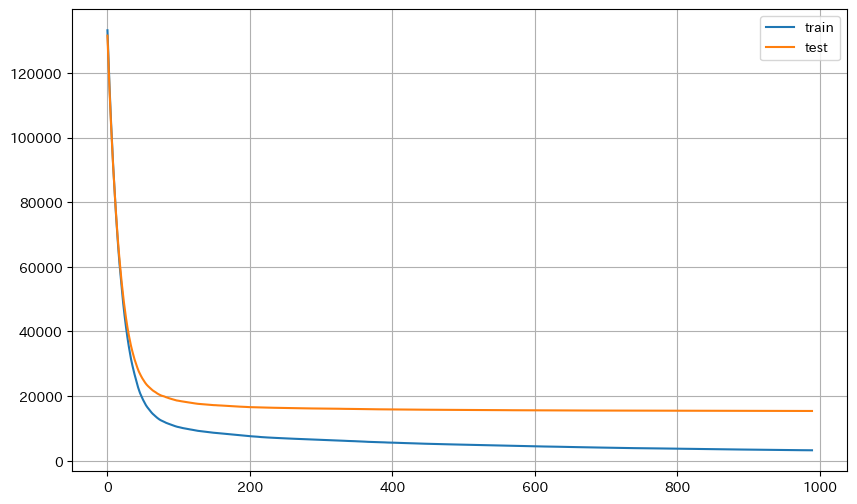

[20:40:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132930.92268	validation_1-rmse:132703.60780
[1]	validation_0-rmse:126879.23746	validation_1-rmse:126813.59501
[2]	validation_0-rmse:120871.70853	validation_1-rmse:120904.19918
[3]	validation_0-rmse:115169.32568	validation_1-rmse:115300.92099
[4]	validation_0-rmse:109783.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:100085.50794	validation_1-rmse:100565.05544
[7]	validation_0-rmse:95592.84719	validation_1-rmse:96197.62433
[8]	validation_0-rmse:91263.82664	validation_1-rmse:92060.15711
[9]	validation_0-rmse:87337.93214	validation_1-rmse:88418.87248
[10]	validation_0-rmse:83404.16982	validation_1-rmse:84677.12289
[11]	validation_0-rmse:79605.16439	validation_1-rmse:80970.19906
[12]	validation_0-rmse:76007.04607	validation_1-rmse:77369.60156
[13]	validation_0-rmse:72611.67586	validation_1-rmse:74028.10344
[14]	validation_0-rmse:69332.41579	validation_1-rmse:70886.39320
[15]	validation_0-rmse:66272.63338	validation_1-rmse:67825.10926
[16]	validation_0-rmse:63446.78605	validation_1-rmse:65146.17333
[17]	validation_0-rmse:60698.37915	validation_1-rmse:62491.48512
[18]	validation_0-rmse:58278.35832	validation_1-rmse:60256.46121
[19]	validation_0-rmse:55752.59913	validation_1-rmse:57844.42332
[20]	validation_0-rmse:53324.88151	validation_1-rmse:55575.01386
[21]	validation_0-rmse:5109

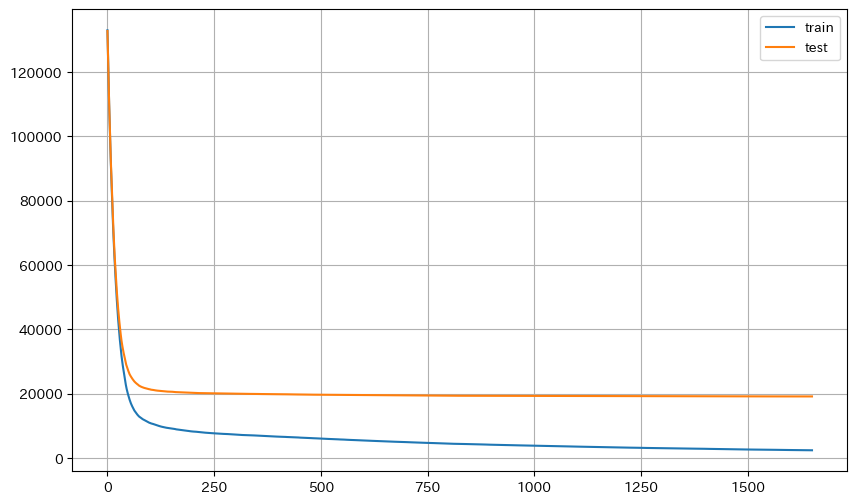

[20:40:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132481.09724	validation_1-rmse:134319.38297
[1]	validation_0-rmse:126466.85420	validation_1-rmse:128285.18398
[2]	validation_0-rmse:120491.28254	validation_1-rmse:122204.29274
[3]	validation_0-rmse:114828.84851	validation_1-rmse:116429.26218
[4]	validation_0-rmse:109472.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:99818.96931	validation_1-rmse:101332.24212
[7]	validation_0-rmse:95355.06570	validation_1-rmse:96867.82993
[8]	validation_0-rmse:91036.39125	validation_1-rmse:92617.81136
[9]	validation_0-rmse:87115.48573	validation_1-rmse:88788.20136
[10]	validation_0-rmse:83194.16826	validation_1-rmse:84862.72458
[11]	validation_0-rmse:79416.38106	validation_1-rmse:81027.32185
[12]	validation_0-rmse:75835.84333	validation_1-rmse:77442.38965
[13]	validation_0-rmse:72447.60388	validation_1-rmse:74074.08102
[14]	validation_0-rmse:69181.10801	validation_1-rmse:70800.48948
[15]	validation_0-rmse:66136.63489	validation_1-rmse:67773.54362
[16]	validation_0-rmse:63316.64971	validation_1-rmse:64927.00624
[17]	validation_0-rmse:60591.57632	validation_1-rmse:62257.26214
[18]	validation_0-rmse:58194.21086	validation_1-rmse:59856.57703
[19]	validation_0-rmse:55681.47336	validation_1-rmse:57347.84476
[20]	validation_0-rmse:53265.14677	validation_1-rmse:54952.51106
[21]	validation_0-rmse:51027

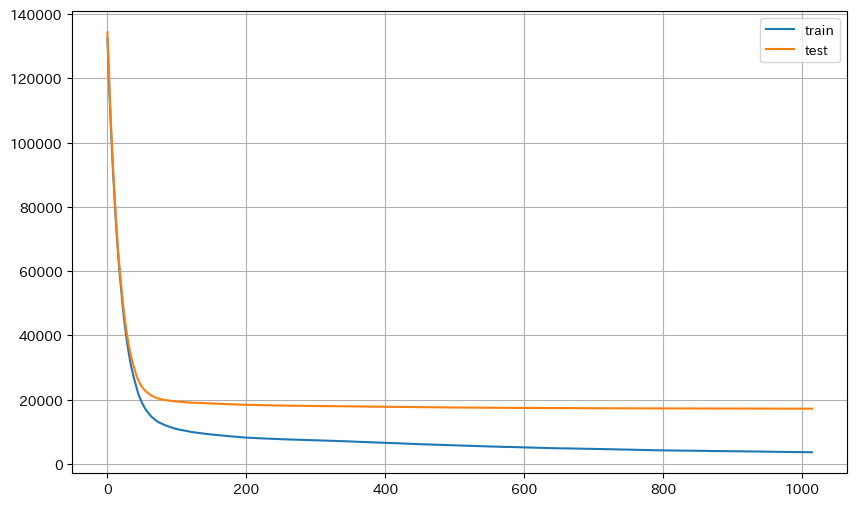

[20:40:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133183.51981	validation_1-rmse:131603.70805
[1]	validation_0-rmse:127116.36879	validation_1-rmse:125697.32784
[2]	validation_0-rmse:121098.68172	validation_1-rmse:119780.72729
[3]	validation_0-rmse:115378.39297	validation_1-rmse:114153.19613
[4]	validation_0-rmse:109976.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:100268.84701	validation_1-rmse:99251.28656
[7]	validation_0-rmse:95767.52747	validation_1-rmse:94904.94969
[8]	validation_0-rmse:91425.02700	validation_1-rmse:90633.97308
[9]	validation_0-rmse:87515.12877	validation_1-rmse:86843.14804
[10]	validation_0-rmse:83577.39751	validation_1-rmse:83074.28303
[11]	validation_0-rmse:79763.81313	validation_1-rmse:79403.80512
[12]	validation_0-rmse:76155.63384	validation_1-rmse:75948.23749
[13]	validation_0-rmse:72741.52745	validation_1-rmse:72679.16930
[14]	validation_0-rmse:69445.80867	validation_1-rmse:69500.04572
[15]	validation_0-rmse:66368.90446	validation_1-rmse:66591.27868
[16]	validation_0-rmse:63522.29804	validation_1-rmse:63902.80687
[17]	validation_0-rmse:60774.10731	validation_1-rmse:61262.52202
[18]	validation_0-rmse:58342.46333	validation_1-rmse:59031.72950
[19]	validation_0-rmse:55809.13063	validation_1-rmse:56690.44444
[20]	validation_0-rmse:53379.02251	validation_1-rmse:54424.08152
[21]	validation_0-rmse:51138

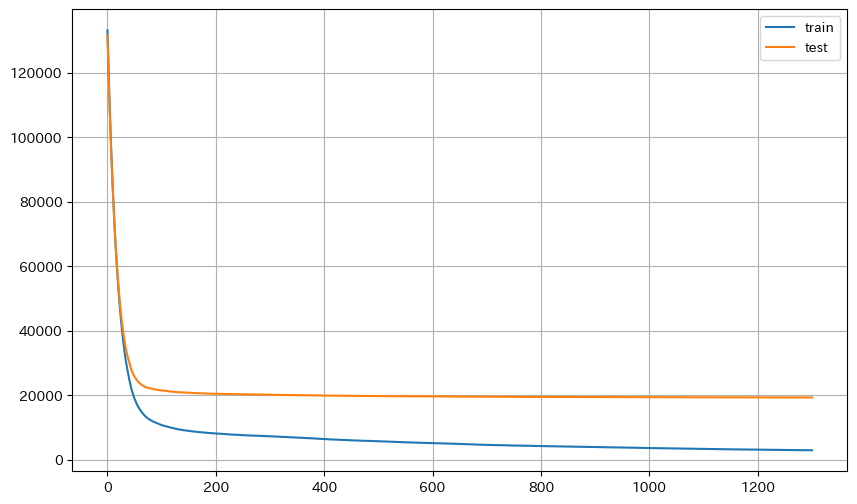

[20:41:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:41:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132441.08539	validation_1-rmse:134647.62583
[1]	validation_0-rmse:126430.46550	validation_1-rmse:128613.31647
[2]	validation_0-rmse:120452.19144	validation_1-rmse:122602.84786
[3]	validation_0-rmse:114781.45115	validation_1-rmse:116905.22374
[4]	validation_0-rmse:109421.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:99786.73859	validation_1-rmse:101915.51317
[7]	validation_0-rmse:95340.28829	validation_1-rmse:97527.22532
[8]	validation_0-rmse:91032.78371	validation_1-rmse:93242.26665
[9]	validation_0-rmse:87120.68113	validation_1-rmse:89516.08094
[10]	validation_0-rmse:83201.26553	validation_1-rmse:85552.52708
[11]	validation_0-rmse:79427.47354	validation_1-rmse:81691.80559
[12]	validation_0-rmse:75858.50086	validation_1-rmse:78121.07353
[13]	validation_0-rmse:72475.86885	validation_1-rmse:74691.77873
[14]	validation_0-rmse:69212.97273	validation_1-rmse:71319.67569
[15]	validation_0-rmse:66174.69287	validation_1-rmse:68329.81828
[16]	validation_0-rmse:63359.34445	validation_1-rmse:65536.95935
[17]	validation_0-rmse:60639.29336	validation_1-rmse:62870.39833
[18]	validation_0-rmse:58239.11565	validation_1-rmse:60612.38181
[19]	validation_0-rmse:55733.02914	validation_1-rmse:58175.58590
[20]	validation_0-rmse:53323.39008	validation_1-rmse:55776.97375
[21]	validation_0-rmse:51101

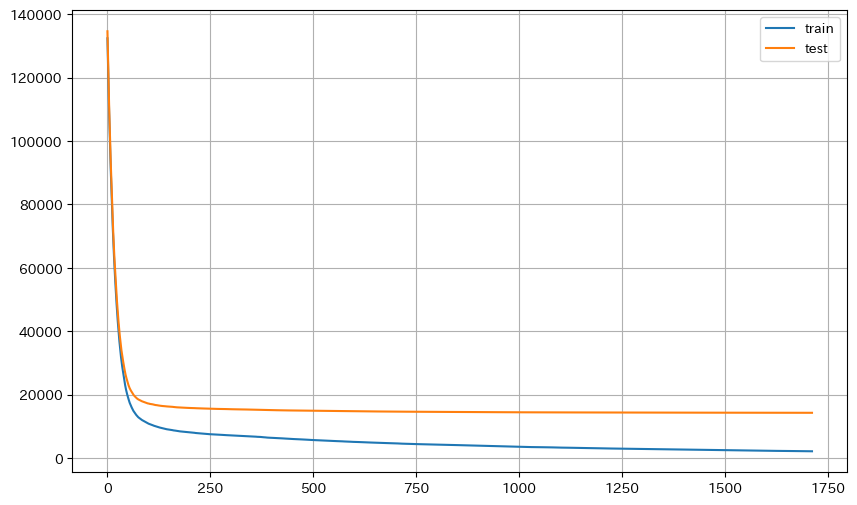

whole valid rmse: 17064.277471751582
Start predicting...


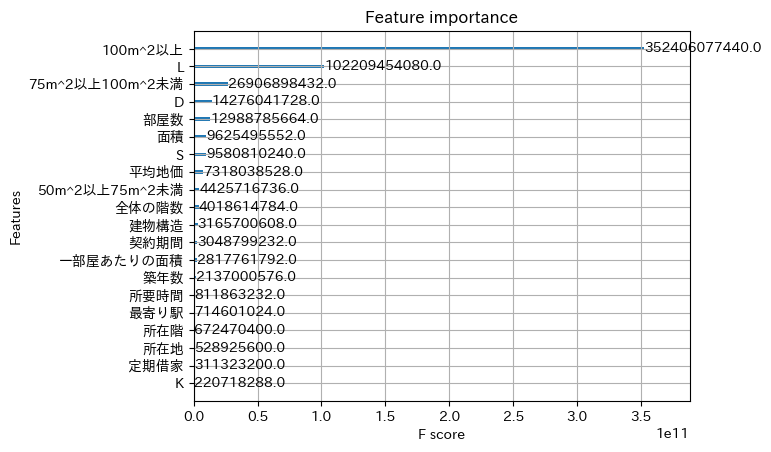

In [35]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=9,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=1.2667345328336822e-06,

                        sub_sample=0.07108627631238121,

                        colsample_bytree=0.5533941139217848,

                        min_child_weight=2.6216938007596378,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

チューニングしてもハイスコアには届かず・・・

XGBは情報が被っている特徴量が入っていると、精度が落ちるのではないか？試しに「地価」との情報被りを考慮して「所在地」を抜いてみる。

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', 'L', 'D','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

[20:47:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133070.41456	validation_1-rmse:131463.67585
[1]	validation_0-rmse:126923.04016	validation_1-rmse:125500.74619
[2]	validation_0-rmse:121061.26978	validation_1-rmse:119843.52296
[3]	validation_0-rmse:115523.63505	validation_1-rmse:114485.74502
[4]	validation_0-rmse:110225.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:87898.13773	validation_1-rmse:87942.78287
[10]	validation_0-rmse:84102.92996	validation_1-rmse:84277.96501
[11]	validation_0-rmse:80299.16219	validation_1-rmse:80670.35288
[12]	validation_0-rmse:76668.16524	validation_1-rmse:77223.76271
[13]	validation_0-rmse:73399.13073	validation_1-rmse:74122.93755
[14]	validation_0-rmse:70295.43604	validation_1-rmse:71203.29816
[15]	validation_0-rmse:67290.97902	validation_1-rmse:68382.97650
[16]	validation_0-rmse:64347.90550	validation_1-rmse:65629.46254
[17]	validation_0-rmse:61477.21660	validation_1-rmse:62938.96235
[18]	validation_0-rmse:58972.88141	validation_1-rmse:60625.41777
[19]	validation_0-rmse:56408.59376	validation_1-rmse:58215.36063
[20]	validation_0-rmse:54079.74236	validation_1-rmse:56060.07252
[21]	validation_0-rmse:51778.60312	validation_1-rmse:53951.87115
[22]	validation_0-rmse:49648.34746	validation_1-rmse:52009.58010
[23]	validation_0-rmse:47588.54306	validation_1-rmse:50118.12792
[24]	validation_0-rmse:458

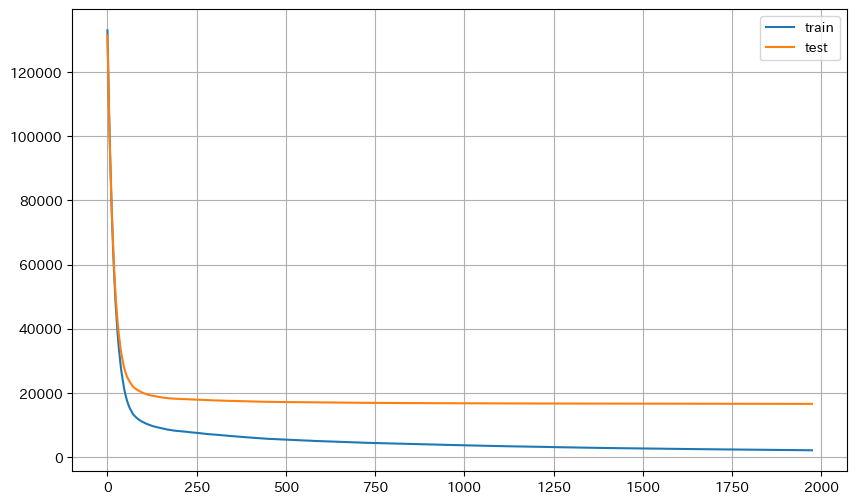

[20:47:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132827.46799	validation_1-rmse:132350.25558
[1]	validation_0-rmse:126708.24437	validation_1-rmse:126373.99401
[2]	validation_0-rmse:120865.15851	validation_1-rmse:120718.08415
[3]	validation_0-rmse:115331.13462	validation_1-rmse:115335.51017
[4]	validation_0-rmse:110058.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:100459.84991	validation_1-rmse:100871.08311
[7]	validation_0-rmse:95938.76580	validation_1-rmse:96550.97412
[8]	validation_0-rmse:91819.36398	validation_1-rmse:92650.24986
[9]	validation_0-rmse:87758.93714	validation_1-rmse:88709.07199
[10]	validation_0-rmse:83975.97987	validation_1-rmse:85160.05219
[11]	validation_0-rmse:80191.86405	validation_1-rmse:81555.57603
[12]	validation_0-rmse:76573.28703	validation_1-rmse:77922.32582
[13]	validation_0-rmse:73301.83042	validation_1-rmse:74843.53238
[14]	validation_0-rmse:70195.88782	validation_1-rmse:71889.27826
[15]	validation_0-rmse:67205.06261	validation_1-rmse:69014.75844
[16]	validation_0-rmse:64282.84090	validation_1-rmse:66252.95346
[17]	validation_0-rmse:61419.28657	validation_1-rmse:63544.80180
[18]	validation_0-rmse:58917.26008	validation_1-rmse:61227.45441
[19]	validation_0-rmse:56361.93639	validation_1-rmse:58888.51672
[20]	validation_0-rmse:54035.34412	validation_1-rmse:56708.88400
[21]	validation_0-rmse:5173

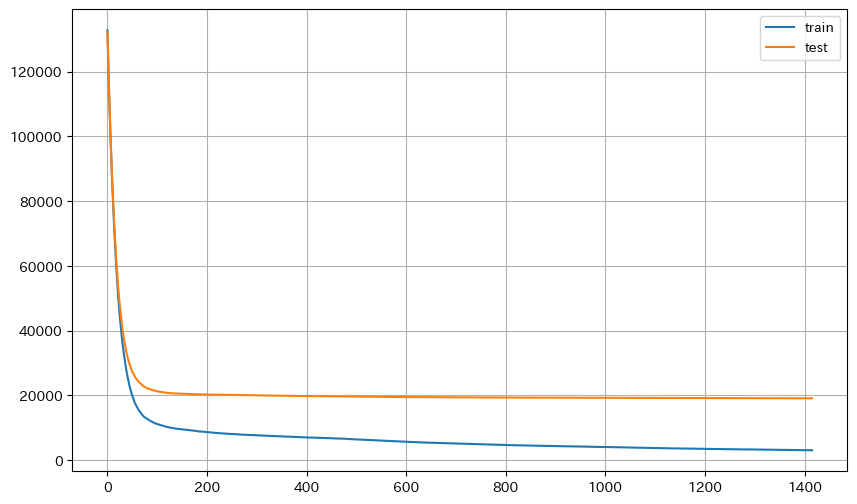

[20:48:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132379.27092	validation_1-rmse:134162.57970
[1]	validation_0-rmse:126287.82285	validation_1-rmse:128022.68906
[2]	validation_0-rmse:120467.61392	validation_1-rmse:122112.60648
[3]	validation_0-rmse:114966.62627	validation_1-rmse:116568.53932
[4]	validation_0-rmse:109710.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:100129.05906	validation_1-rmse:101787.54946
[7]	validation_0-rmse:95632.91949	validation_1-rmse:97289.99911
[8]	validation_0-rmse:91559.22894	validation_1-rmse:93175.94077
[9]	validation_0-rmse:87512.57825	validation_1-rmse:89102.48651
[10]	validation_0-rmse:83741.47731	validation_1-rmse:85307.89654
[11]	validation_0-rmse:79969.97783	validation_1-rmse:81532.60536
[12]	validation_0-rmse:76366.66071	validation_1-rmse:77871.80169
[13]	validation_0-rmse:73113.47941	validation_1-rmse:74552.33915
[14]	validation_0-rmse:70030.88818	validation_1-rmse:71501.07162
[15]	validation_0-rmse:67048.19397	validation_1-rmse:68482.17648
[16]	validation_0-rmse:64135.20316	validation_1-rmse:65476.25599
[17]	validation_0-rmse:61285.88211	validation_1-rmse:62616.63647
[18]	validation_0-rmse:58790.51150	validation_1-rmse:60120.90430
[19]	validation_0-rmse:56243.23662	validation_1-rmse:57626.74234
[20]	validation_0-rmse:53942.15237	validation_1-rmse:55297.69263
[21]	validation_0-rmse:5165

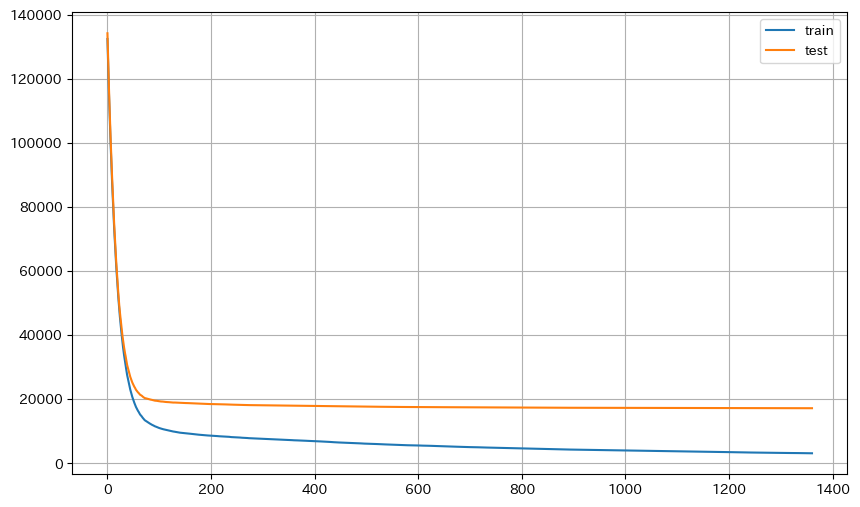

[20:48:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:133052.40892	validation_1-rmse:131427.99261
[1]	validation_0-rmse:126923.58438	validation_1-rmse:125380.77195
[2]	validation_0-rmse:121084.29986	validation_1-rmse:119627.66157
[3]	validation_0-rmse:115551.75776	validation_1-rmse:114114.43824
[4]	validation_0-rmse:110258.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:96100.10109	validation_1-rmse:95109.51021
[8]	validation_0-rmse:91991.58735	validation_1-rmse:91097.22168
[9]	validation_0-rmse:87918.28988	validation_1-rmse:87209.67153
[10]	validation_0-rmse:84127.31323	validation_1-rmse:83600.04389
[11]	validation_0-rmse:80316.09287	validation_1-rmse:79905.18547
[12]	validation_0-rmse:76683.56374	validation_1-rmse:76402.13438
[13]	validation_0-rmse:73420.84806	validation_1-rmse:73220.90011
[14]	validation_0-rmse:70326.10400	validation_1-rmse:70239.22495
[15]	validation_0-rmse:67326.67177	validation_1-rmse:67309.50933
[16]	validation_0-rmse:64376.69277	validation_1-rmse:64495.99333
[17]	validation_0-rmse:61491.53553	validation_1-rmse:61730.53984
[18]	validation_0-rmse:58984.69822	validation_1-rmse:59398.20848
[19]	validation_0-rmse:56414.31459	validation_1-rmse:56941.92433
[20]	validation_0-rmse:54086.83683	validation_1-rmse:54785.51134
[21]	validation_0-rmse:51773.55554	validation_1-rmse:52638.55485
[22]	validation_0-rmse:49640

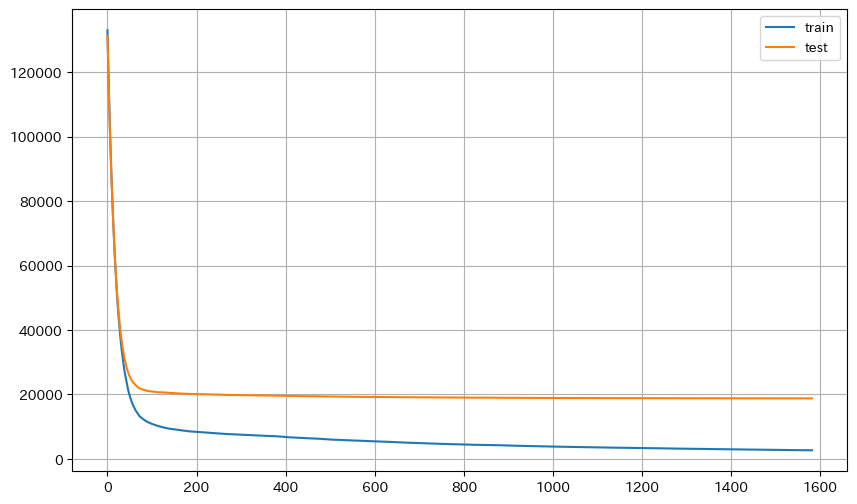

[20:49:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:49:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "evals", "evals_result", "reg_alfa", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:132341.52390	validation_1-rmse:134373.72055
[1]	validation_0-rmse:126262.26310	validation_1-rmse:128337.78867
[2]	validation_0-rmse:120456.02339	validation_1-rmse:122547.60052
[3]	validation_0-rmse:114950.91533	validation_1-rmse:117053.67512
[4]	validation_0-rmse:109702.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:100146.84188	validation_1-rmse:102581.75476
[7]	validation_0-rmse:95646.62546	validation_1-rmse:98172.62882
[8]	validation_0-rmse:91575.62082	validation_1-rmse:94257.65804
[9]	validation_0-rmse:87559.05594	validation_1-rmse:90337.86017
[10]	validation_0-rmse:83783.29106	validation_1-rmse:86712.21206
[11]	validation_0-rmse:80009.62823	validation_1-rmse:82913.95926
[12]	validation_0-rmse:76408.14109	validation_1-rmse:79328.87514
[13]	validation_0-rmse:73151.43387	validation_1-rmse:76285.81310
[14]	validation_0-rmse:70060.69473	validation_1-rmse:73258.11104
[15]	validation_0-rmse:67078.59282	validation_1-rmse:70290.55150
[16]	validation_0-rmse:64168.07320	validation_1-rmse:67404.26863
[17]	validation_0-rmse:61314.83792	validation_1-rmse:64442.66274
[18]	validation_0-rmse:58813.97353	validation_1-rmse:62108.44056
[19]	validation_0-rmse:56259.82857	validation_1-rmse:59671.12623
[20]	validation_0-rmse:53964.49319	validation_1-rmse:57474.03625
[21]	validation_0-rmse:5168

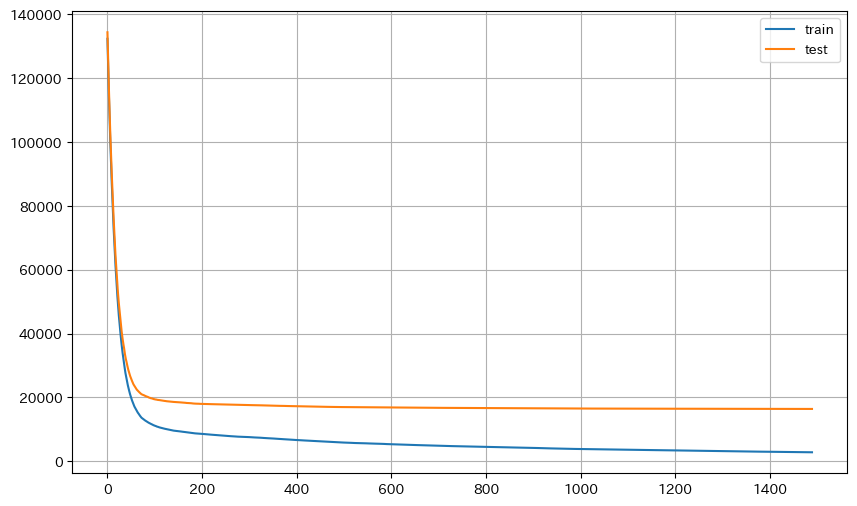

whole valid rmse: 17589.812275576183
Start predicting...


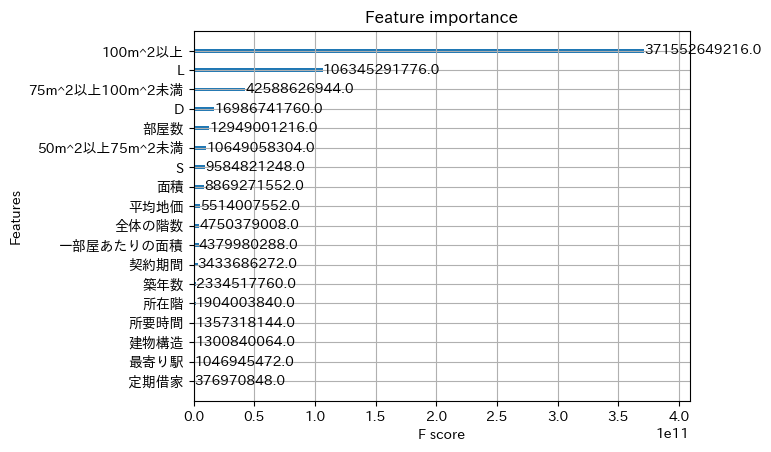

In [38]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    # 学習時に用いる検証用データ
    evals = [(X_tr, 'train'), (X_tr, 'eval')]
    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    xgb_reg = xgboost.XGBRegressor(
        #目的関数の指定 初期値も二乗誤差です
                        # 回帰問題
                        objective='reg:linear',
                        # 学習用の指標 (RMSE)
                        eval_metric='rmse',
                        #学習のラウンド数 early_stoppingを利用するので多めに指定
                        n_estimators=50000,
                        #boosterに何を用いるか 初期値もgbtreeです
                        booster='gbtree',
                        #学習率
                        learning_rate=0.05,
                        #木の最大深さ
                        max_depth=9,
                        #シード値
                        random_state=0,
                            #正則化
                        reg_alfa=1.2667345328336822e-06,

                        sub_sample=0.07108627631238121,

                        colsample_bytree=0.5533941139217848,

                        min_child_weight=2.6216938007596378,
                        
                        evals=evals,

                        evals_result=evals_result
    )
    xgb_reg.fit(X_tr, y_tr, 
                eval_set=[(X_tr, y_tr),(X_val, y_val)], 
                early_stopping_rounds=10, 
            )
    evals_result = xgb_reg.evals_result()
    train_evals = evals_result['validation_0']['rmse']
    test_evals = evals_result['validation_1']['rmse']

    pred_y_val = xgb_reg.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

    # 学習の課程を折れ線グラフとしてプロットする
    print('Plot metrics during training...')
    plt.figure(figsize=(10, 6))
    plt.subplot(111)
    x = range(len(train_evals))
    plt.plot(x, train_evals, label='train')
    plt.plot(x, test_evals, label='test')
    # plt.plot(x, ave_cv_evals, label='validation')
    plt.grid()
    plt.legend()
    plt.show()

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = xgb_reg.predict(X_test)

# feature importanceを表示
xgboost.plot_importance(xgb_reg, importance_type = "gain")
plt.show()

しかしスコア悪化

### CatBoostの検証

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'K','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満']

In [52]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    model = CatBoostRegressor(
        loss_function='RMSE', 
        iterations = 2000, 
        learning_rate=0.05, 
        depth=7, 
        l2_leaf_reg= 1.7538232373118053e-06, 
        random_strength=26, 
        bagging_temperature = 12.500712230836259,
        od_type='Iter',
        # od_wait = 10
        )

    train_pool = Pool(X_tr, label=y_tr, cat_features=category_lists)
    valid_pool = Pool(X_val, label=y_val, cat_features=category_lists)

    model.fit(train_pool, eval_set=valid_pool, use_best_model=True, early_stopping_rounds=10, plot=True)
    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)
y_pred = model.predict(X_test)
# feature importanceを表示
importance = pd.DataFrame(model.get_feature_importance(type="PredictionValuesChange"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 72192.7140027	test: 70970.5085274	best: 70970.5085274 (0)	total: 11.8ms	remaining: 23.6s
1:	learn: 70246.0364273	test: 69058.7067662	best: 69058.7067662 (1)	total: 20ms	remaining: 20s
2:	learn: 69009.3505194	test: 67858.0708366	best: 67858.0708366 (2)	total: 26.6ms	remaining: 17.7s
3:	learn: 67544.6238569	test: 66449.4144362	best: 66449.4144362 (3)	total: 31.9ms	remaining: 15.9s
4:	learn: 66502.7878732	test: 65422.6877406	best: 65422.6877406 (4)	total: 36.4ms	remaining: 14.5s
5:	learn: 65285.4505613	test: 64200.5266815	best: 64200.5266815 (5)	total: 41.4ms	remaining: 13.8s
6:	learn: 63902.8725395	test: 62851.6941923	best: 62851.6941923 (6)	total: 49.2ms	remaining: 14s
7:	learn: 62078.5482253	test: 61286.3741018	best: 61286.3741018 (7)	total: 55.7ms	remaining: 13.9s
8:	learn: 60504.0856133	test: 59945.7511237	best: 59945.7511237 (8)	total: 61.5ms	remaining: 13.6s
9:	learn: 59601.9505831	test: 59169.8258646	best: 59169.8258646 (9)	total: 67.8ms	remaining: 13.5s
10:	learn: 58305

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 71517.2436931	test: 72113.4934568	best: 72113.4934568 (0)	total: 12.9ms	remaining: 25.8s
1:	learn: 69507.7601920	test: 70115.7701456	best: 70115.7701456 (1)	total: 20.8ms	remaining: 20.8s
2:	learn: 67951.0279705	test: 68554.8831077	best: 68554.8831077 (2)	total: 29.4ms	remaining: 19.5s
3:	learn: 66416.0251219	test: 67071.8856721	best: 67071.8856721 (3)	total: 37.1ms	remaining: 18.5s
4:	learn: 65092.4735372	test: 65724.5605046	best: 65724.5605046 (4)	total: 44.2ms	remaining: 17.6s
5:	learn: 63774.5837423	test: 64312.7573223	best: 64312.7573223 (5)	total: 51ms	remaining: 17s
6:	learn: 62216.9731369	test: 62782.0987548	best: 62782.0987548 (6)	total: 58.4ms	remaining: 16.6s
7:	learn: 61874.4744840	test: 62451.1276280	best: 62451.1276280 (7)	total: 61.4ms	remaining: 15.3s
8:	learn: 60194.2278175	test: 60746.3007128	best: 60746.3007128 (8)	total: 68ms	remaining: 15s
9:	learn: 58877.1972006	test: 59445.3521202	best: 59445.3521202 (9)	total: 77.1ms	remaining: 15.3s
10:	learn: 57720.1

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 71865.8836901	test: 72394.0615634	best: 72394.0615634 (0)	total: 10.9ms	remaining: 21.8s
1:	learn: 69860.7031159	test: 70249.8170913	best: 70249.8170913 (1)	total: 20ms	remaining: 20s
2:	learn: 68413.2245734	test: 68687.8348033	best: 68687.8348033 (2)	total: 24.5ms	remaining: 16.3s
3:	learn: 66913.0813205	test: 67097.5495367	best: 67097.5495367 (3)	total: 31.9ms	remaining: 15.9s
4:	learn: 65617.3894073	test: 65732.2141416	best: 65732.2141416 (4)	total: 41.4ms	remaining: 16.5s
5:	learn: 64138.9598861	test: 64159.8680055	best: 64159.8680055 (5)	total: 47.2ms	remaining: 15.7s
6:	learn: 62689.4097404	test: 62595.2695467	best: 62595.2695467 (6)	total: 55.4ms	remaining: 15.8s
7:	learn: 61123.9979887	test: 60890.7835122	best: 60890.7835122 (7)	total: 62.2ms	remaining: 15.5s
8:	learn: 59706.7287148	test: 59367.0633883	best: 59367.0633883 (8)	total: 70.4ms	remaining: 15.6s
9:	learn: 58557.6364798	test: 58157.9058276	best: 58157.9058276 (9)	total: 76ms	remaining: 15.1s
10:	learn: 57295

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 72539.9782747	test: 69468.8791211	best: 69468.8791211 (0)	total: 29.2ms	remaining: 58.3s
1:	learn: 70573.6794555	test: 67655.5456510	best: 67655.5456510 (1)	total: 45.5ms	remaining: 45.4s
2:	learn: 69339.3358792	test: 66447.3873865	best: 66447.3873865 (2)	total: 57.8ms	remaining: 38.5s
3:	learn: 67878.9888014	test: 65141.9269266	best: 65141.9269266 (3)	total: 67.6ms	remaining: 33.7s
4:	learn: 66845.9284672	test: 64150.6323021	best: 64150.6323021 (4)	total: 76.5ms	remaining: 30.5s
5:	learn: 65554.4967841	test: 62801.3554364	best: 62801.3554364 (5)	total: 83.8ms	remaining: 27.9s
6:	learn: 63848.3767464	test: 61096.3681290	best: 61096.3681290 (6)	total: 91.3ms	remaining: 26s
7:	learn: 62370.7405451	test: 59664.2750543	best: 59664.2750543 (7)	total: 98ms	remaining: 24.4s
8:	learn: 61130.7432801	test: 58432.0868691	best: 58432.0868691 (8)	total: 105ms	remaining: 23.2s
9:	learn: 59985.3350886	test: 57331.6874659	best: 57331.6874659 (9)	total: 112ms	remaining: 22.3s
10:	learn: 58769

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 71327.4905584	test: 74546.2179118	best: 74546.2179118 (0)	total: 9.28ms	remaining: 18.5s
1:	learn: 69414.3251235	test: 72611.3514594	best: 72611.3514594 (1)	total: 16.6ms	remaining: 16.5s
2:	learn: 68177.7438416	test: 71400.8574942	best: 71400.8574942 (2)	total: 22.3ms	remaining: 14.8s
3:	learn: 66607.9207518	test: 69703.7818090	best: 69703.7818090 (3)	total: 28.8ms	remaining: 14.4s
4:	learn: 65582.1872455	test: 68698.6509988	best: 68698.6509988 (4)	total: 33ms	remaining: 13.2s
5:	learn: 64395.9823640	test: 67435.7141726	best: 67435.7141726 (5)	total: 37.4ms	remaining: 12.4s
6:	learn: 63042.2612246	test: 66062.2849263	best: 66062.2849263 (6)	total: 44.8ms	remaining: 12.8s
7:	learn: 61380.9780750	test: 64336.3099628	best: 64336.3099628 (7)	total: 51.6ms	remaining: 12.8s
8:	learn: 60022.0918439	test: 62879.7860136	best: 62879.7860136 (8)	total: 57.1ms	remaining: 12.6s
9:	learn: 59057.9181435	test: 61983.7568284	best: 61983.7568284 (9)	total: 63.3ms	remaining: 12.6s
10:	learn: 5

importance
面積                22.935212
一部屋あたりの面積         11.099837
最寄り駅               9.782562
平均地価               9.485967
部屋数                8.862288
築年数                6.441756
所在地                6.425071
100m^2以上           5.850734
全体の階数              3.909091
L                  3.488704
定期借家               3.288009
所在階                2.011835
D                  1.733157
契約期間               1.230912
75m^2以上100m^2未満    1.153467
所要時間               1.093564
50m^2以上75m^2未満     0.607723
S                  0.346850
建物構造               0.224360
K                  0.028902
バス・トイレ別            0.000000

CatBoostも18336で大きく改善！

In [53]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/CatBoost_cv_result.csv',index=False)